# Covid-19 Script Integrating Exogenous-Forecast (In Development)

In [1]:
# Import libraries

# standard libraries
import numpy as np
import pandas as pd
import datetime as dt
import os
import requests

# exogenous
from pytrends.request import TrendReq
from time import sleep #to slow down request rate from Google

# visualization
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

# statistics and modeling
import statsmodels.api as sm 
from statsmodels.tsa.api import  Holt, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import xgboost as xgb
    
# progress bar 
from tqdm import tnrange, tqdm_notebook
from time import sleep
    
import warnings
warnings.filterwarnings('ignore')

# Constants

## global variables

In [2]:
#END_DATE = dt.datetime.now().strftime('%Y-%m-%d') # end date to forecast to.

START_DATE = pd.to_datetime('3/01/2020')
END_DATE = pd.to_datetime('1/08/2021') #day before trend changes direction and covid cases improve
COUNTRY_NAME = 'US'
DATA_NAME = 'Confirmed Cases'
REMOTE_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
LOWESS_WINDOW_LENGTH = 22         # size of the LOESS window to pass through
MINIMAL_TRAINING_SET_SIZE = 100    # minimal training set size (recommend 50-100)
FORECAST_LENGTH = 15              # length of the short run forecast
NUMBER_TOP_ARIMA_RESULTS = 1      # num of top ARIMA results calculated against MSE, BIC, AIC

## settings

In [3]:
# display settings options

pd.options.display.max_rows = 100        #Increases the number of rows displayed without a break in the middle.
pd.options.display.max_columns = 100     #Increases the number of columns displayed without a break in the middle.
pd.set_option('max_colwidth',100)        #Increases the width of the columns to display 100 characters at the same time.


In [4]:
def check_local_data():
    
    # make sure data directory exists
    data_dir = './data'
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)

    # define local file path(s)
    local_confirmed_file = os.path.join(data_dir, 'confirmed.csv')
    
    return local_confirmed_file

In [5]:
def load_data(remote_url, local_path, force=False, age_limit_hours=12):
    '''
    Load data into a dataframe.
    
    If data does not exist locally, download and cache locally. If data
    exists locally and is less than age limit (age_limit_hours) then use
    local cached file, otherwise re-download.
    
    Params:
    
    - remote_url (str): path to data set online
    - local_path (str): local path for cache file
    - force (bool): force the download (disregards age_limit_hours), default=False
    - age_limit_hours (float): age in hours for which to use a cached file
    
    Returns DataFrame with data.
    '''
     
    # Check age of local file (in hours)
    if os.path.exists(local_path):
        age_in_hours = (
            dt.datetime.now().timestamp()
            - os.stat(local_path).st_mtime
        ) / 60 / 60
    else:
        # File doesn't exist, force download
        force = True
    
    # If forced or past age limit, download file
    if force or age_in_hours > age_limit_hours:
        
        # Download dataset
        r = requests.get(remote_url)
        if r.status_code == requests.status_codes.codes.ok:
            with open(local_path, 'wb') as f:
                f.write(r.content)
        else:
            raise RuntimeError('Could not download dataset.')
    
    # Load data from local cache
    df = pd.read_csv(local_path)
    
    return df

In [6]:
def country_data(df, country, lowess_window_length, show_data=False):
    '''
    Generate a DataFrame and with incremental and cumulative data
    for `country`, smoothed version of each, and the first, second
    and third derivatives of the total data.
    
    The `df` is expected to have the following columns: 'Province/State',
    'Country/Region', 'Lat', 'Long', and then a series of columns with
    string names in date format '%m/%d/%y'.
    
    Params:
    
    - df (DataFrame): cases dataframe with 'Country/Region' column for country
    - country (str): name of the country to filter `df['Country/Region']`
    - show_data (bool): flag to control output of raw data; default=False
    - show_plot (bool): flag to control output of chart; default=True
    '''
    # Get copy of dataframe for just the desired `country`
    country_subset = (
        df.loc[df['Country/Region'] == country].copy() # get a copy of just country data
        .drop(columns=['Lat','Long']) # remove extra columns
        .groupby(by=['Country/Region']).sum() # consolidate in case multi-province/state
    )
    
    # Convert columns to real dates from m/d/y format
    country_subset.columns = [
        dt.datetime.strptime(col, '%m/%d/%y')
        for col in country_subset.columns
    ]
    
    # Construct daily by differencing the cumulative numbers
    daily_subset = country_subset.diff(periods=1, axis=1)
    daily_subset.iloc[0, 0] = country_subset.iloc[0, 0] # fix first reported date
    daily_subset = daily_subset.fillna(0) # ensure we don't have any nulls

    # create original_x and ordinal_x for displaying and modeling
    original_x = list(country_subset.columns)
    ordinal_x = list(range(len(original_x)))
    
    # Build up a dataframe with all computed series
    total_df = pd.DataFrame({
        'original_x': original_x,
        'ordinal_x': ordinal_x,
        'total_count': country_subset.iloc[0],
        'daily_count': daily_subset.iloc[0]
    })
    
    total_df['daily_count_filled'] = total_df['daily_count'].replace(to_replace=0, value = None).interpolate(method='linear')

    x       = total_df['ordinal_x']
    y_daily = total_df['daily_count_filled']
    y_total = total_df['total_count']
   
    total_df['log_daily_count'] = np.log1p(total_df['daily_count'])
    total_df['daily_count_smooth'] = smooth_lowess(total_df['daily_count_filled'], lowess_window_length, fill_missing = True)
    total_df['log_daily_count_smooth'] = np.log1p(total_df['daily_count_smooth'])
    total_df['daily_count_smooth_residuals'] =  total_df['daily_count_smooth']-total_df['daily_count_filled']
    total_df['log_daily_count_smooth_residuals'] = np.log1p(total_df['daily_count_smooth'])-np.log1p(total_df['daily_count_filled'])
    
    total_df['log_total_count'] = np.log1p(total_df['total_count'])
    total_df['total_count_smooth'] = smooth_lowess(total_df['total_count'], lowess_window_length, fill_missing = True)
    total_df['log_total_count_smooth'] = np.log1p(total_df['total_count_smooth'])
    total_df['total_count_smooth_residuals'] = total_df['total_count_smooth']-total_df['total_count']
    total_df['log_total_count_smooth_residuals' ]= np.log1p(total_df['total_count_smooth'])-np.log1p(total_df['total_count'])
    
    total_df['first_derivative'] = np.gradient(total_df['total_count'])
    total_df['log_first_derivative'] = np.log1p(total_df['first_derivative'])
    total_df['first_derivative_smooth'] = smooth_lowess(total_df['first_derivative'], lowess_window_length, fill_missing = True)
    total_df['log_first_derivative_smooth'] = np.log1p(total_df['first_derivative_smooth'])
    total_df['first_derivative_smooth_residuals'] = total_df['first_derivative_smooth'] - total_df['first_derivative']
    total_df['log_first_derivative_smooth_residuals'] = np.log1p(total_df['first_derivative_smooth']) - np.log1p(total_df['first_derivative'])
    
    total_df['second_derivative'] = np.gradient(total_df['daily_count_smooth'])
    total_df['log_second_derivative'] = np.log1p(total_df['second_derivative'])    
    total_df['second_derivative_smooth'] = smooth_lowess(total_df['second_derivative'], lowess_window_length, fill_missing = True)
    total_df['log_second_derivative_smooth'] = np.log1p(total_df['second_derivative_smooth'])    
    total_df['second_derivative_smooth_residuals'] = total_df['second_derivative_smooth']-total_df['second_derivative']
    total_df['log_second_derivative_smooth_residuals'] = np.log1p(total_df['second_derivative_smooth'])-np.log1p(total_df['second_derivative'])    
    
    if show_data == True:
        display(country_subset.head())
        display(daily_subset.head())
        display(total_df.head(100))
    
    return(total_df)

# Load our dataset

In [7]:
# find local file
local_confirmed_file = check_local_data()

# update with raw data on Confirmed Cases based on the age of the data
data = load_data(REMOTE_URL, local_path=local_confirmed_file, force=False, age_limit_hours=12)
data.name = DATA_NAME

# select for country
data = data.loc[data['Country/Region'] == COUNTRY_NAME].melt()

# screen out rows with Province/State, Country/Region, Lat, Long, and rename the columns 'date' and 'y'
data = data.iloc[4: , :].rename(columns = {'variable':'date', 'value':'y'})
data['y'] =  data['y'].astype(int).fillna(0)

#reset the index
data = data.reset_index(drop = True)

# convert COVID totals to daily data
data['y'] = data['y'].diff(periods=1).fillna(0)
data[data['y'] < 0] = 0

# convert the date values to datetime
data['date'] = pd.to_datetime(data['date'])

data.head()

date    y
0 2020-01-22  0.0
1 2020-01-23  0.0
2 2020-01-24  1.0
3 2020-01-25  0.0
4 2020-01-26  3.0

# Establish a Trendline

In [8]:
def smooth_lowess(y_series, lowess_window_length=22, smoothing_iterations=1, fill_missing=True, allow_negative_values=False):

    """
    This is a customized LOWESS (locally weighted scatterplot smoothing) implementation using Statstmodels, that attempts to
    "smooth" a discrete data set to a continuous one.  In the case of the LOWESS, each smoothed value is given by a weighted
    linear least squares regression over the span.
    
    Params:
    
    y_series:  Pandas series of discrete points as the inputs variable y
    lowess_window_length:  This is the window length passed smoothed through the data set. It cannot be less than 3. 
    
    """
    import statsmodels.api as sm
    
    y_series = y_series.fillna(0)
    x_series = list(np.arange(0,len(y_series),1))
    window = lowess_window_length/len(x_series)
    
    if allow_negative_values == False:
        y_series[y_series < 0] = 0  #replace all values less than zero with 0

    # if the dataset has NaN values, they will be replaced with linear interpolation
    if fill_missing == True:
        y_series = y_series.replace(to_replace=0, value = None).interpolate(method='linear')
    
    # log transform the series and execute the smoothing function
    y_series = np.log1p(y_series)
    lowess = sm.nonparametric.lowess
    smooth = lowess(y_series, x_series, frac = window, it = smoothing_iterations)
    index, y_hat = np.transpose(smooth)
    
    # reverse transform the series by taking the inverse log 1p
    y_hat = np.expm1(y_hat)
    
    # convert yhat to a series to return
    y_hat = pd.Series(list(y_hat))
    print(f'The length of the y_hat is: {len(y_hat)}.')
    
    return y_hat

In [9]:
def smooth_lowess(y_series, lowess_window_length = 22, smoothing_iterations = 2, fill_missing = True, allow_negative_values = False):
    
    """
    This is a customized LOWESS (locally weighted scatterplot smoothing) implementation using Statstmodels, that attempts to
    "smooth" a discrete data set to a continuous one.  In the case of the LOWESS, each smoothed value is given by a weighted
    linear least squares regression over the span.
    
    Params:
    
    y_series:  Pandas series of discrete points as the inputs variable y
    lowess_window_length:  This is the window length passed smoothed through the data set. It cannot be less than 3. 
    smoothing_iterations: number of times to iterate the smoother
    fill_missing: If True then it interpolates NaN values using a the 'linear' interpolate method. 
    allow_negative_values: If False, then all negative values are replaced with a zero.
    
    Returns:
    yhat: a Pandas series of the smoothed values.
    
    """
    import statsmodels.api as sm
    
    y_series = y_series.fillna(0) # replace all NaN values with 0
    x_series = list(np.arange(0,len(y_series),1))
    #print('lowess_window_length:  ',lowess_window_length)
    
    window = lowess_window_length/len(x_series)
    
    if allow_negative_values == False:
        y_series[y_series < 0] = 0  #replace all values less than zero with 0
    
    # if the dataset has NaN values, they will be replaced with linear interpolation
    if fill_missing == True:
        y_series = y_series.replace(to_replace=0, value = None).interpolate(method='linear')
        y_series = y_series.fillna(0)
    
    #log transform the series
    y_series = np.log1p(y_series)
    
    lowess = sm.nonparametric.lowess
    smooth = lowess(y_series, x_series, frac = window, it = smoothing_iterations)
    index, yhat = np.transpose(smooth)
    
    #reverse transform the series by taking the inverse log 1p
    yhat = np.expm1(yhat)
    
    return yhat

In [10]:
# execute the LOWESS SMOOTHER
data['lowess'] = smooth_lowess(data['y'])
display(data.head())
display(data.tail())

date    y    lowess
0 2020-01-22  0.0  0.947531
1 2020-01-23  0.0  1.004423
2 2020-01-24  1.0  1.060836
3 2020-01-25  0.0  1.115952
4 2020-01-26  3.0  1.168858

date        y        lowess
512 2021-06-17  10399.0  11089.864791
513 2021-06-18  20608.0  10773.693794
514 2021-06-19   8520.0  10464.844485
515 2021-06-20   3892.0  10164.195617
516 2021-06-21  12388.0   9874.032451

# Initial Plots of the Data

## Goal: What happens next? Can we predict it?

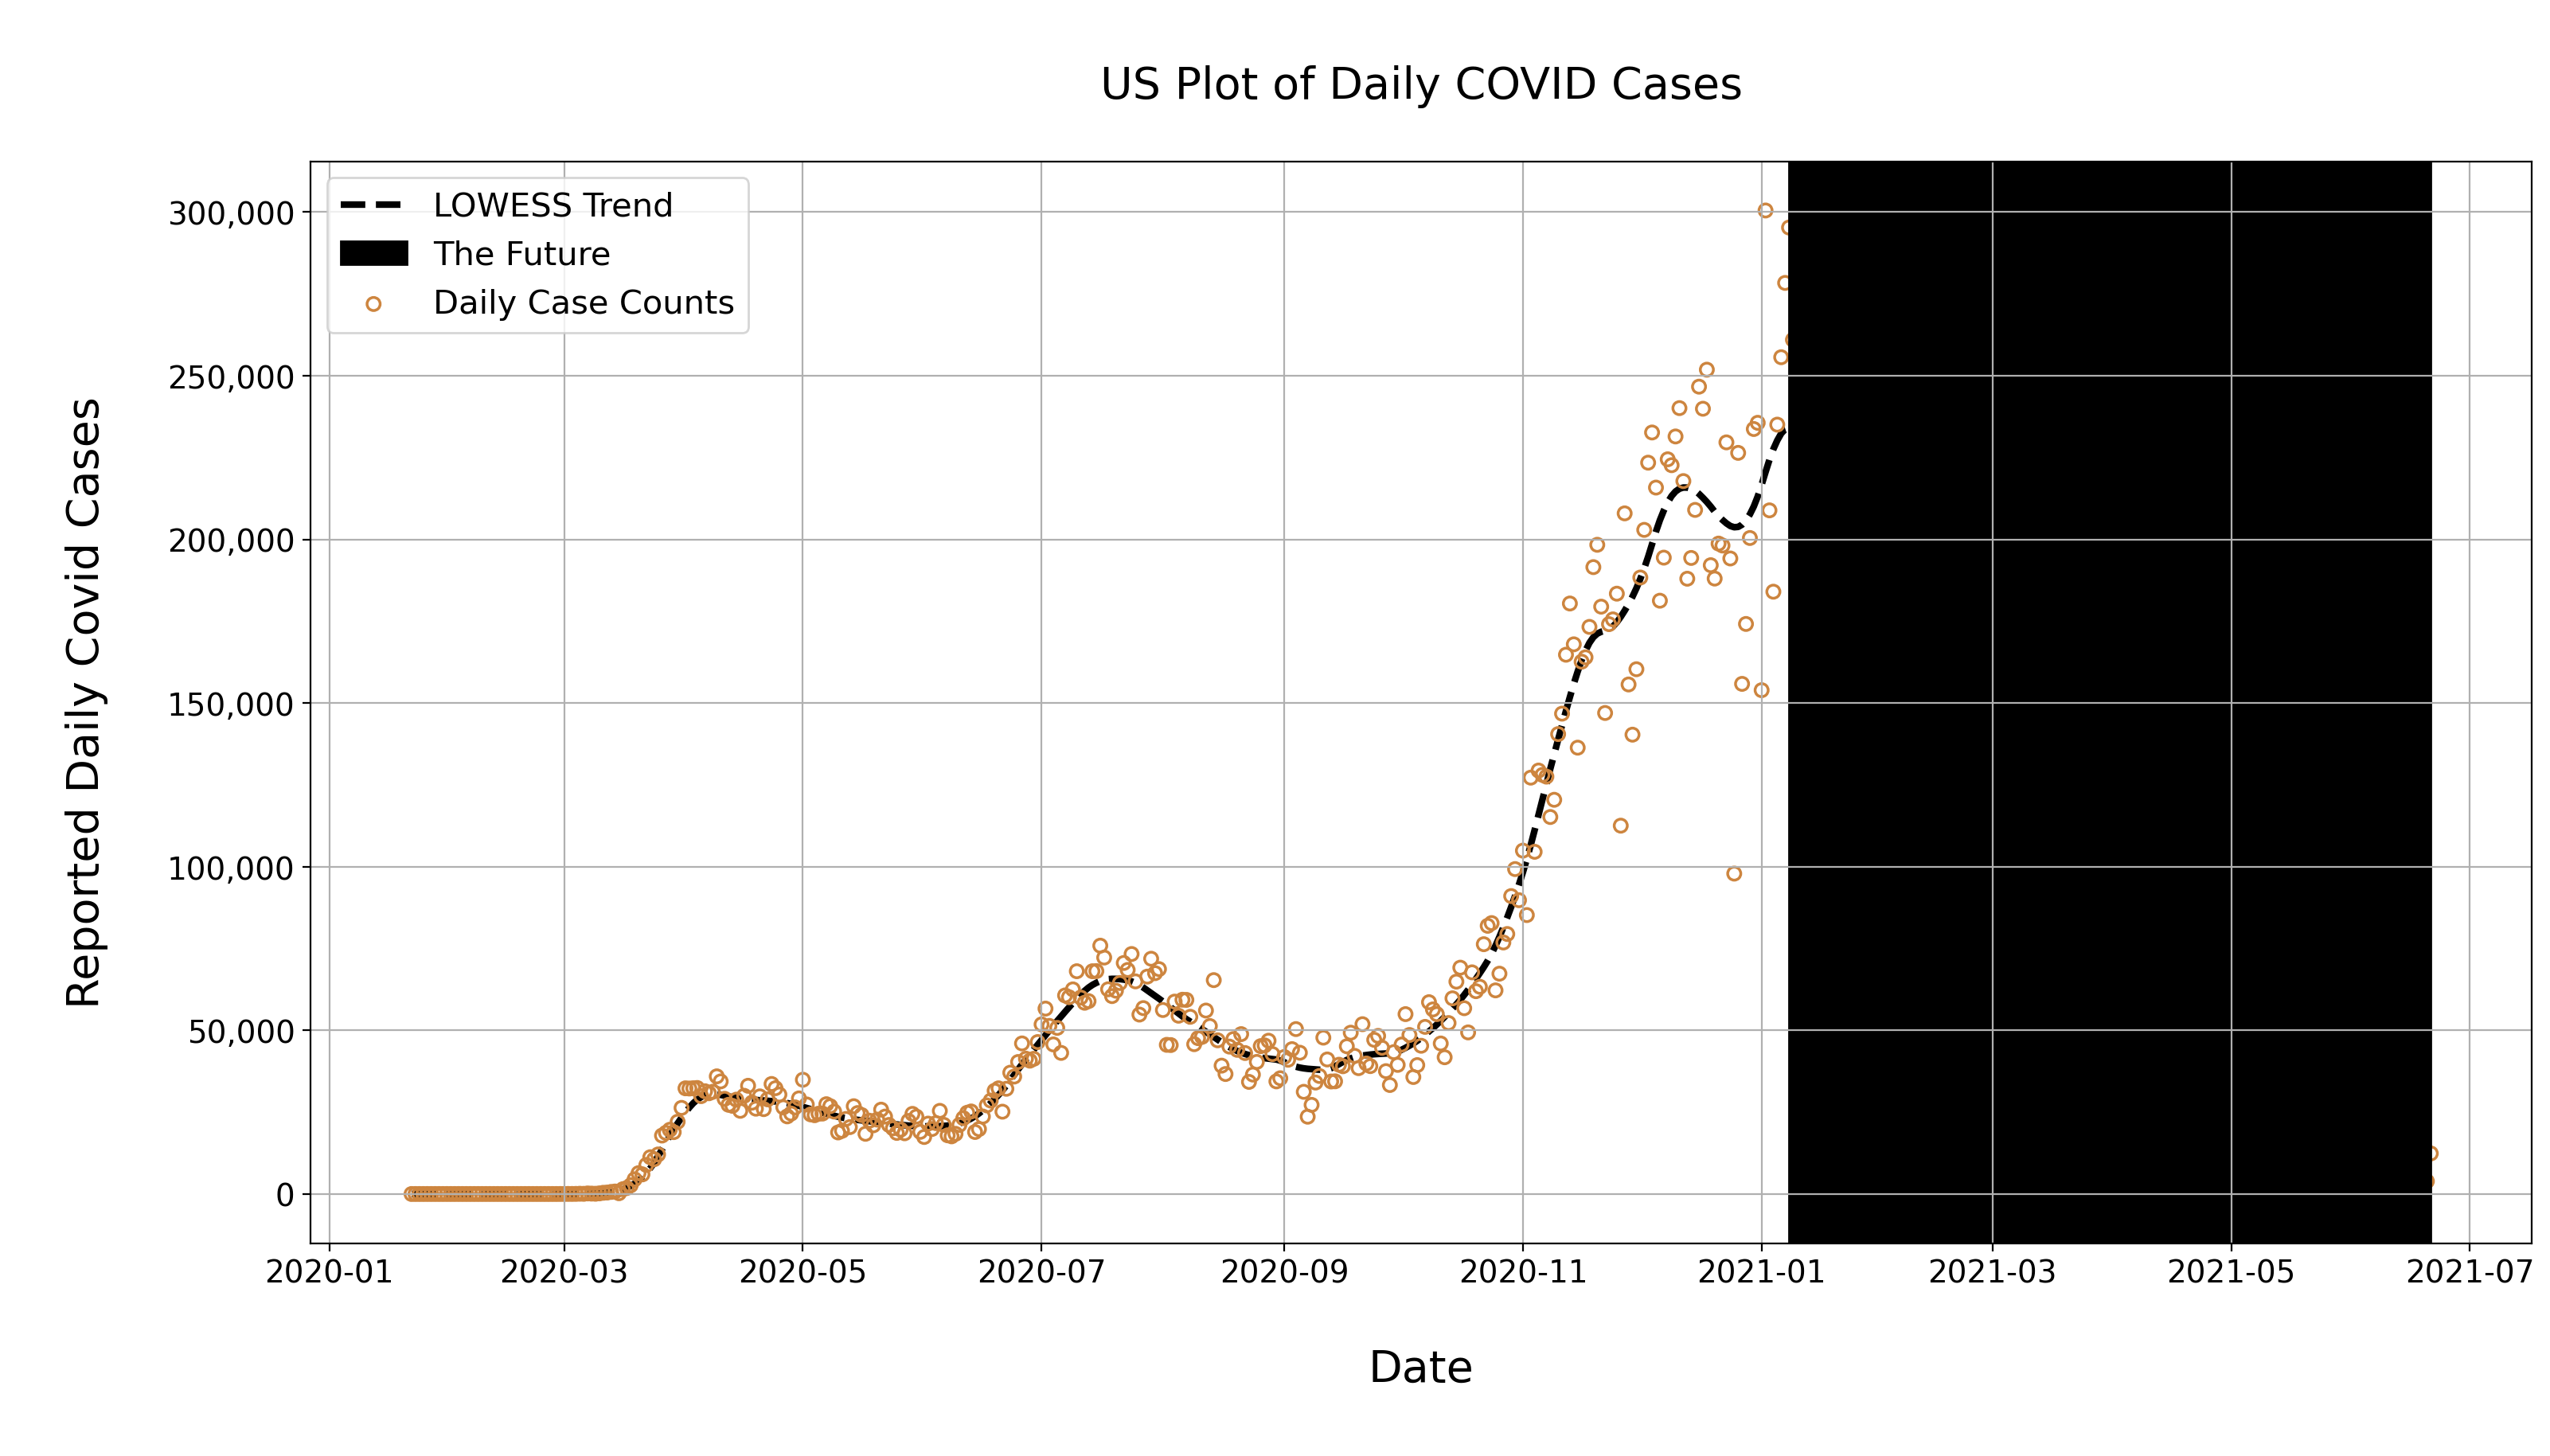

In [11]:
# make the plot of the daily data and smoothed vlaues
plt.style.context('ggplot')
fig, ax = plt.subplots(figsize = (18,9), dpi = 200)

fmt = '{x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
ax.tick_params(axis='y', labelsize = 14)
ax.tick_params(axis='x', labelsize = 14)

ax.set_title('\n{} Plot of Daily COVID Cases\n'.format(COUNTRY_NAME), fontsize = 20)
ax.set_xlabel('\nDate\n', fontsize = 20)
ax.set_ylabel('\nReported Daily Covid Cases\n', fontsize = 20)

ax.axvspan(END_DATE, max(data.date), alpha=1, color='black', label = 'The Future')

ax.scatter(data.date, data.y, facecolors='none', edgecolors='peru', linewidth = 1.25, s = 35, label = 'Daily Case Counts')
ax.plot(data.date, data.lowess, linestyle = '--', color = 'black', linewidth = 3 ,label = 'LOWESS Trend', zorder = 0)
ax.grid(which = 'major')
plt.legend(loc = 2, fontsize = 15)
plt.show()

## Initial Plot and Trendline

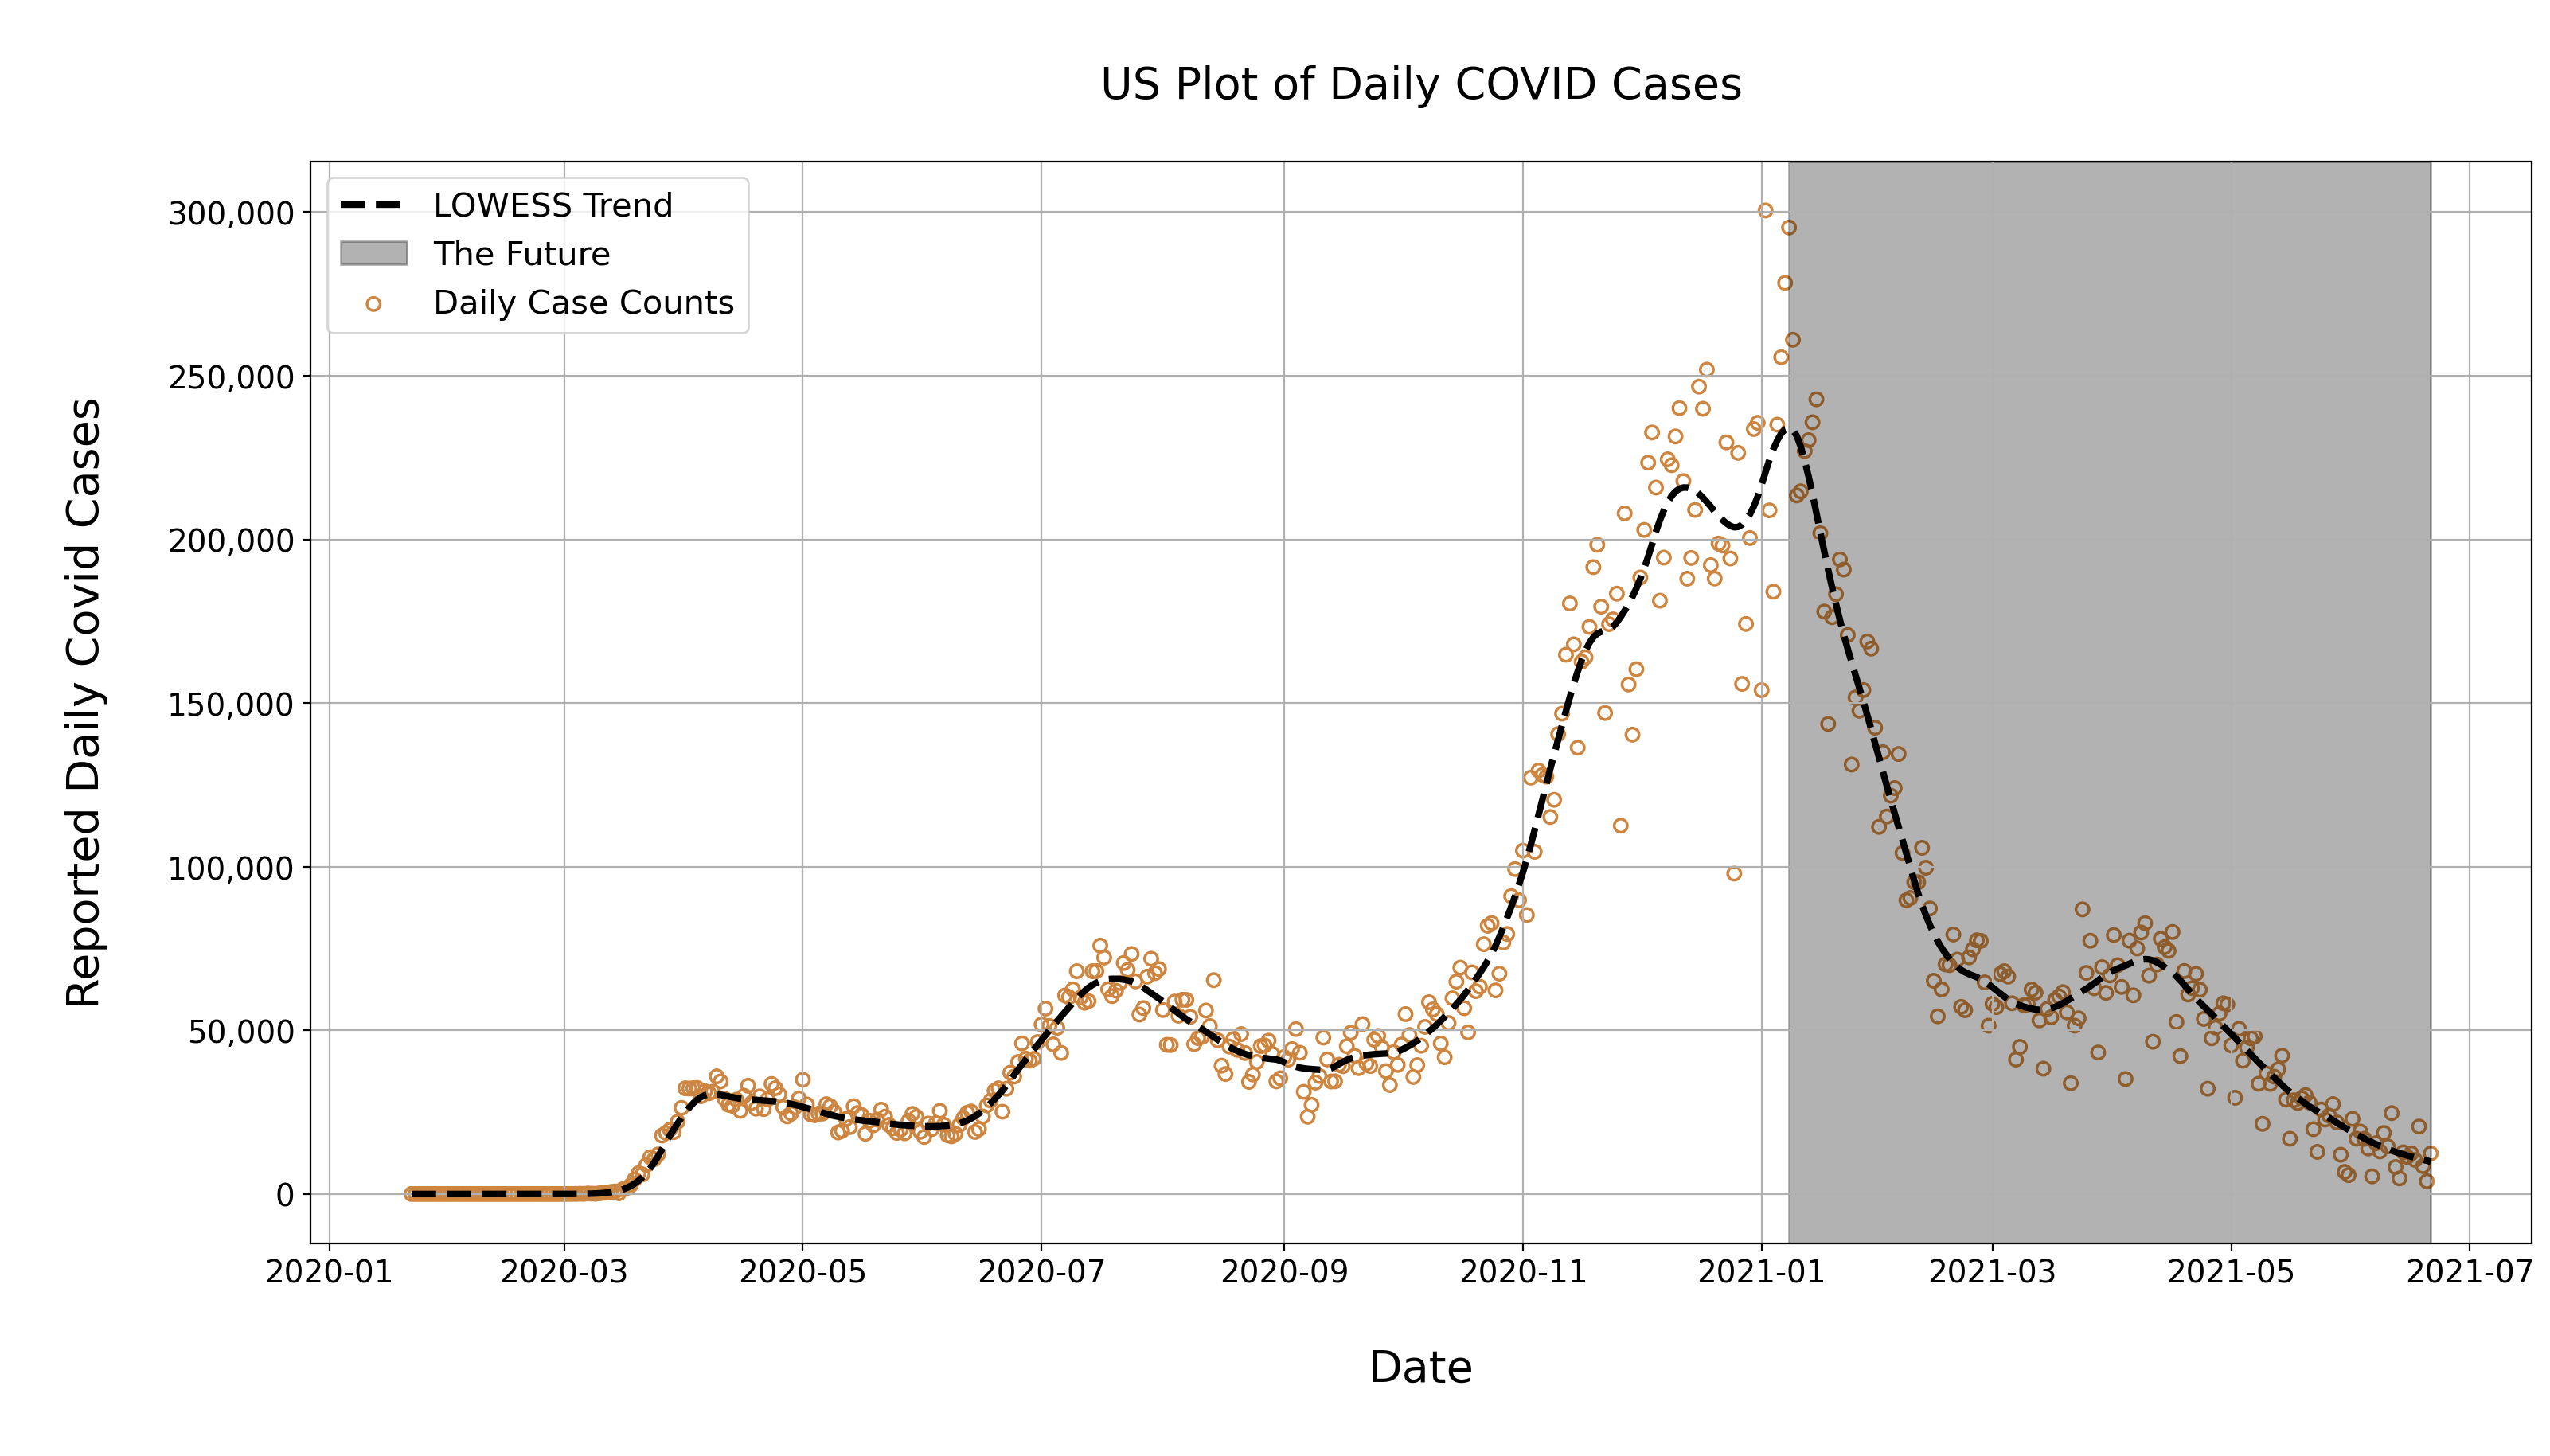

In [12]:
# make the plot of the daily data and smoothed vlaues
plt.style.context('ggplot')
fig, ax = plt.subplots(figsize = (18,9), dpi = 200)

fmt = '{x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
ax.tick_params(axis='y', labelsize = 14)
ax.tick_params(axis='x', labelsize = 14)

ax.set_title('\n{} Plot of Daily COVID Cases\n'.format(COUNTRY_NAME), fontsize = 20)
ax.set_xlabel('\nDate\n', fontsize = 20)
ax.set_ylabel('\nReported Daily Covid Cases\n', fontsize = 20)

ax.axvspan(END_DATE, max(data.date), alpha=0.3, color='black', label = 'The Future')

ax.scatter(data.date, data.y, facecolors='none', edgecolors='peru', linewidth = 1.25, s = 35, label = 'Daily Case Counts')
ax.plot(data.date, data.lowess, linestyle = '--', color = 'black', linewidth = 3 ,label = 'LOWESS Trend')
ax.grid(which = 'major')
plt.legend(loc = 2, fontsize = 15)
plt.show()

## Residuals of the Trend

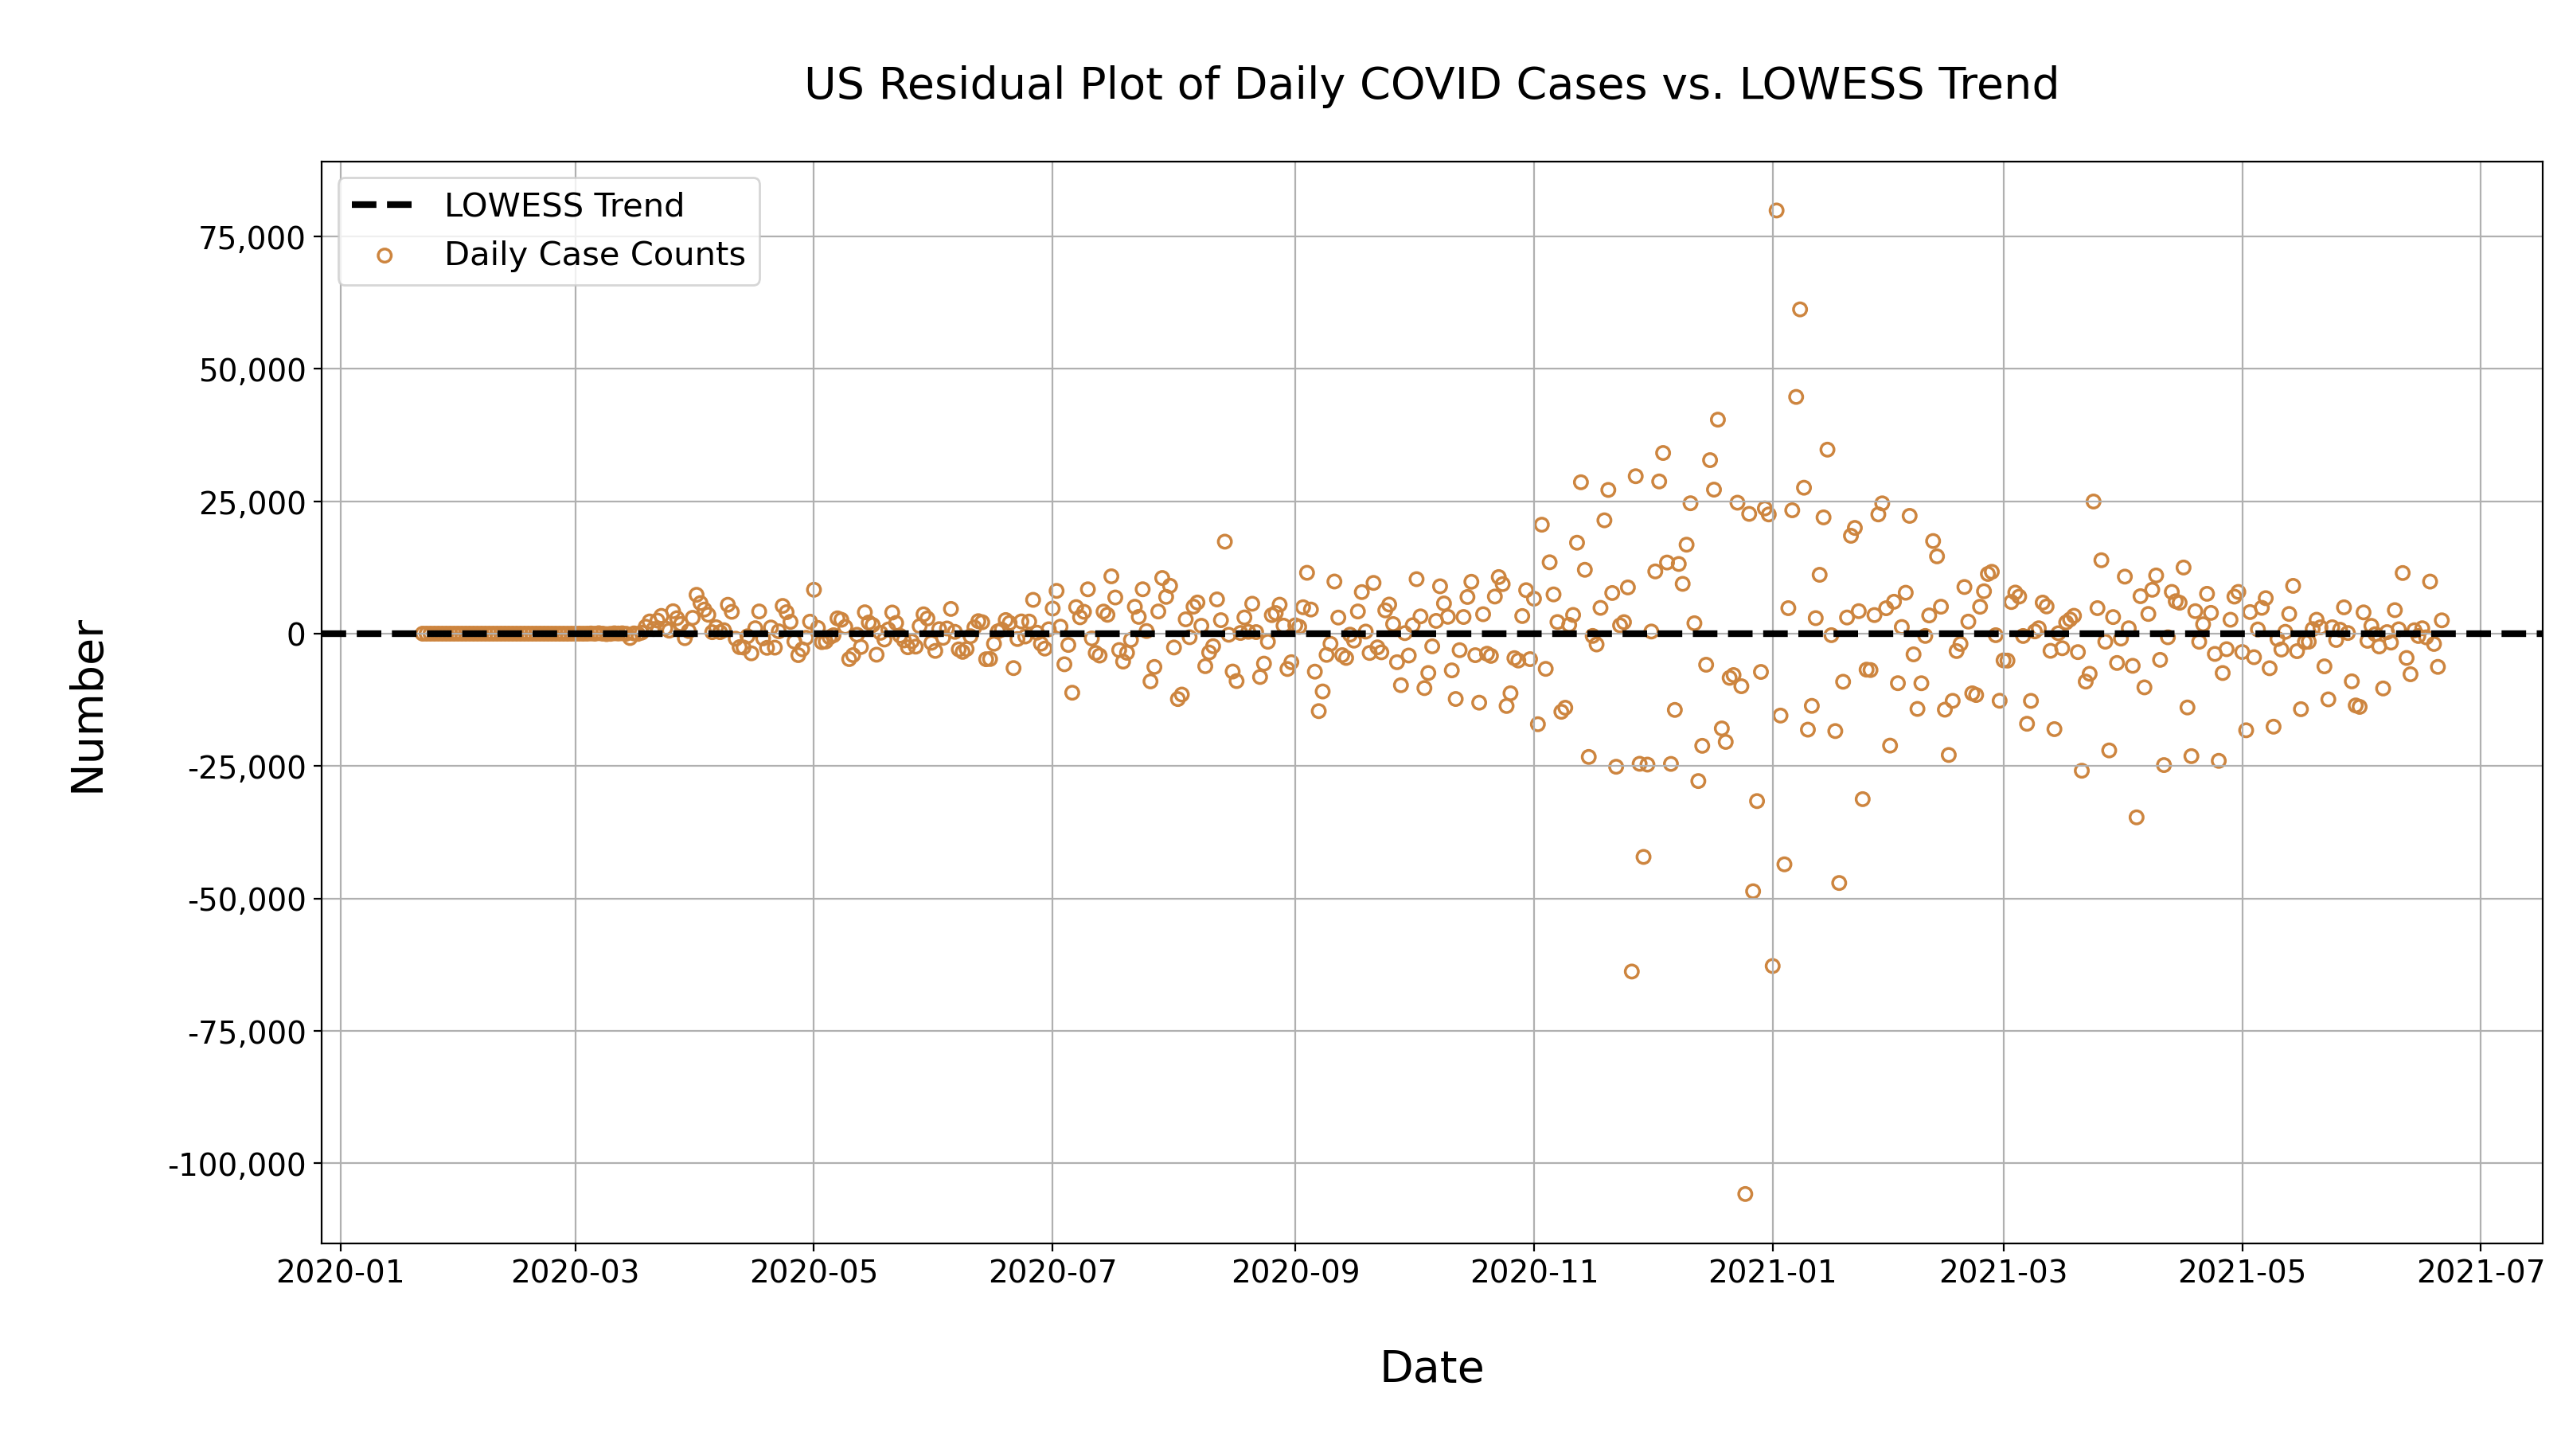

In [13]:
# calculate the residuals
residuals = data.y.values - data.lowess .values

# make the plot
plt.style.context('ggplot')
fig, ax = plt.subplots(figsize = (18,9), dpi = 200)

fmt = '{x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
ax.tick_params(axis='y', labelsize = 14)
ax.tick_params(axis='x', labelsize = 14)

ax.set_title('\n{} Residual Plot of Daily COVID Cases vs. LOWESS Trend\n'.format(COUNTRY_NAME), fontsize = 20)
ax.set_xlabel('\nDate\n', fontsize = 20)
ax.set_ylabel('\nNumber\n', fontsize = 20)

ax.scatter(data.date, residuals, facecolors='none', edgecolors='peru', linewidth = 1.25, s = 35, label = 'Daily Case Counts')
ax.axhline(y=0, linestyle = '--', color = 'black', linewidth = 3 ,label = 'LOWESS Trend')
ax.grid(which = 'major')
plt.legend(loc = 2, fontsize = 15)
plt.show()

## Weekly Trends

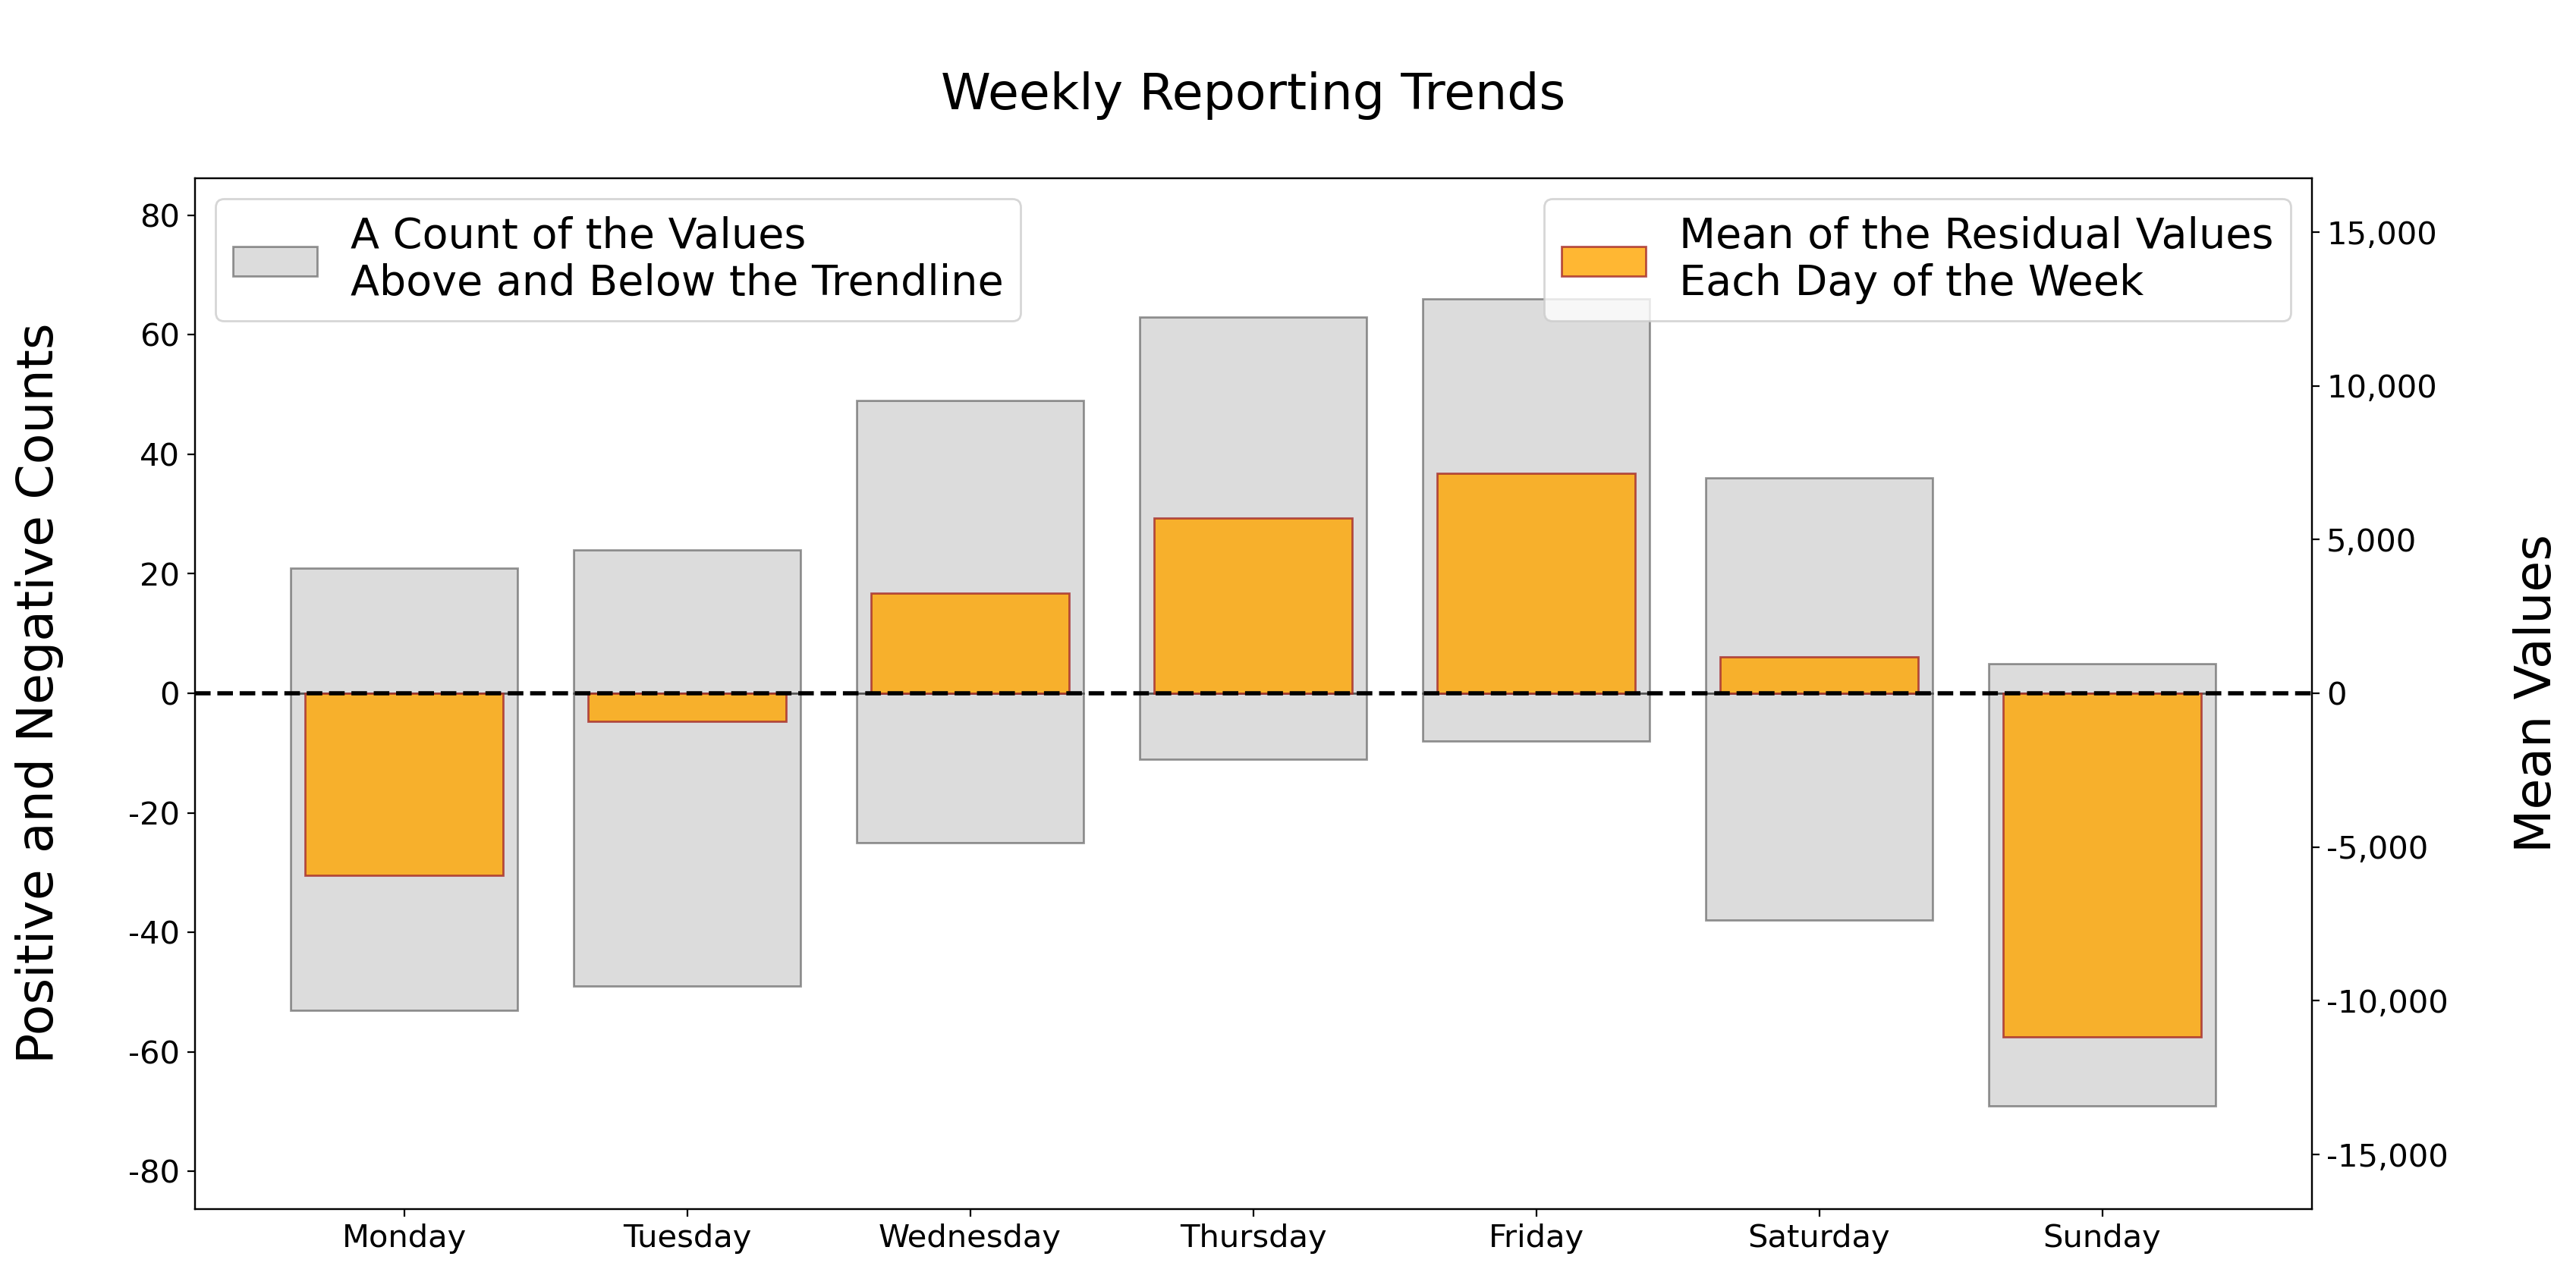

In [14]:
# set up the dataframe
data['lowess_residuals'] = data.y.values - data.lowess.values
data['weekdays'] = data.date.dt.day_name()
df = pd.DataFrame({
        'date':data.date,
        'days':data.weekdays,
        'lowess_residuals':data.lowess_residuals
    }).set_index('date')

# group by day and give the mean, min, and max
df = pd.DataFrame(
    df.groupby('days').agg({'lowess_residuals': 'mean'}),  
    index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

df['positive_count'] = data[data['lowess_residuals'] > 0].groupby('weekdays')['lowess_residuals'].count()
df['negative_count'] = data[data['lowess_residuals'] < 0].groupby('weekdays')['lowess_residuals'].count()
df = df.rename(columns = {'lowess_residuals':'residual_means'})

# make the plot
plt.style.context('ggplot')
fig, ax1 = plt.subplots(figsize = (18,9), dpi = 200)

fmt = '{x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 

ax1.set_title('\nWeekly Reporting Trends\n', fontsize = 24)   
ax1.bar(df.index, df['positive_count'], color = 'darkgrey', edgecolor = 'black', align = 'center', alpha = 0.4, label = 'A Count of the Values\nAbove and Below the Trendline')
ax1.bar(df.index, df['negative_count']*(-1), color = 'darkgrey', edgecolor = 'black', align = 'center', alpha = 0.4)
ax1.set_ylabel('Positive and Negative Counts\n', fontsize = 24)
limit1 = max(max(abs(df['negative_count'])), max(abs(df['positive_count'])))
ax1.set_ylim(-limit1*1.25, limit1*1.25)
ax1.tick_params(labelsize = 15)
ax1.legend(loc=2, fontsize = 20)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.yaxis.set_major_formatter(tick) 
ax2.bar(df.index, df['residual_means'], color = 'orange', width = 0.70, edgecolor = 'brown', align = 'center', alpha = 0.8, label = 'Mean of the Residual Values\nEach Day of the Week')
ax2.axhline(y=0, color = 'black', linestyle = '--', linewidth = 2)
ax2.set_ylabel('\nMean Values', fontsize = 24)
limit2 = max(abs(df['residual_means']))
ax2.set_ylim(-limit2*1.5, limit2*1.5)
ax2.tick_params(labelsize = 15)
ax2.legend(loc=1, fontsize = 20)

plt.show()

## Level Shifts and Change Points

In [15]:
def level_shift_finder(y, window = 1):

    # set initial values
    y = np.array(y)
    x = np.arange(0,len(y))
    level_shifts_ = []  #list to record level shift values
    slopes_ = []
    
    for n in range(len(x)-1):
        slope = (y[n+window]-y[n])/(x[n+window]+x[n])
        slopes_.append(slope)

        if (
            (slopes_[n] < 0 and slopes_[n-1] >= 0) 
            or (slopes_[n] >= 0 and slopes_[n-1] < 0)
        ):

            level_shifts_.append(n)
            
    return level_shifts_

In [16]:
# get the data back to normal 
data = data.drop(columns = ['lowess_residuals','weekdays'])

In [17]:
# establish y vals
y =data.lowess

# calculate the changepoints
level_shifts_ = level_shift_finder(y)

# get the corresponding level shift dates
ls_dates_ = []

for i in level_shifts_:
    ls_dates_.append(data.date[i])


In [18]:
print(ls_dates_)

[Timestamp('2020-02-01 00:00:00'), Timestamp('2020-02-12 00:00:00'), Timestamp('2020-04-08 00:00:00'), Timestamp('2020-06-03 00:00:00'), Timestamp('2020-07-19 00:00:00'), Timestamp('2020-09-11 00:00:00'), Timestamp('2020-12-12 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-01-08 00:00:00'), Timestamp('2021-03-13 00:00:00'), Timestamp('2021-04-09 00:00:00')]


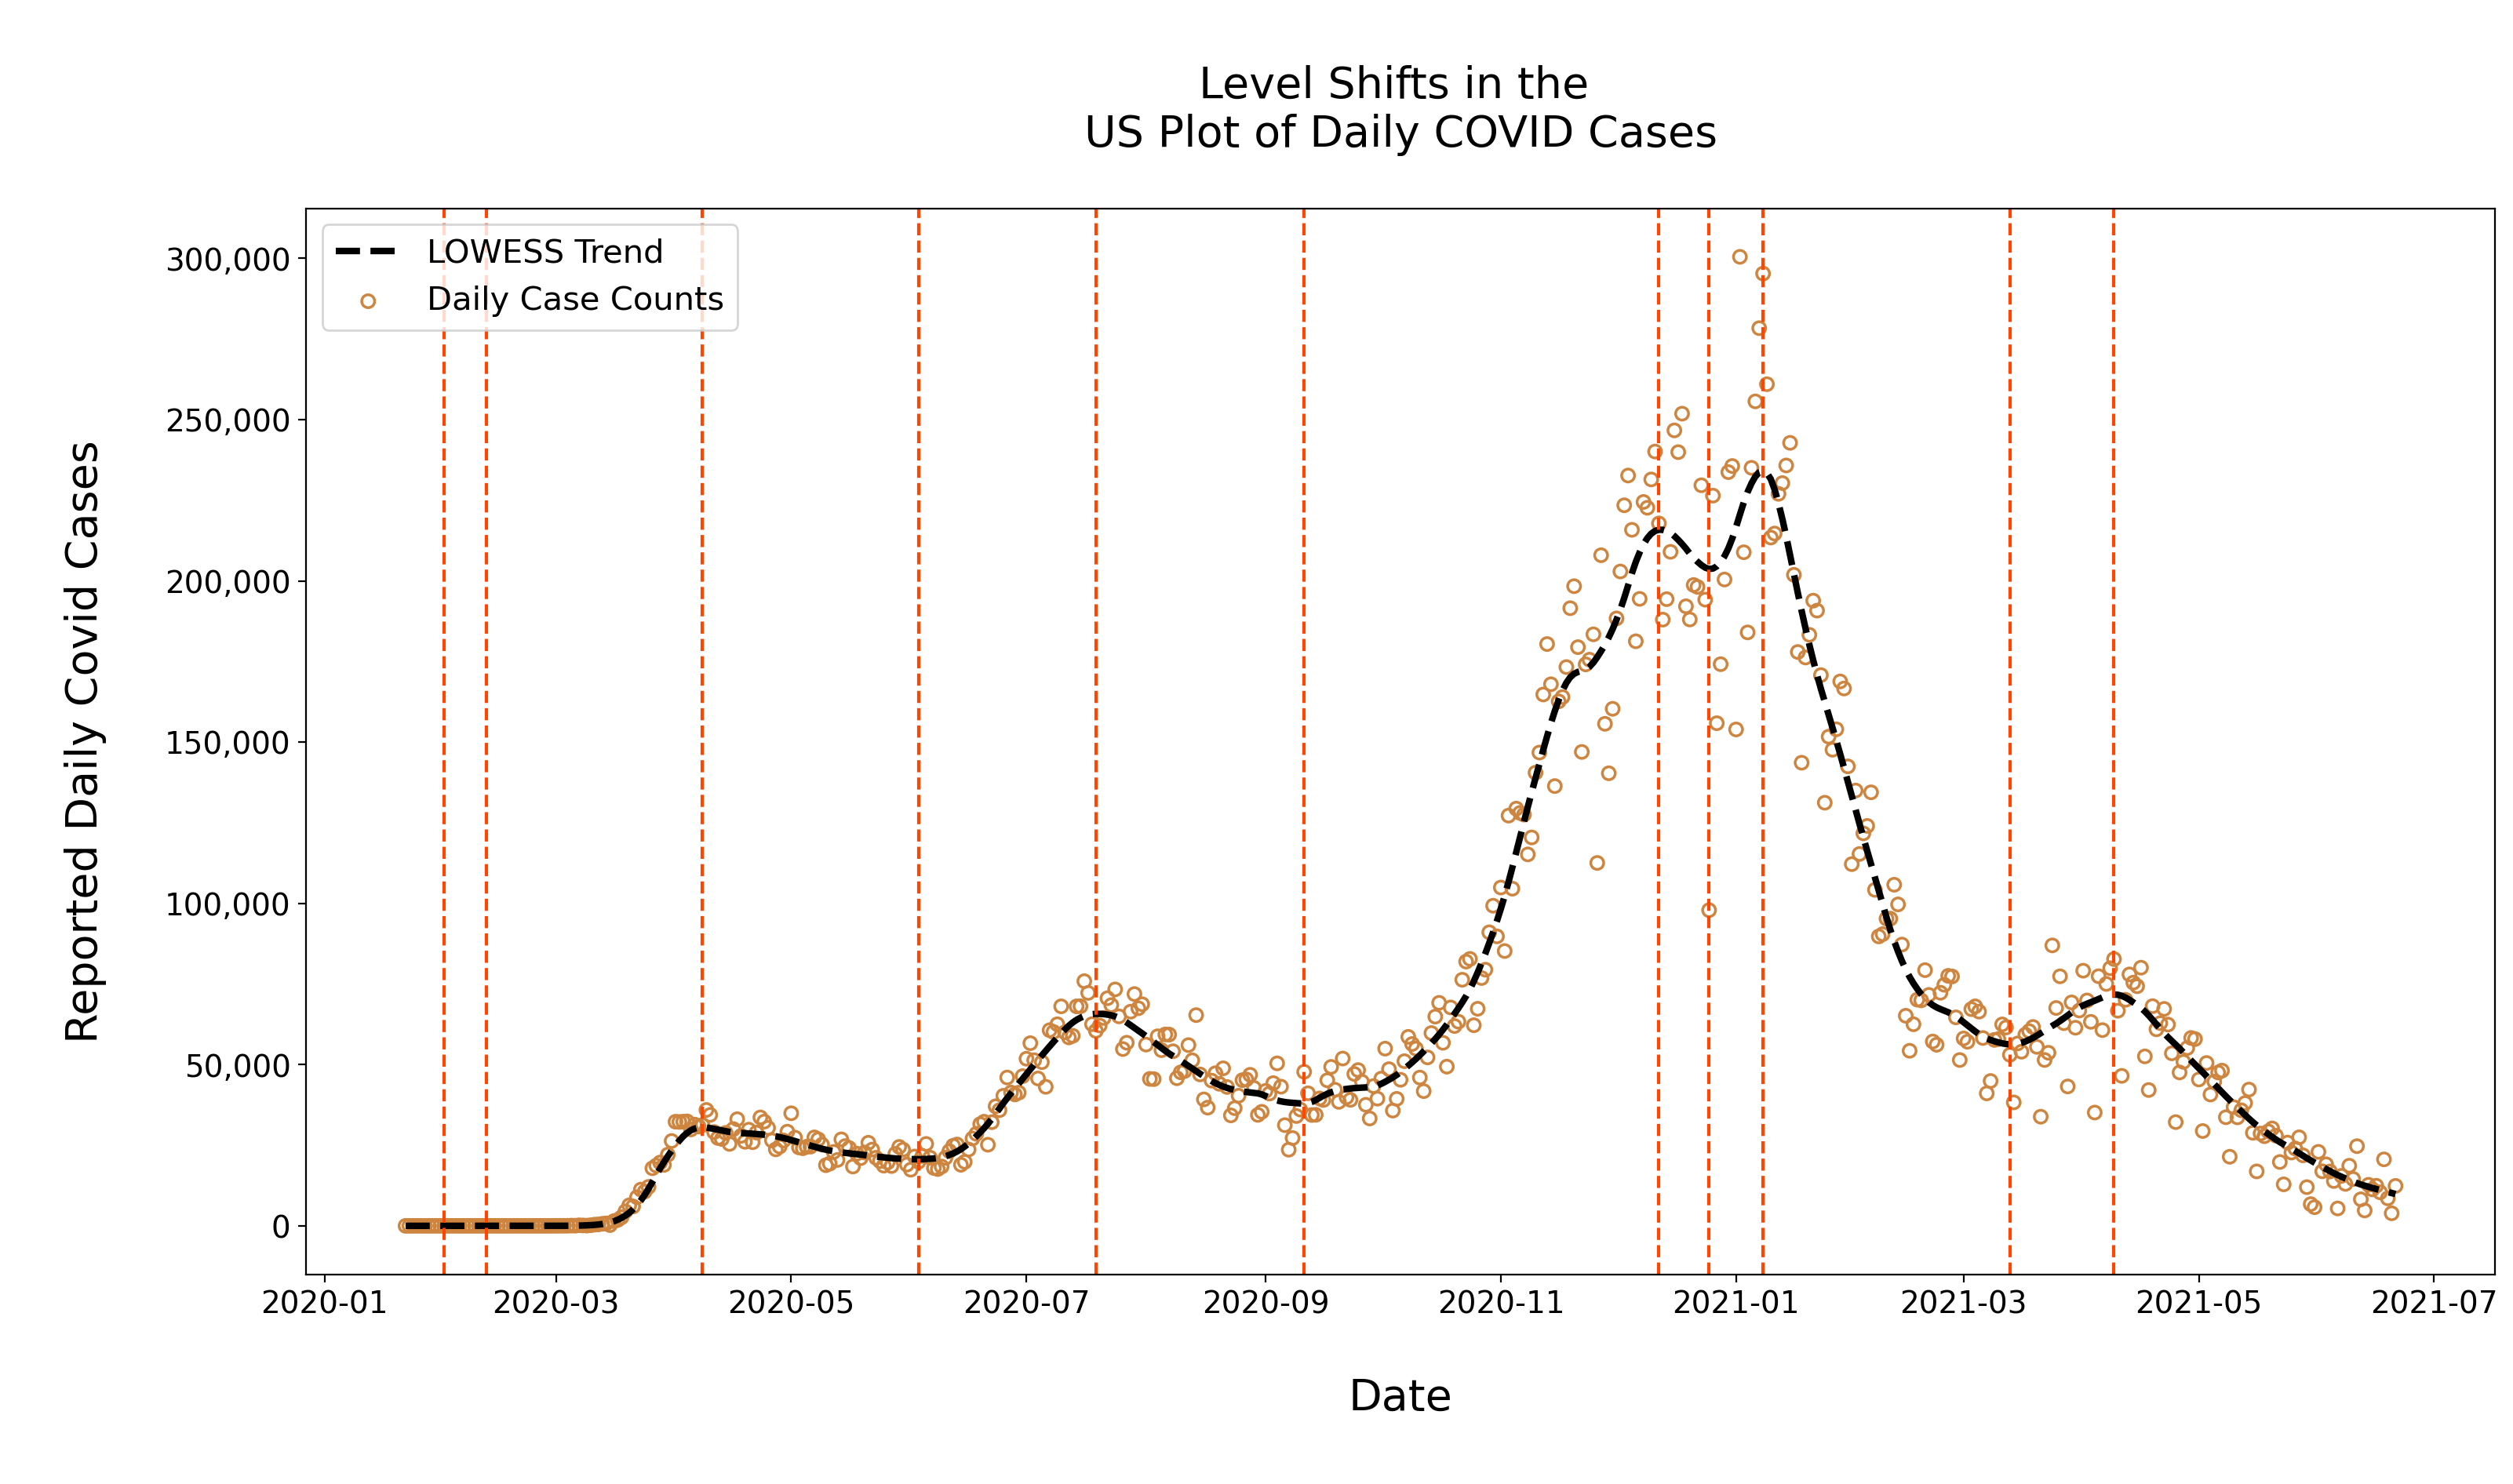

In [19]:
# make the plot of the daily data and smoothed vlaues
plt.style.context('ggplot')
fig, ax = plt.subplots(figsize = (18,9), dpi = 200)

fmt = '{x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
ax.tick_params(axis='y', labelsize = 14)
ax.tick_params(axis='x', labelsize = 14)

ax.set_title('\nLevel Shifts in the \n{} Plot of Daily COVID Cases\n'.format(COUNTRY_NAME), fontsize = 20)
ax.set_xlabel('\nDate\n', fontsize = 20)
ax.set_ylabel('\nReported Daily Covid Cases\n', fontsize = 20)

ax.scatter(data.date, data.y, facecolors='none', edgecolors='peru', linewidth = 1.25, s = 35, label = 'Daily Case Counts')
ax.plot(data.date, data.lowess, linestyle = '--', color = 'black', linewidth = 3 ,label = 'LOWESS Trend')
#ax.grid(which = 'major')

for date in ls_dates_:
    ax.axvline(x = date, color = 'orangered', linestyle = '--')
    
plt.legend(loc = 2, fontsize = 15)
plt.show()

# Exogenous Variables

In [20]:
def get_country_trend_data(country):
    
    # read file and see if it needs to be updated
    trend_file_path = f'./trends/{country}.pkl'
    trends = None
    
    if os.path.exists(trend_file_path):

        trends = pd.read_pickle(trend_file_path)
        most_recent_end_date = trends['end_date'].max()   #adjust for pytrends
        days_old = (dt.datetime.now() - most_recent_end_date)/dt.timedelta(days=1)
        
        print(f'{country} trends file is cached and {days_old:,.1f} days old.')
    #print(f'days old{days_old:,.1f}')
    
    if trends is None or days_old > 1:
        
        print('Updating the file with the most recent trends!')
        search_terms_list = get_terms(country)
        trends = get_google_trends(search_terms_list, country)
        trends.to_pickle(f'./trends/{country}.pkl')

    print(f'Length of the trends dataset is {len(trends)} rows/weeks.', )

    return trends

In [21]:
def get_google_trends(search_terms_list, country, timeframe='today 12-m'):

    pytrends = TrendReq(hl='en-US', tz=360, timeout=(10,30),retries=2, backoff_factor=0.2)
    df = pd.DataFrame()
    
    #obtain proper country code used on Google for the Country Dictionary
    geo = country_dictionary[country]  
    
    for predictor in search_terms_list:
        sleep(10)
        predictor = [predictor]
        
        # There will not be enough data to report all trends. Pass on the trends that return an error. 
        
        try:
            pytrends.build_payload(predictor, timeframe = timeframe, geo = geo) 
            sample = pd.DataFrame(pytrends.interest_over_time()).drop(columns='isPartial')
            
            print(country,predictor, 'Found')
            df = pd.concat([df, sample], axis=1)
            
        except Exception as ex:
            print(predictor, ex)

    # values are displayed weekly - Reindex daily and interpolate values using linear method
    df = df.reset_index().rename(columns = {'date':'begin_date'})
    df['end_date'] = df['begin_date'] + dt.timedelta(days = 6)
    df = df[['begin_date','end_date']+[col for col in df.columns if col not in ['begin_date','end_date']]]
    
    return df

In [22]:
def get_terms(country):
    
    terms_list = []
    for i in country_terms_dict[country]:
        terms_list = terms_list + country_terms_dict[country][i]
        
    return terms_list

In [23]:
def munge_google_trends(google_trends):
    
    # expand datafarme to days from weeks and interpolate missing data 
    munge = google_trends[[col for col in google_trends.columns if col != 'begin_date']]
    munge = munge.set_index('end_date')
    munge = munge.reindex(pd.date_range(start=munge.index.min(),end=munge.index.max(),freq='1D')) 
    munge = munge.interpolate(method='linear') 
    
    return munge

In [24]:
def shift_columns(data, min_shifts, max_shifts):

    """
    Shifts columns from the minimum number of shifts to the maximum number of shifts.
    
    """
    data = data.set_index('date')
    display(data.head(10))
    df = pd.DataFrame(index=data.index)
    
    for col in data.columns:

        for shift_num in range(min_shifts, max_shifts+1):
            
            col_name = col+f'_shift_{shift_num}'
            df[col_name] = data[col].shift(periods = shift_num) 

    return df

In [25]:
def extrapolate_data(munge, forecast_length, smooth = True):
    
    if smooth == True:
        
        # smooth out the data
        for col in munge.columns:
            series = munge[col]
            munge[col] = smooth_lowess(series)

    # create a forecast dataframe to extrapolate the length of the forecast
    forecast_length = 15
    min_date = munge.index.max() + dt.timedelta(days = 1)
    max_date = (dt.datetime.now() - dt.timedelta(days = 1)) + dt.timedelta(days = forecast_length)
    extrapolated_df = pd.DataFrame(pd.date_range(start=min_date,end=max_date,freq='1D'))
    extrapolation_time = ((max_date - min_date).days + 1) 

    # forecast each value out to the forecast date
    for col in munge.columns:
        series = munge[col]
        forecast = holt_winters_forecast(series, extrapolation_time)
        extrapolated_df[col] = forecast.values

    # concat dataframes
    extrapolated_df = extrapolated_df.rename(columns = {0:''})
    extrapolated_df = extrapolated_df.set_index('')

    return extrapolated_df

In [26]:
def holt_winters_forecast(series, extrapolation_time, coerce_series = True):
    
    """
    replace zeros with 0.001, negative values
    holt winters forecast
    
    """
    
    # remove zeros, negative valus
    if coerce_series: 
        series = series.fillna(0)
        series = series.abs()
        series = series.replace(to_replace = {0:0.001})
    
    fit = Holt(series,exponential=True).fit()
    
    #fit = ExponentialSmoothing(series).fit()
    forecast = fit.forecast(extrapolation_time)
    
    return forecast

In [27]:
country_dictionary = {'United States' : 'US',
                      'US':'US', 
                      'United Kingdom' : 'GB', 
                      'UK':'GB', 
                      'GB':'GB', 
                      'India':'IN',
                      'IN':'IN',
                      'Australia':'AU',
                      'AU':'AU',
                     }


english_terms = ['loss of taste','loss of smell','covid test']

country_terms_dict = {
    'US':{1:english_terms}, 
    'United Kingdom':{1:english_terms},
    'India':{1:english_terms},
    'Australia':{1:english_terms},
}

## Download exogenous variables from Google Trends 

In [28]:
# download original Google Data (weekly data)
google_trends = get_country_trend_data(COUNTRY_NAME)

# max data in Google Trends
max_trend_date = google_trends['end_date'].max()

# munge and extrapolate the Google trend data so it converts from weekly to daily.
X = munge_google_trends(google_trends)

# print('---------------------------------')
# print('MUNGE')
# print('---------------------------------')
# display(munge)

#extrapolated = extrapolate_data(munge, FORECAST_LENGTH)
# print('---------------------------------')
# print('EXTRAPOLATED')
# print('---------------------------------')
# display(extrapolated)

#combined = pd.concat([munge, extrapolated])    
# print('---------------------------------')
# print('COMBINED')
# print('---------------------------------')
#display(combined)


US trends file is cached and 3.0 days old.
Updating the file with the most recent trends!
US ['loss of taste'] Found
US ['loss of smell'] Found
US ['covid test'] Found
Length of the trends dataset is 51 rows/weeks.


## Plot the Exogenous vs. COVID-19 Daily Trends

In [29]:
# smooth the exogenous
X_trend = X.copy()

# smooth out the data
for col in X.columns:
    series = X[col]
    X_trend[col] = smooth_lowess(series)

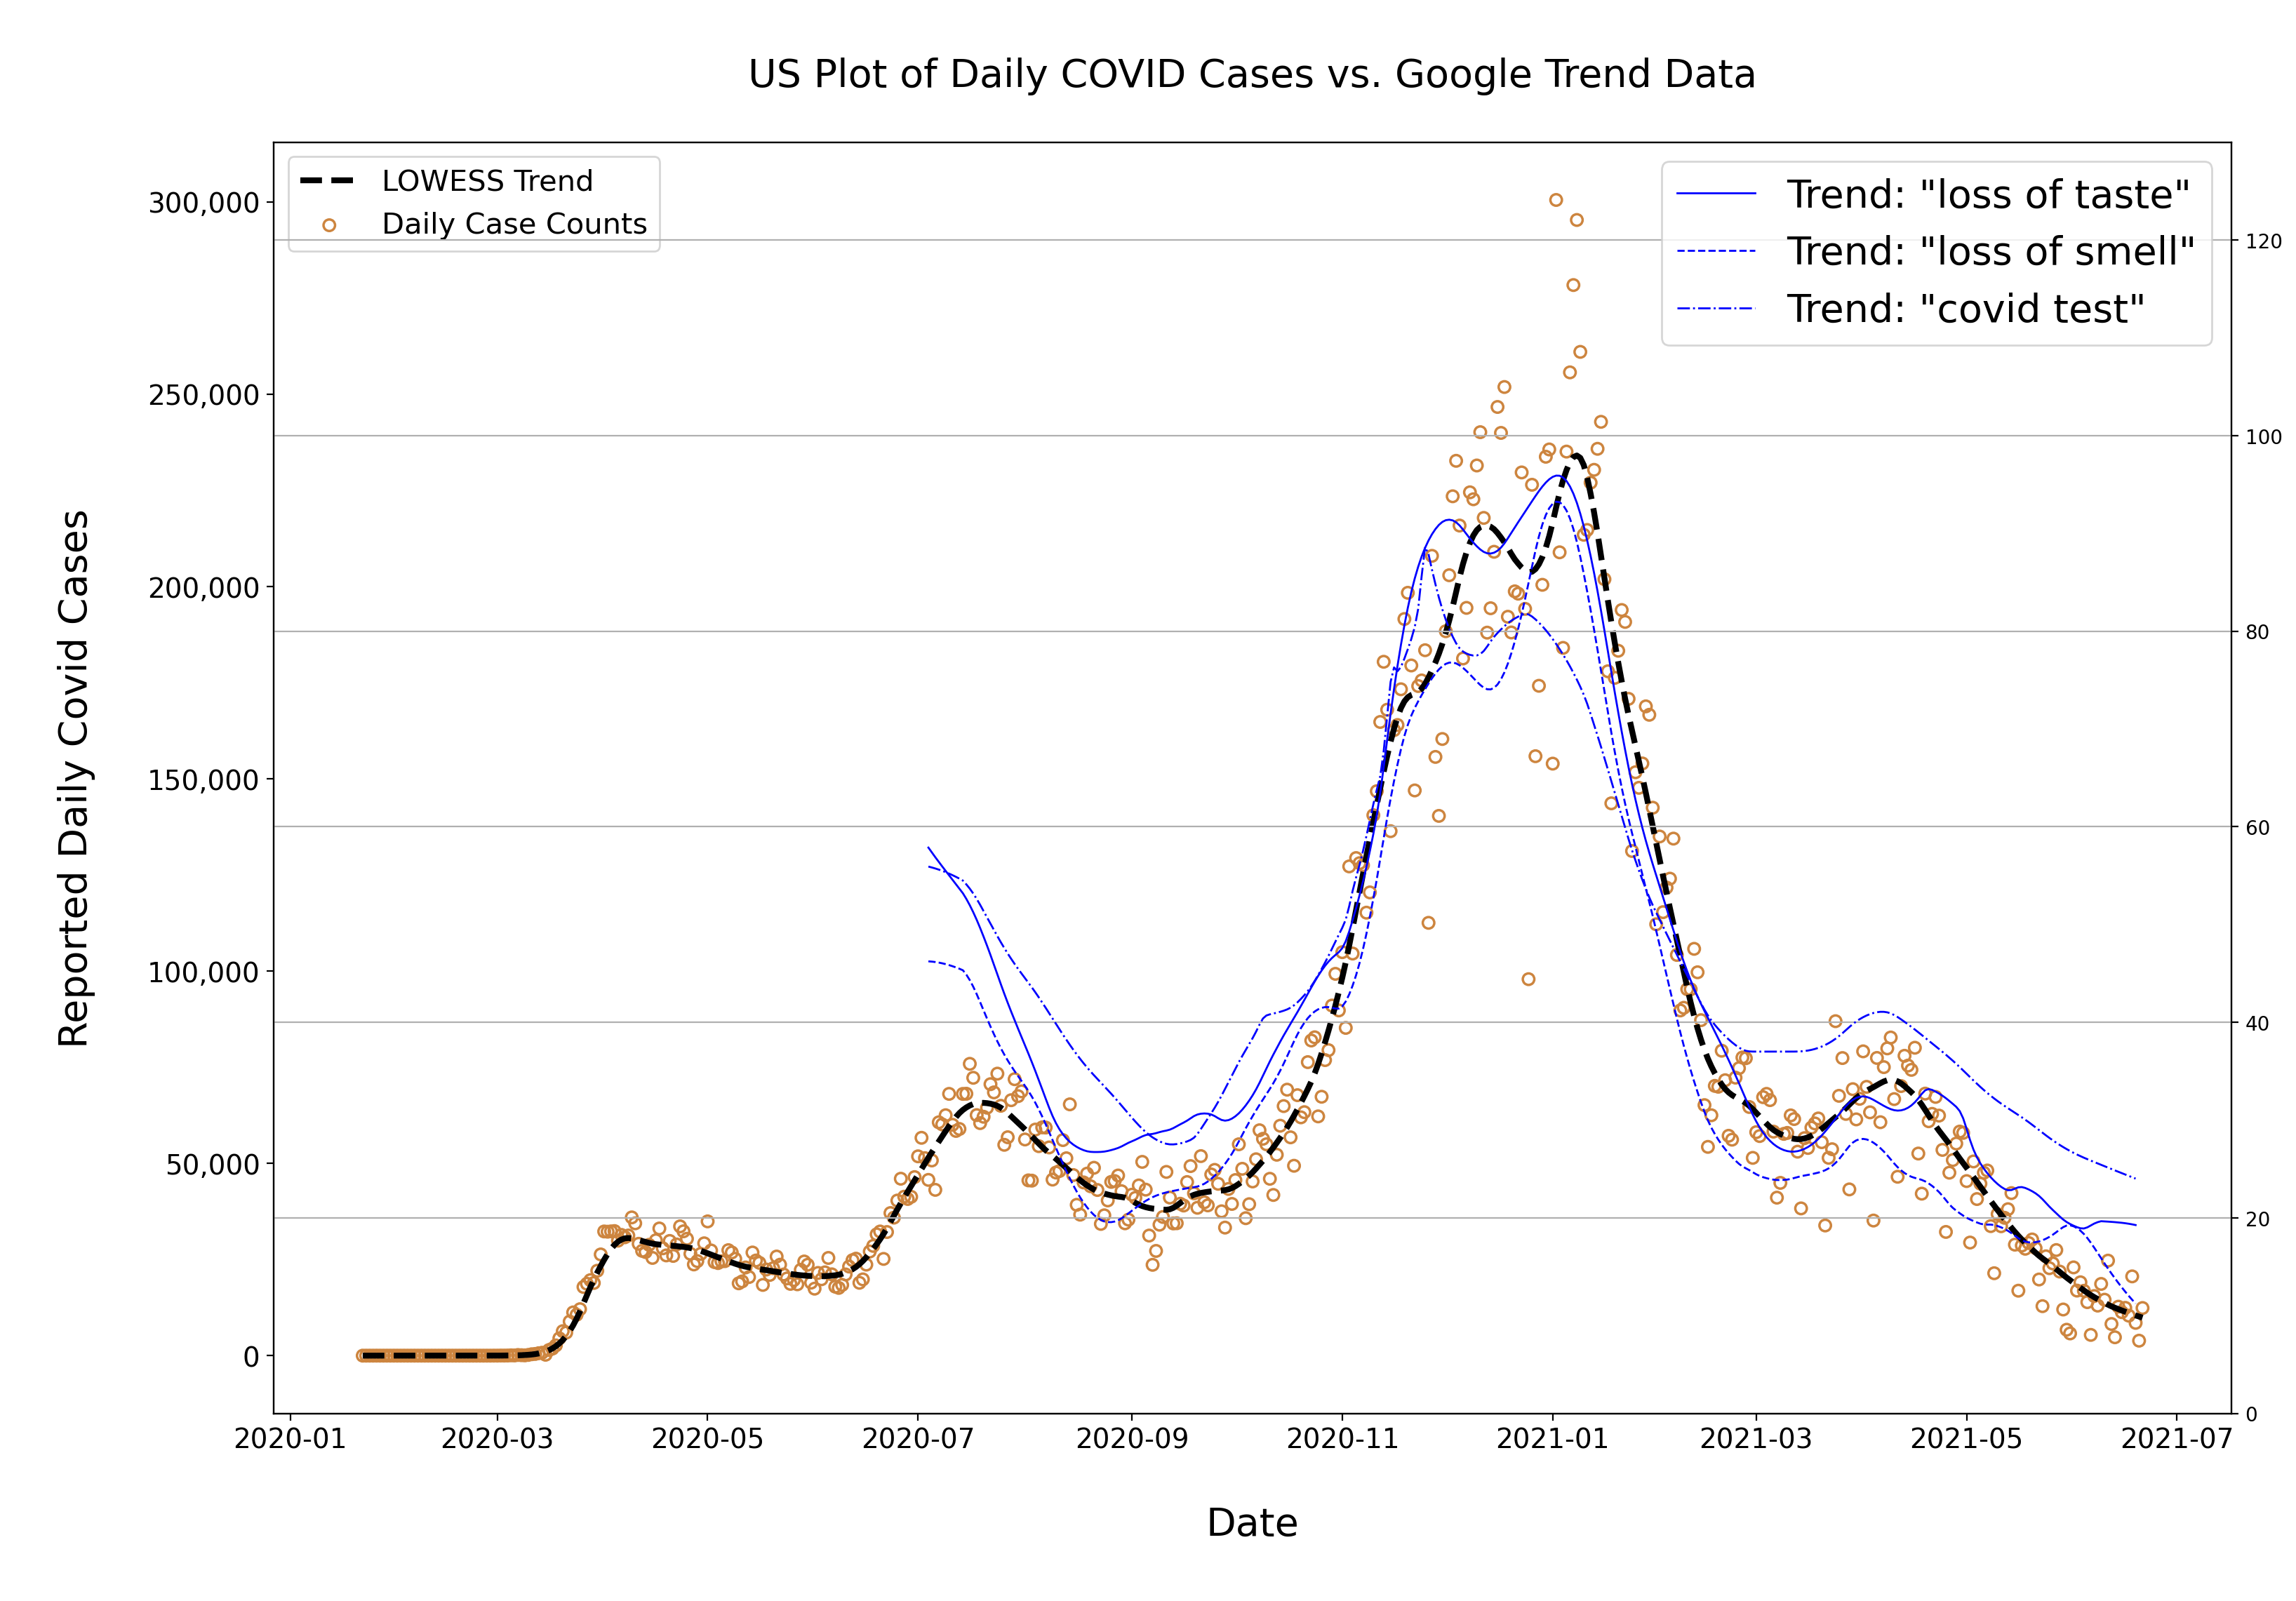

In [30]:
# make the plot of the daily data and smoothed vlaues
plt.style.context('ggplot')
fig, ax1 = plt.subplots(figsize = (18,12), dpi = 200)

fmt = '{x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 
ax1.tick_params(axis='y', labelsize = 14)
ax1.tick_params(axis='x', labelsize = 14)

ax1.set_title('\n{} Plot of Daily COVID Cases vs. Google Trend Data\n'.format(COUNTRY_NAME), fontsize = 20)
ax1.set_xlabel('\nDate\n', fontsize = 20)
ax1.set_ylabel('\nReported Daily Covid Cases\n', fontsize = 20)

ax1.scatter(data.date, data.y, facecolors='none', edgecolors='peru', linewidth = 1.25, s = 35, label = 'Daily Case Counts')
ax1.plot(data.date, data.lowess, linestyle = '--', color = 'black', linewidth = 3 ,label = 'LOWESS Trend')
#ax1.grid(which = 'major')
ax1.legend(loc = 2, fontsize = 15)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

linestyle = ['-','--','-.']
for line, col in zip(linestyle, X_trend.columns):
    ax2.plot(X_trend.index, X_trend[col], linestyle = line, color = 'blue', linewidth = 1 ,label = f'Trend: "{col}"')
ax2.yaxis.set_major_formatter(tick) 
ax2.set_ylim(0, 130)
ax2.grid(which = 'major')
ax2.legend(loc=1, fontsize = 20)
plt.show()

# Split the Data into Training and Testing Sets

## See if  we can make a short term forecast past the most recent major hump

In [31]:
df = data.copy().set_index('date')

# establish a training start at the first level shift past the minimal training size.
train_start = [date for date in ls_dates_ if date <= (END_DATE - dt.timedelta(days = (MINIMAL_TRAINING_SET_SIZE+FORECAST_LENGTH)))][-1]

# date to end training
train_end = END_DATE

# date to start forecast
test_start = END_DATE + dt.timedelta(days = 1)

# date to end forecast - located the number of days forecast past the end date
test_end = END_DATE + dt.timedelta(days = FORECAST_LENGTH)

# training slice
train = df[train_start: train_end]
print(len(train))

# test slice 
test = df[test_start: test_end]

120


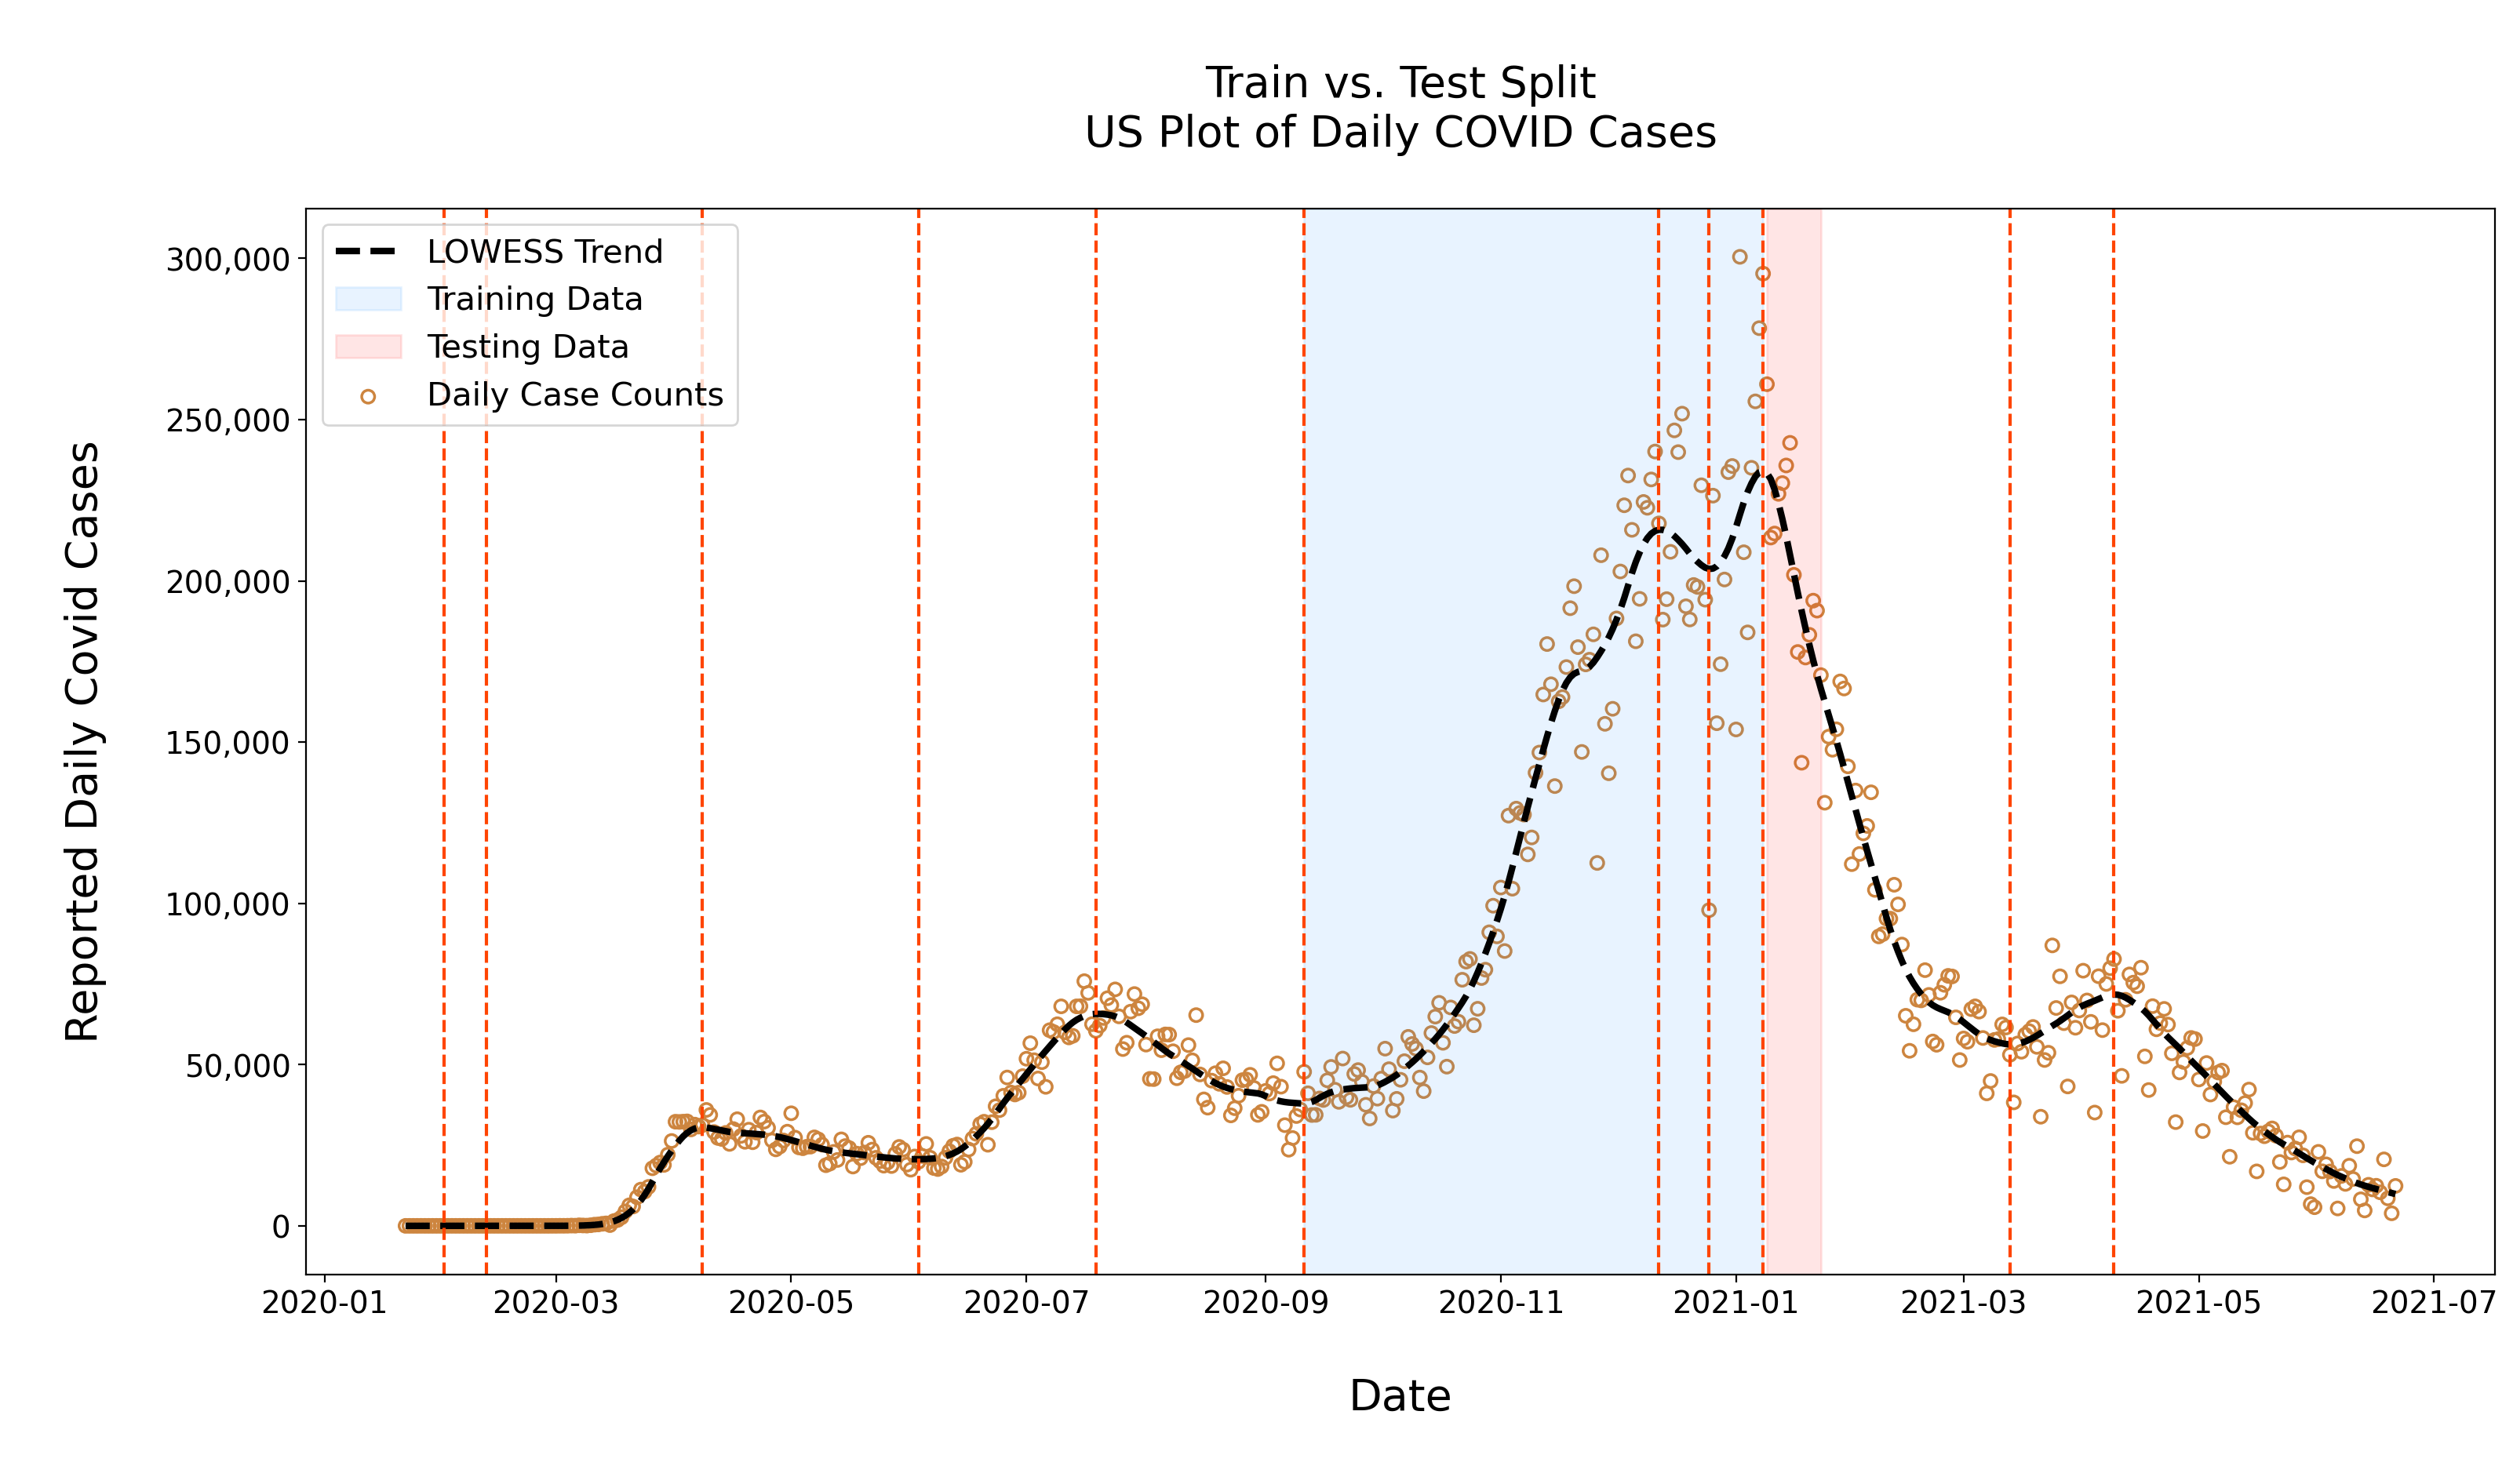

In [32]:
# make the plot of the daily data and smoothed vlaues
plt.style.context('ggplot')
fig, ax = plt.subplots(figsize = (18,9), dpi = 200)

fmt = '{x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
ax.tick_params(axis='y', labelsize = 14)
ax.tick_params(axis='x', labelsize = 14)

ax.set_title('\nTrain vs. Test Split\n{} Plot of Daily COVID Cases\n'.format(COUNTRY_NAME), fontsize = 20)
ax.set_xlabel('\nDate\n', fontsize = 20)
ax.set_ylabel('\nReported Daily Covid Cases\n', fontsize = 20)

ax.scatter(data.date, data.y, facecolors='none', edgecolors='peru', linewidth = 1.25, s = 35, label = 'Daily Case Counts')
ax.plot(data.date, data.lowess, linestyle = '--', color = 'black', linewidth = 3 ,label = 'LOWESS Trend')
ax.axvspan(train_start, train_end, alpha=0.1, color='dodgerblue', label = 'Training Data')
ax.axvspan(test_start, test_end, alpha=0.1, color='red', label = 'Testing Data')

for date in ls_dates_:
    ax.axvline(x = date, color = 'orangered', linestyle = '--')
plt.legend(loc = 2, fontsize = 15)
plt.show()

## Include the exogenous variables

In [33]:
shift_min = 1
shift_max = 15
pval_max = 0.20
vif_max = 10
remove_uncorrelated = True
min_rsquared = 0.5
cut = 0.99
add_intercept=True
screen_pvalues=True
screen_vifs=False
plot_shifts = True

In [34]:
extrapolated = extrapolate_data(X_trend, FORECAST_LENGTH)
combined = pd.concat([X_trend, extrapolated])
exog = combined.copy()
exog = exog.fillna(0)
display(exog)

loss of taste  loss of smell  covid test
2020-07-04      58.163202      46.980182   56.445250
2020-07-05      57.615072      46.748641   56.205356
2020-07-06      57.067452      46.509025   55.960193
2020-07-07      56.520007      46.260960   55.709514
2020-07-08      55.972534      46.004392   55.453287
...                   ...            ...         ...
2021-07-02      19.391630       7.148581   22.297874
2021-07-03      19.386619       6.904457   22.171102
2021-07-04      19.381610       6.668670   22.045050
2021-07-05      19.376601       6.440935   21.919715
2021-07-06      19.371594       6.220978   21.795092

[368 rows x 3 columns]

In [35]:
#TODO: recompute lowess at the training split

X_train = X_trend[train_start : train_end]
y_train = df.lowess[train_start : train_end]

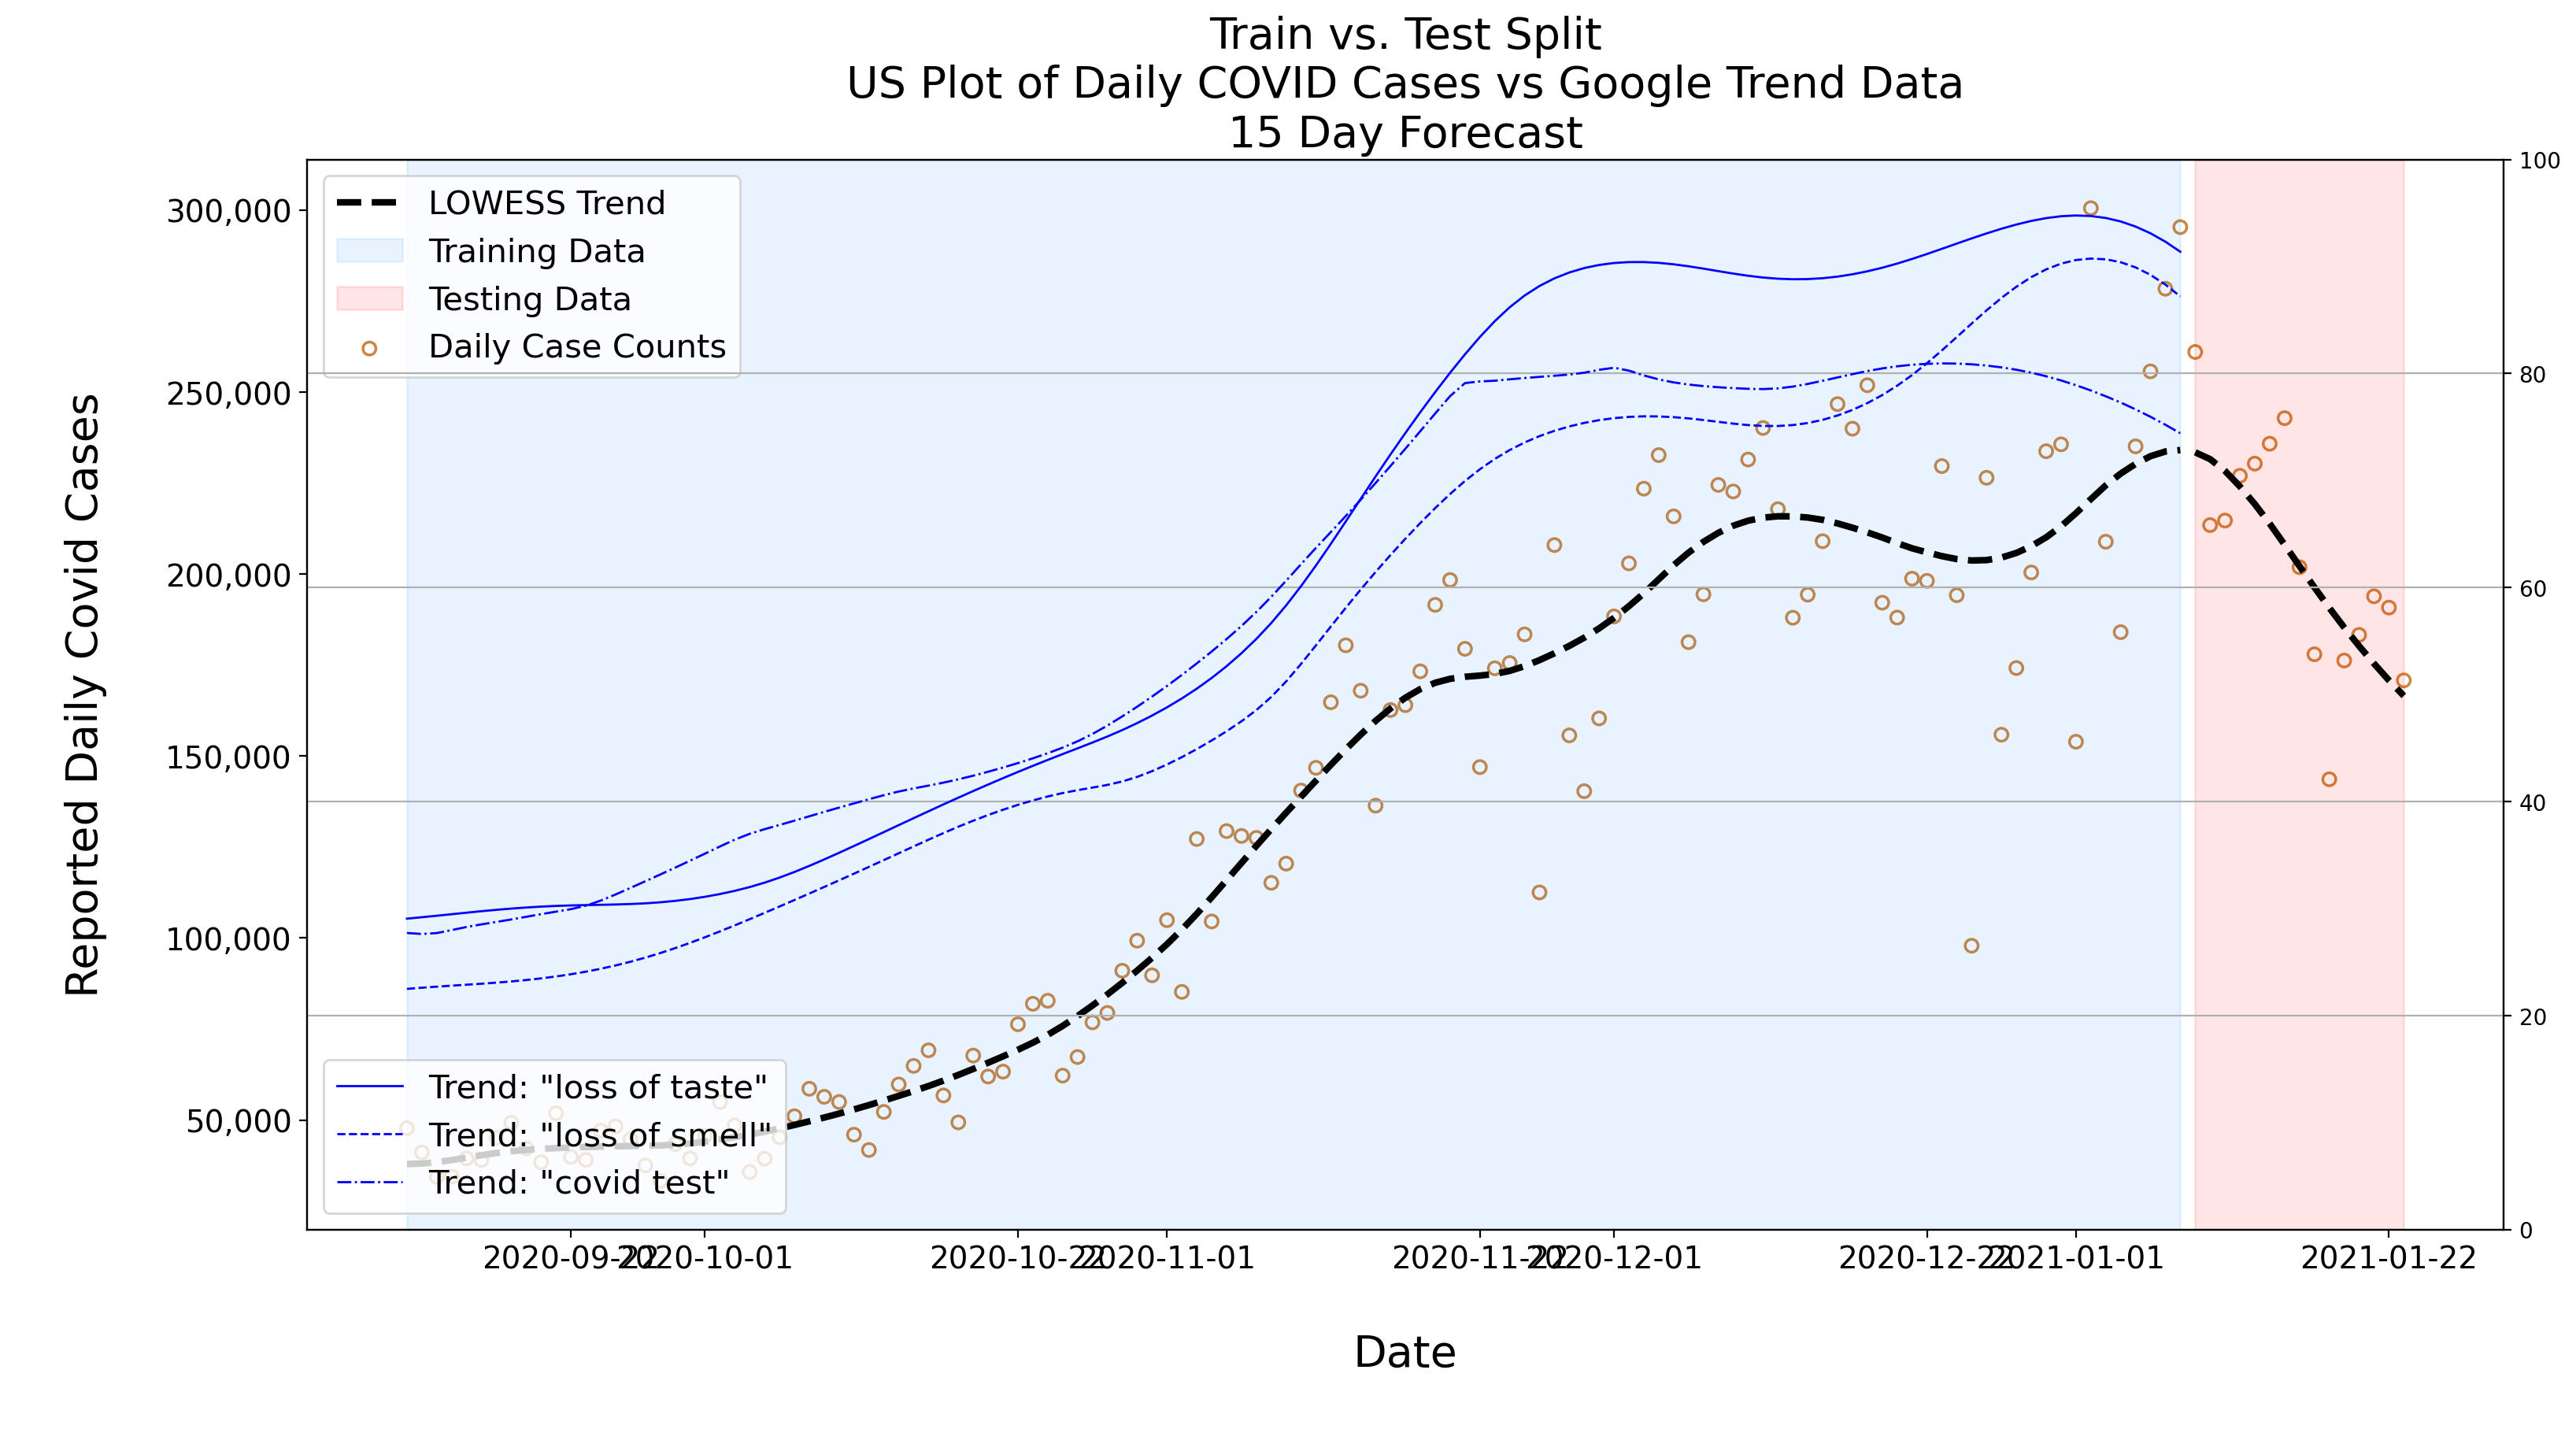

In [36]:
# make the plot of the daily data and smoothed vlaues
plt.style.context('ggplot')
fig, ax1 = plt.subplots(figsize = (18,9), dpi = 200)

fmt = '{x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 
ax1.tick_params(axis='y', labelsize = 14) 
ax1.tick_params(axis='x', labelsize = 14)

ax1.set_title('Train vs. Test Split\n{} Plot of Daily COVID Cases vs Google Trend Data\n{} Day Forecast'.format(COUNTRY_NAME, FORECAST_LENGTH), fontsize = 20)
ax1.set_xlabel('\nDate\n', fontsize = 20)
ax1.set_ylabel('\nReported Daily Covid Cases\n', fontsize = 20)

ax1.scatter(train.index, train.y, facecolors='none', edgecolors='peru', linewidth = 1.25, s = 35, label = 'Daily Case Counts')
ax1.plot(y_train.index, y_train, linestyle = '--', color = 'black', linewidth = 3 ,label = 'LOWESS Trend')
ax1.grid(which = 'major')

ax1.scatter(test.index, test.y, facecolors='none', edgecolors='peru', linewidth = 1.25, s = 35)
ax1.plot(test.index, test.lowess, linestyle = '--', color = 'black', linewidth = 3 )
ax1.grid(which = 'major')

ax1.axvspan(train_start, train_end, alpha=0.1, color='dodgerblue', label = 'Training Data')
ax1.axvspan(test_start, test_end, alpha=0.1, color='red', label = 'Testing Data')
ax1.legend(loc = 2, fontsize = 15)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

linestyle = ['-','--','-.']
for line, col in zip(linestyle, X.columns):
    ax2.plot(X_train.index, X_train[col], linestyle = line, color = 'blue', linewidth = 1 ,label = f'Trend: "{col}"')
ax2.yaxis.set_major_formatter(tick) 
ax2.set_ylim(0, 100)

ax2.legend(loc=3, fontsize = 15)
ax2.grid(which = 'major')
plt.show()

# Make a Transfer Function

## Extrapolate exogenous variables

In [37]:
# build the 15 day holt winters forecast into each time series
X_forecast = pd.DataFrame()

for col in X_train.columns:

    X_forecast[col] = holt_winters_forecast(
        X_train[col], 
        extrapolation_time=FORECAST_LENGTH,
        coerce_series = True
    )

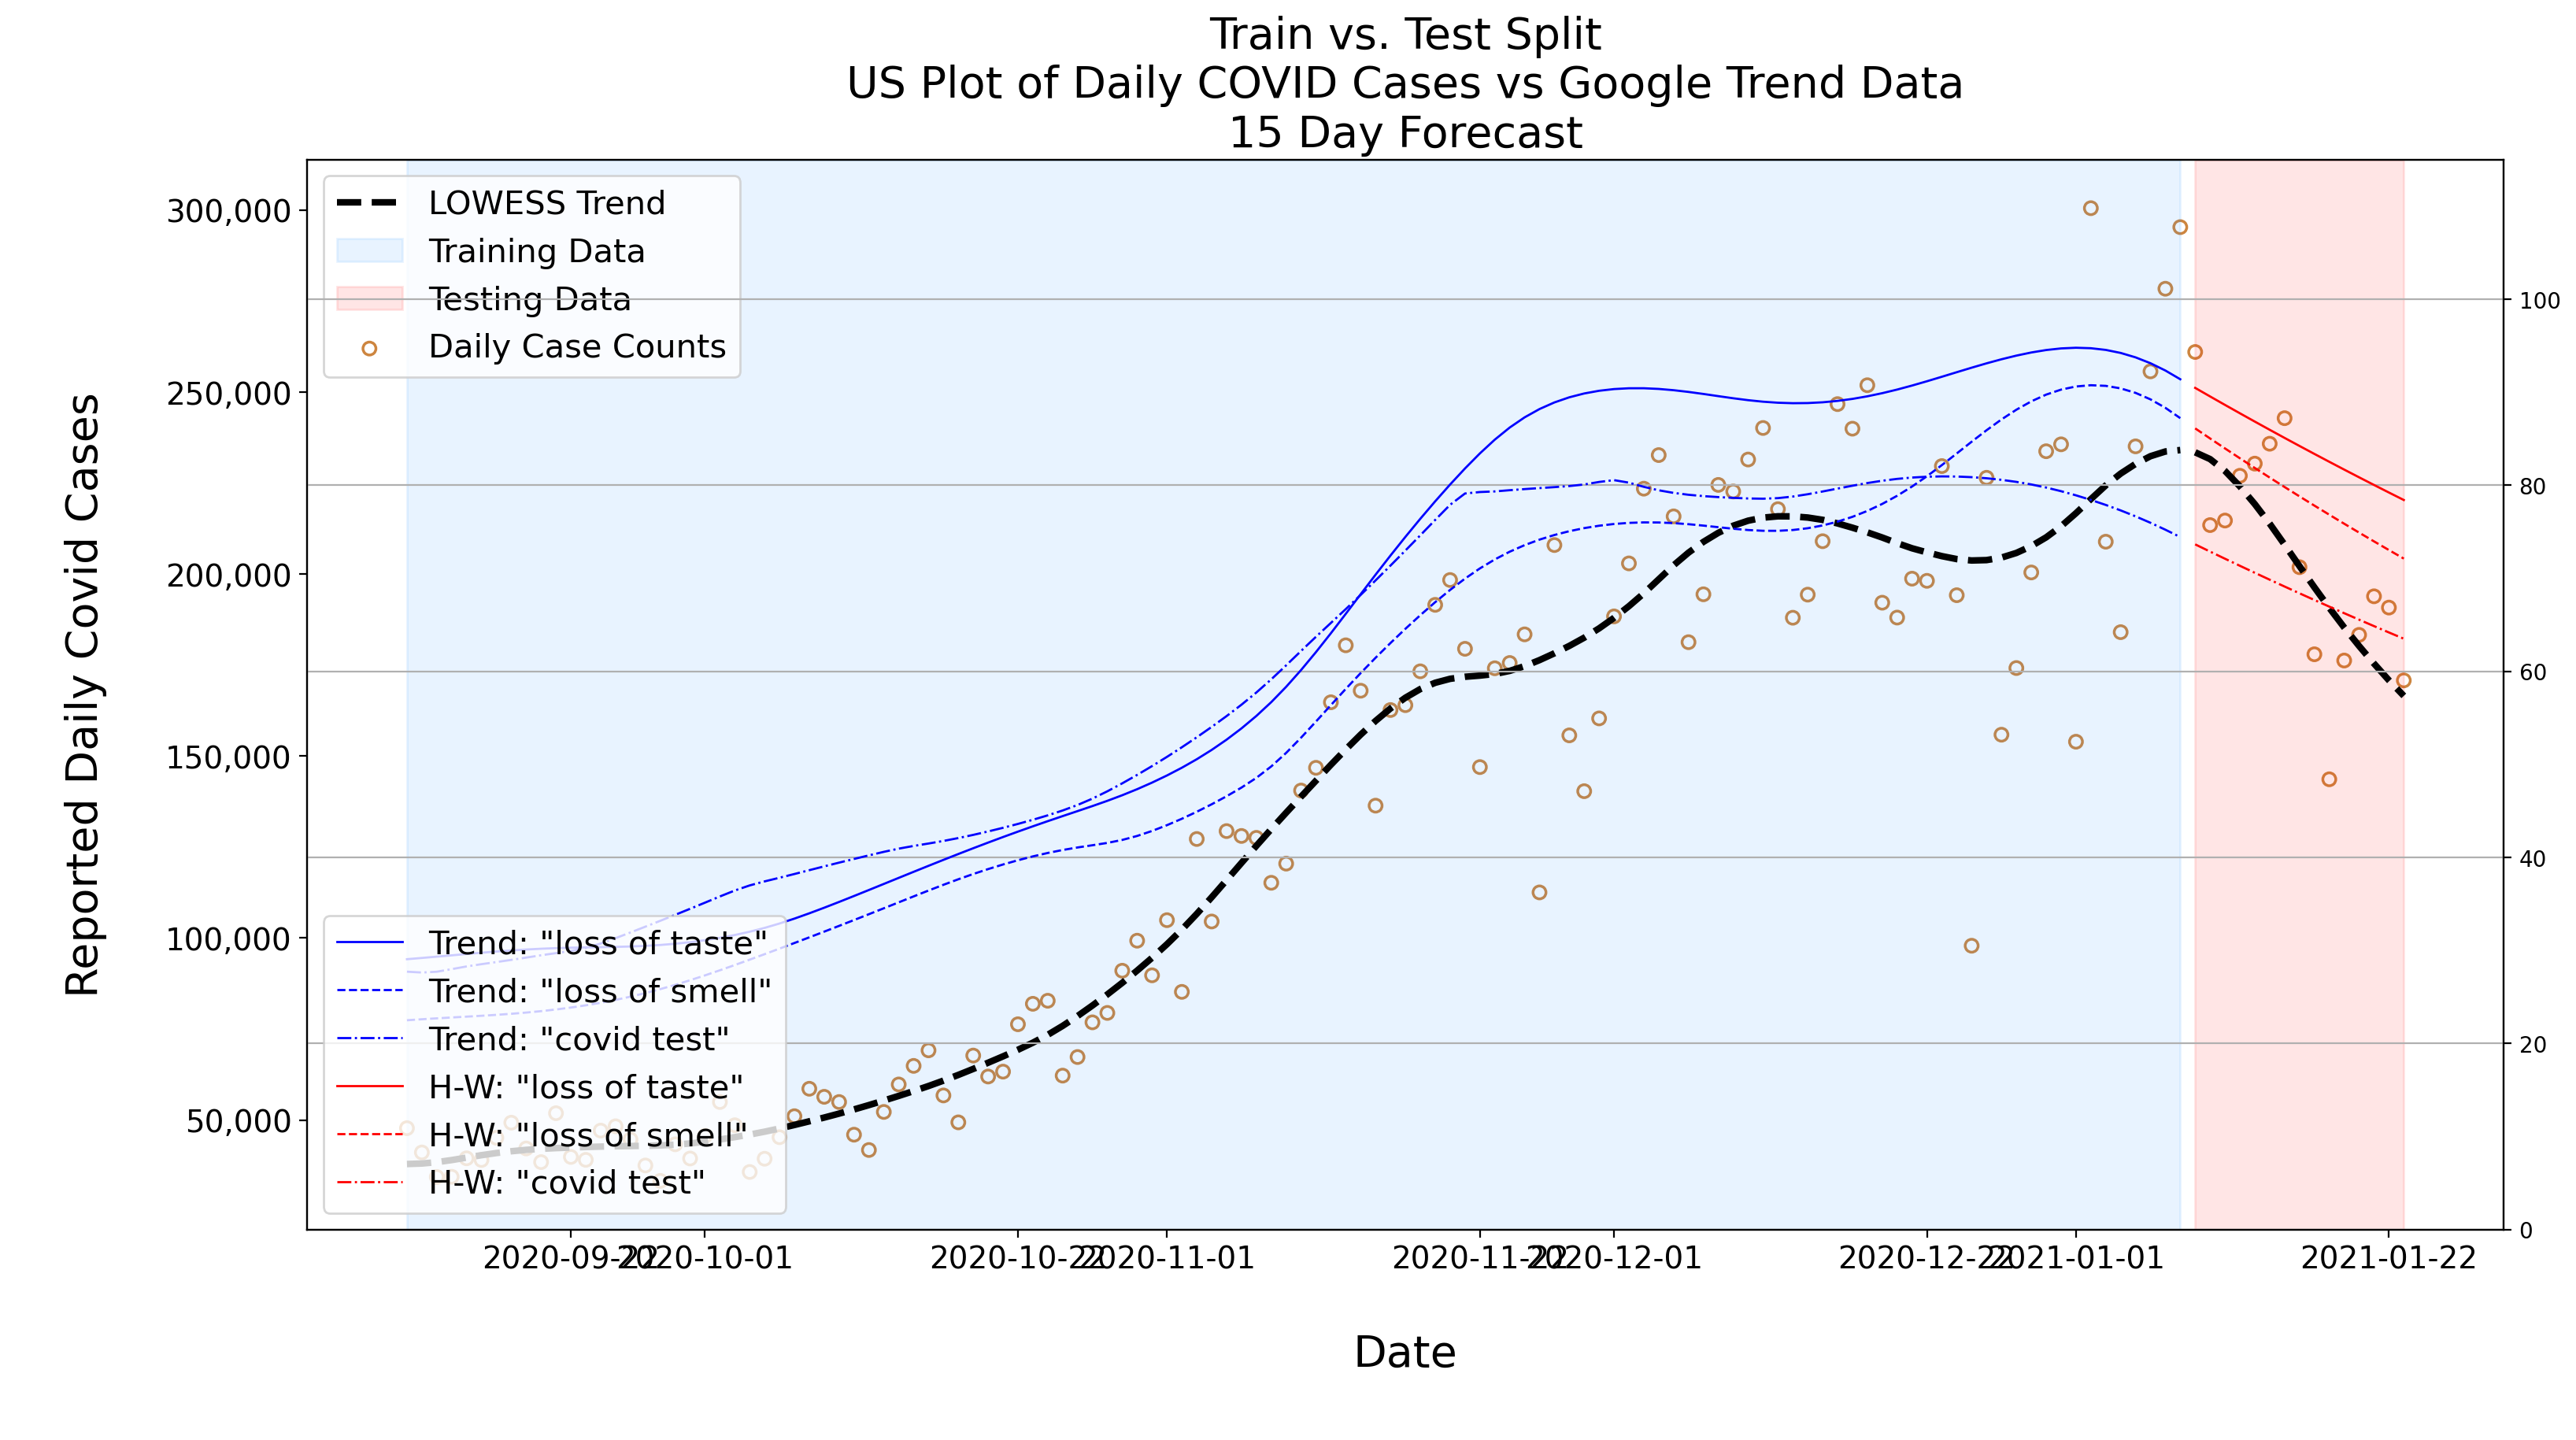

In [38]:
# make the plot of the daily data and smoothed vlaues
plt.style.context('ggplot')
fig, ax1 = plt.subplots(figsize = (18,9), dpi = 200)

fmt = '{x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 
ax1.tick_params(axis='y', labelsize = 14) 
ax1.tick_params(axis='x', labelsize = 14)

ax1.set_title('Train vs. Test Split\n{} Plot of Daily COVID Cases vs Google Trend Data\n{} Day Forecast'.format(COUNTRY_NAME, FORECAST_LENGTH), fontsize = 20)
ax1.set_xlabel('\nDate\n', fontsize = 20)
ax1.set_ylabel('\nReported Daily Covid Cases\n', fontsize = 20)

ax1.scatter(train.index, train.y, facecolors='none', edgecolors='peru', linewidth = 1.25, s = 35, label = 'Daily Case Counts')
ax1.plot(y_train.index, y_train, linestyle = '--', color = 'black', linewidth = 3 ,label = 'LOWESS Trend')
ax1.grid(which = 'major')

ax1.scatter(test.index, test.y, facecolors='none', edgecolors='peru', linewidth = 1.25, s = 35)
ax1.plot(test.index, test.lowess, linestyle = '--', color = 'black', linewidth = 3 )
ax1.grid(which = 'major')

ax1.axvspan(train_start, train_end, alpha=0.1, color='dodgerblue', label = 'Training Data')
ax1.axvspan(test_start, test_end, alpha=0.1, color='red', label = 'Testing Data')
ax1.legend(loc = 2, fontsize = 15)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

linestyle = ['-','--','-.']
for line, col in zip(linestyle, X.columns):
    ax2.plot(X_train.index, X_train[col], linestyle = line, color = 'blue', linewidth = 1 ,label = f'Trend: "{col}"')
ax2.yaxis.set_major_formatter(tick) 

for line, col in zip(linestyle, X_forecast.columns):
    ax2.plot(X_forecast.index, X_forecast[col], linestyle = line, color = 'red', linewidth = 1 ,label = f'H-W: "{col}"')

ax2.yaxis.set_major_formatter(tick) 
ax2.set_ylim(0, 115)

ax2.legend(loc=3, fontsize = 15)
ax2.grid(which = 'major')
plt.show()

## Time Shift the Exogenous Variables

In [39]:
def count_zeroes_from_end(y):
    
    y = np.nan_to_num(y, nan=0.0)    
    c = 0
    
    for i in range(len(y)-1,-1,-1):

        if y[i] == 0:
            c += 1
        else: 
            break
            
    return c

In [40]:
def get_pval_r2(x_array, y_array, constant = True):
#     x_array = np.log1p(x_array)
#     y_array = np.log1p(y_array)
    x_const = sm.add_constant(x_array)
    weights = np.array([np.exp(val) for val in range(1,len(x_array)+1,1)])
    wls_model = sm.WLS(y_array, x_const, w = weights)
    wls_fit = wls_model.fit()
    p_val = wls_fit.pvalues[1]
    r_sqr = wls_fit.rsquared
    
    return p_val, r_sqr

In [41]:
y = y_train
exog = X_train

# convert y/ target variable to a numpy array and replace nan values with zero
y = y.to_numpy()

# ENSURE THERE ARE NO NAN VALUES AT THE HEADS AND TAILS OF THE X AND Y ARRAYS
# count the number of zeros from the end and remove them
#c = count_zeroes_from_end(y)
#y = y[0:-c]

# find the ideal number of shifts and create a shifted_exog Data Frame
# take the first column as the x value to look at and assign it the name 0...............
cols = exog.columns.to_list()
stats = {}
shifted_exog = pd.DataFrame()

In [42]:
# for i in range(0,len(cols)):
    
#     x = pd.DataFrame(exog[cols[i]]).rename(columns = {cols[i]:0})

#     # find scores for each shift
#     shift = {}
#     shifts_ = []
#     mse_record_ = []
    
#     for s in range(shift_min, shift_max+1, 1):

#         # shift and convert values to numpy array    
#         x[s] = x[0].shift(s)

#         # set x an y values the same length with no nan values based on the new shift
#         y_array = y[s:].reshape(-1, 1)
#         x_array = x[s].to_numpy()[s:].reshape(-1, 1)
#         mse = mean_squared_error(x_array, y_array)
        
#         # record shifts
#         shift[s] = {'mse': mse}
#         shifts_.append(int(s))
        
#         # find the shift with the minimum mse
#         mse_record_.append(mse)
#         min_mse = min(mse_record_)
#         shift_min_mse = mse_record_.index(min_mse)
        
#     # select the ideal column
#     shifted_exog[f'{cols[i]}_shift[{shift_min_mse}]'] = exog[cols[i]].shift(shift_min_mse)
     
#     # display score progression with each shift
#     if plot_shifts:
        
#         fig, ax = plt.subplots(figsize = (10,4))
#         ax.set_xlabel('Shifts', fontsize = 15)
#         ax.set_ylabel('r-squared', color='red', fontsize = 14)
#         ax.plot(shifts_, mse_record_, color='red', label = 'R-Squared')
#         ax.tick_params(axis='y', labelcolor='dodgerblue')
#         ax.axvline(x = shift_min_mse, color = 'dodgerblue', label = 'max R-Squared')
#         ax.axhline(y = min_mse, color = 'green', linestyle = 'dashed', label = 'minimum threshold')
#         ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#         plt.xlim([0, shift_max])
#         #plt.ylim([0,1])
#         plt.title(f"\nColumn Name: '{cols[i]}'\nMaximization at Shift Number: {shift_min_mse}", fontsize = 14)
#         plt.legend()
#         plt.show()
        
#     # assign uncorrelated values a value of 1. 
#     if remove_uncorrelated:
        
#         if min_mse >= max_mse:
#             print("****************************************************************************")
#             print(f"The column: '{cols[i]}' does not meet the minimum threshold to be included.")
#             print(f"Therefore, it is being removed.")
#             print("****************************************************************************")
            
#             shifted_exog = shifted_exog.drop(columns = f'{cols[i]}_shift[{shift_min_mse}]')

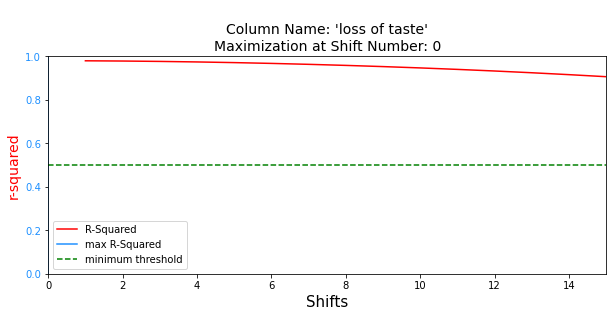

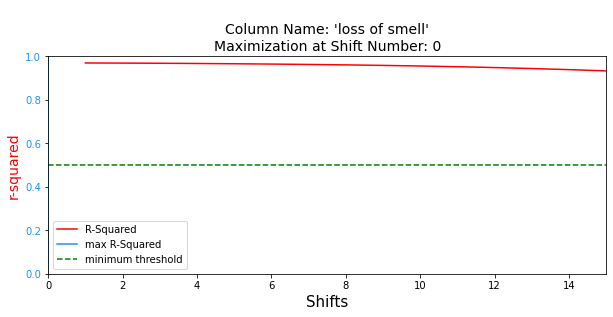

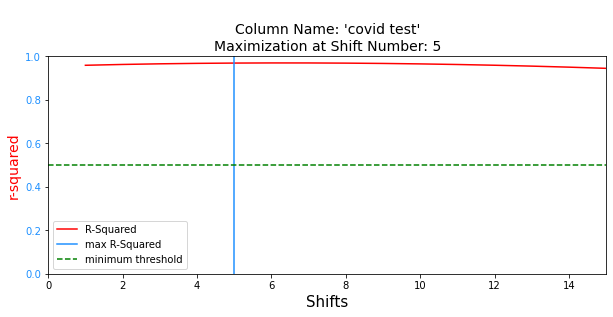

In [43]:
for i in range(0,len(cols)):
    
    x = pd.DataFrame(exog[cols[i]]).rename(columns = {cols[i]:0})

    # find scores for each shift
    shift = {}
    shifts = []
    rvals = []
    pvals = []
    
    for s in range(shift_min, shift_max+1, 1):

        # shift and convert values to numpy array    
        x[s] = x[0].shift(s)

        #set x an y values the same length with no nan values based on the new shift
        y_array = y[s:].reshape(-1, 1)
        x_array = x[s].to_numpy()[s:].reshape(-1, 1)
        pval, rsqr = get_pval_r2(x_array, y_array)
        
        shift[s] = {'pval': pval, 'rsqr': rsqr}

        shifts.append(int(s))
        pvals.append(pval)
        rvals.append(rsqr)
        
        max_rval = max(rvals)
        shift_max_rval = rvals.index(max_rval)
        
    # select the ideal column
    shifted_exog[f'{cols[i]}_lag_{shift_max_rval}'] = exog[cols[i]].shift(shift_max_rval)
     
    # display score progression with each shift
    if plot_shifts:
        
        fig, ax = plt.subplots(figsize = (10,4))
        ax.set_xlabel('Shifts', fontsize = 15)
        ax.set_ylabel('r-squared', color='red', fontsize = 14)
        ax.plot(shifts, rvals, color='red', label = 'R-Squared')
        ax.tick_params(axis='y', labelcolor='dodgerblue')
        ax.axvline(x = shift_max_rval, color = 'dodgerblue', label = 'max R-Squared')
        ax.axhline(y = min_rsquared, color = 'green', linestyle = 'dashed', label = 'minimum threshold')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.xlim([0, shift_max])
        plt.ylim([0,1])
        plt.title(f"\nColumn Name: '{cols[i]}'\nMaximization at Shift Number: {shift_max_rval}", fontsize = 14)
        plt.legend()
        plt.show()
        
    # assign uncorrelated values a value of 1. 
    if remove_uncorrelated:
        
        if max_rval <= min_rsquared:
            print("****************************************************************************")
            print(f"The column: '{cols[i]}' does not meet the minimum threshold to be included.")
            print(f"Therefore, it is being removed.")
            print("****************************************************************************")
            
            shifted_exog = shifted_exog.drop(columns = f'{cols[i]}_shift[{shift_max_rval}]')

## Variable Selection

In [44]:
def get_wls_model(X, y, w, add_intercept=True):
    
    X = sm.add_constant(X) if add_intercept==True else X
    wls_model = sm.WLS(y, X, weights = w)
    fitted_wls_model = sm.WLS(y, X, weights = w).fit()
    
    return wls_model, fitted_wls_model


In [45]:
def get_wls_results(y, wls_model, fitted_wls_model):
    
    #fitted_wls_model = wls_model.fit()
    
    res = sm.OLS(wls_model.wendog, wls_model.wexog).fit()
    influence = res.get_influence()
    
                       
    results = pd.DataFrame()
    results['y'] = y                                                         # target variable
    results['yhat'] = fitted_wls_model.predict()                             # predictions
    results['residuals'] = results['y']-results['yhat']                      # residuals
    results['studentized_residuals'] = influence.resid_studentized_external  # studentized residuals
    results['cooks_distance']= influence.cooks_distance[0]                   # cook's distance

    return results

In [46]:
def get_summary_of_fit(X,y,fitted_ols_model, add_intercept):
    
    rsquared = fitted_ols_model.rsquared
    rsquared_adj = fitted_ols_model.rsquared_adj
    root_mean_square_error = (
        (mean_squared_error(y,fitted_ols_model.predict(sm.add_constant(X))))*0.5 if add_intercept==True 
        else (mean_squared_error(y,fitted_ols_model.predict(X)))*0.5
    )
    mean_of_response = round(y.mean(),5)
    num_observations = fitted_ols_model.nobs
    
    bic = fitted_ols_model.bic
    aic = fitted_ols_model.aic

    summary_of_fit_dict = {
        'RSquare':rsquared,
        'RSquare Adj':rsquared_adj,
        'Root Mean Square Error':root_mean_square_error,
        'AIC':aic,    
        'BIC':bic,
        'Mean of Response':mean_of_response,
        'Observations (or Sum Wgts)':num_observations
    }

    summary_of_fit = pd.DataFrame(
        {
        ' ':list(summary_of_fit_dict.keys()),
        '':list(summary_of_fit_dict.values())
        }
    )

    return summary_of_fit, summary_of_fit_dict

In [47]:
def beautify_summary_of_fit(summary_of_fit):
    
    summary_of_fit[''] = round(summary_of_fit[''],6)
    summary_of_fit= summary_of_fit.astype(str)
    
    summary_of_fit[''].iloc[-1] = summary_of_fit[''].iloc[-1].replace('.0','')

    s = summary_of_fit.style.set_properties(**{'text-align': 'left'})
    s = s.set_caption('Summary of Fit').set_table_styles([
        {
        'selector': 'caption',
        'props': [('color', 'darkorange'),('font-size', '18px'),('font-weight:','bold')]
        }
    ])
    
    return s


In [48]:
def get_anova(fitted_ols_model):
    
    model_mse = round(fitted_ols_model.mse_model,3)
    resid_mse = round(fitted_ols_model.mse_resid,3)
    total_mse = round(fitted_ols_model.mse_total,3)

    model_df = int(fitted_ols_model.df_model)
    resid_df = int(fitted_ols_model.df_resid)
    total_df = int(model_df+resid_df)

    model_ss = round(model_mse*model_df,3)
    error_ss = round(resid_mse*resid_df,3)
    total_ss = round(total_mse*total_df,3)

    f_ratio = round(fitted_ols_model.fvalue,4)
    prob_f = round(fitted_ols_model.f_pvalue,4)

    source = ['Model','Error','C.Total']
    df = [model_df, resid_df, total_df]
    ss = [model_ss, error_ss, total_ss]
    ms = [model_ss, error_ss, '']
    fr = [f_ratio, 'Prob > F', prob_f]

    analysis_of_variance_dict = {
        'Source':source,
        'Deg of Freedom':df,
        'Sum of Squares':ss,
        'Mean Square':ms,
        'F Ratio':fr
    }
    
    analysis_of_variance = pd.DataFrame(analysis_of_variance_dict)
    
    return analysis_of_variance, analysis_of_variance_dict

In [49]:
def beautify_analysis_of_variance(analysis_of_variance):
    
    def reformat_p_values(pvalue):

        if float(pvalue) < 0.0001:
            new_pvalue = '<.0001*'

        elif ((float(pvalue) >= 0.0001)and(float(pvalue) < 0.05)):
            pvalue = round(pvalue,4)
            new_pvalue = '{}*'.format(pvalue)

        else: 
            pvalue = round(pvalue,4)
            new_pvalue = str(pvalue)

        return new_pvalue
    
    def color_p_values(val):
    
        if '*' in val:
            val = float(val.replace('<','').replace('*',''))
            if val < 0.01:
                color = 'darkorange'
            elif ((val >= 0.01)and(val < 0.05)):
                color = 'red'
            else:
                color = 'black'
            return 'color: %s' % color

        else:
            return 'color: black'  
    
    
    def bold_f_val(val):
        if val == 'Prob > F':
            return 'font-weight: bold'
        else:
            return 'font-weight: normal'
    
    pvalue=analysis_of_variance.iloc[2,4]
    new_pvalue = reformat_p_values(pvalue)
    analysis_of_variance.iloc[2,4] = new_pvalue
    analysis_of_variance['Sum of Squares'] = analysis_of_variance['Sum of Squares'].astype(str)
    analysis_of_variance['Mean Square'] = analysis_of_variance['Mean Square'].astype(str)
    analysis_of_variance['F Ratio'] = analysis_of_variance['F Ratio'].astype(str)
    s = analysis_of_variance.style.set_properties(**{'text-align': 'left'})
    s = s.applymap(color_p_values, subset = ['F Ratio'])
    s = s.applymap(bold_f_val, subset = ['F Ratio'])
    s = s.set_caption('Analysis of Variance').set_table_styles([
        {
        'selector': 'caption',
        'props': [('color', 'darkorange'),('font-size', '18px'),('font-weight:','bold')]
        }
    ])
    
    return s

In [50]:
def get_vifs(X, add_intercept):
    
    X = sm.add_constant(X) if add_intercept==True else X

    if ((X.columns[0] == 'const')and(len(X.columns)==2)):
        vifs = [np.nan, np.nan]
    
    elif (len(X.columns)==1):
        vifs = [np.nan]
        
    elif X.columns[0] == 'const':
        data = X.drop(columns = ['const']).copy()
        vifs = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
        vifs = [np.nan]+vifs
    else:
        data = X.copy()
        vifs = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    
    vifs = pd.Series(vifs, index = X.columns.to_list(), name = 'VIF')
    
    return vifs

In [51]:
def get_parameter_estimates(X,fitted_ols_model, add_intercept):

    terms = fitted_ols_model.params.index.to_list()
    estimates = fitted_ols_model.params.to_list()
    standard_errors = fitted_ols_model.bse.to_list()
    t_ratios = fitted_ols_model.tvalues.to_list()
    p_values = fitted_ols_model.pvalues.to_list()
    lower_95 = fitted_ols_model.conf_int(alpha = 0.5, cols = None)[0].to_list()
    upper_95 = fitted_ols_model.conf_int(alpha = 0.5, cols = None)[1].to_list()
    vifs = get_vifs(X, add_intercept).to_list()

    parameter_estimates_dict = {
        'Term':terms,
        'Estimate':estimates,
        'Std Error':standard_errors,
        't Ratio':t_ratios,
        'Prob > |t|':p_values,
        'Lower 95%':lower_95,
        'Upper 95%':upper_95,
        'VIF':vifs
    }

    parameter_estimates = pd.DataFrame(parameter_estimates_dict)
    
    return parameter_estimates, parameter_estimates_dict 

In [52]:
def beautify_parameter_estimates(parameter_estimates):
    
    def reformat_p_values(pvalue):

        if float(pvalue) < 0.0001:
            new_pvalue = '<.0001*'

        elif ((float(pvalue) >= 0.0001)and(float(pvalue) < 0.05)):
            pvalue = round(pvalue,4)
            new_pvalue = '{}*'.format(pvalue)

        else: 
            pvalue = round(pvalue,4)
            new_pvalue = str(pvalue)

        return new_pvalue

    def color_p_values(val):

        if '*' in val:
            val = float(val.replace('<','').replace('*',''))
            if val < 0.01:
                color = 'darkorange'
            elif ((val >= 0.01)and(val < 0.05)):
                color = 'red'
            else:
                color = 'black'
            return 'color: %s' % color

        else:
            return 'color: black' 

    def reformat_vifs(vif):

        vif = round(vif,4)

        if str(vif) == 'nan':
            new_vif = '.'

        elif vif <=10:
            new_vif = '{}*'.format(vif)

        else: 
            new_vif = str(vif)

        return new_vif


    def color_vifs(val):

        if '*' in val:
            val = float(val.replace('*',''))
            if val <=5.0:
                color = 'darkorange'
            elif ((val > 5.0)and(val <=10.0)):
                color = 'red'
            else:
                color = 'black'
            return 'color: %s' % color

        else:
            return 'color: black' 
    
    parameters_beautified = parameter_estimates.copy()

    parameters_beautified['Estimate'] = round(parameters_beautified['Estimate'],5)
    parameters_beautified['Std Error'] = round(parameters_beautified['Std Error'],5)
    parameters_beautified['t Ratio'] = round(parameters_beautified['t Ratio'],2)
    parameters_beautified['Prob > |t|'] = parameters_beautified['Prob > |t|'].apply(reformat_p_values)
    parameters_beautified['Lower 95%'] = round(parameters_beautified['Lower 95%'],5)
    parameters_beautified['Upper 95%'] = round(parameters_beautified['Upper 95%'],5)
    parameters_beautified['VIF'] = parameters_beautified['VIF'].apply(reformat_vifs)
    parameters_beautified = parameters_beautified.astype(str)
    parameters_beautified['Term'] = ['Intercept' if term == 'const' else term for term in parameters_beautified['Term'].to_list()]
    s = parameters_beautified.style.set_properties(**{'text-align': 'left'})
    s = s.applymap(color_p_values, subset = ['Prob > |t|'])
    s = s.applymap(color_vifs, subset = ['VIF'])
    s = s.set_caption('Parameter Estimates').set_table_styles([
        {
        'selector': 'caption',
        'props': [('color', 'darkorange'),('font-size', '18px'),('font-weight:','bold')]
        }
    ])
    return(s)

In [53]:
def wls_regression(
    y,
    X,
    w,
    add_intercept=True,
    display_summary_of_fit=True,
    display_analysis_of_variance=True,
    display_parameter_estimates=True,
    display_diagnostic_plots=True,
    display_leverage_plots=False,
    display_marginal_model_plots=False,
    return_data=False
):
    y = y.copy()
    w = w.copy()
    X = X.copy()

    wls_model, fitted_wls_model = get_wls_model(X, y, w, add_intercept=add_intercept)
    results = get_wls_results(y, wls_model, fitted_wls_model)

    yhat = results['yhat']
    residuals = results['residuals']
    studentized_residuals = results['studentized_residuals']
    cooks_distance = results['cooks_distance']

    if display_summary_of_fit:
        summary_of_fit = get_summary_of_fit(X,y,fitted_wls_model, add_intercept=add_intercept)[0]
        display(beautify_summary_of_fit(summary_of_fit))

    if display_analysis_of_variance:
        analysis_of_variance=get_anova(fitted_wls_model)[0]
        display(beautify_analysis_of_variance(analysis_of_variance))

    if display_parameter_estimates:
        parameter_estimates = get_parameter_estimates(X,fitted_wls_model, add_intercept=add_intercept)[0]
        parameters_beautified = beautify_parameter_estimates(parameter_estimates)
        display(parameters_beautified)

    if display_diagnostic_plots:
        make_wls_diagnostic_plots(y, wls_model, fitted_wls_model)

    if display_marginal_model_plots:
        #marginal_model_plots(results,X, show_actuals = True, show_predicteds = True, smoothness = 0.5)
        marginal_model_plots(y, yhat, X)

    if display_leverage_plots:
        make_leverage_plots(fitted_wls_model)

    if return_data:
        return results, fitted_wls_model

In [54]:
def all_possible_models(
    y,
    X,
    w=False,
    num_show = 10,
    min_cols = 1,
    max_cols = 10000000,
    stopping_rule = 'bic',
    dislay_results = True,
    pval_max = 0.5,
    vif_max = 10,
    add_intercept=True,
    screen_pvalues=True,
    screen_vifs=True
): 
    
    max_cols = len(X.columns)
    # if w is false, then adjust the all models so it works like a an OLS, not a WLS
    
    if w == False:
        
        X['weight'] = 1
        w = X['weight']
        X = X.drop(columns = 'weight')
    
    from itertools import chain, combinations
    from math import comb
    
    def generate_combinations(outcomes, rolls=1):

        # outcome generator developed by AJ Hill

        N = len(outcomes)
        if N == 0 or rolls == 0:
            yield []
            return

        indices = [0 for _ in range(rolls)]

        for i in range(N**rolls):
            yield [outcomes[index] for index in indices]

            for i in range(rolls):
                indices[i] += 1
                if indices[i] == N:
                    indices[i] = 0
                else:
                    break
    
    def find_num_models(total_cols, max_cols, min_cols):

        """
        Takes the maximum number of columns and the minimum number of columns and returns 
        an integer value which represents the number of possible models that can be evaluated.

        Parameters:
        total_cols: A non-negative integer
        max_cols: A non-negative integer
        min_cols: A non-negative integer

        Returns:
        num_models: A non-negative integer

        """
        from math import comb

        upper, lower = 0, 0

        for col_num in range(1, total_cols+1):

            upper += comb(total_cols, col_num)

            if col_num == min_cols-1:
                lower = upper

        num_models = upper - lower     #Add one to account for the same number of max, min, and total columns

        return num_models

    def num_combinatons_powerset(n):

        # Relation to binomial theorem
        # Abs (2^S)

        # https://en.wikipedia.org/wiki/Power_set

        return int(2**n)
    
    def powerset(iterable):
    
        # iterable engine made by AJ Hill
        
        s = list(iterable)
        return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


    min_cols = min_cols-1
    if min_cols < 0:
        min_cols = 0

    cols_list = X.columns.to_list()
    total_cols = len(X.columns.to_list())

    from tqdm.notebook import tqdm_notebook as tqdm
    import math

    if max_cols > total_cols:
        max_cols = total_cols

    total_model_fits = find_num_models(total_cols, max_cols, min_cols)
    total_iterations = num_combinatons_powerset(total_cols)-1

    print('\nAll Possible Models\n')
    print('Total columns/features:          {}'.format(total_cols))
    print('Max coefficients to use:         {}'.format(max_cols))
    print('Min coefficients to use:         {}'.format(min_cols))
    print('Total number of models to fit:   {}'.format(total_model_fits)) 
    print('Number of combinations:          {}'.format(total_iterations))
    print('Number of top models to display: {}'.format(num_show))
    print('\n****Fitting {} model(s) out of {} possible combinations?****\n'.format(total_model_fits, total_iterations))

    pbar = tqdm(total=total_iterations-1) # display progress...

    sets = list(powerset(cols_list))

    all_models = {}
    model_num = 0

    for cols in sets[1:][::-1]:
        pbar.update(1)

        if len(cols) < min_cols or len(cols) > max_cols:  #screen out columns from max or min
            continue

        X_predictors = X[list(cols)]

        if add_intercept == True:
            X_predictors = sm.add_constant(X_predictors)

        # fitted model
        model_wls = sm.WLS(y, X_predictors, weights=w) # fit model
        fitted_wls = model_wls.fit()

        # screen for pvalues and vifs

        pvalues = list((fitted_wls.pvalues).values)
        vifs = list(get_vifs(X_predictors, add_intercept).values)

        # screen for pvalues
        if screen_pvalues == True and max([0 if np.isnan(val) else val for val in pvalues]) >= pval_max:
                    continue

        # screen for vifs
        if screen_vifs == True and max([0 if np.isnan(val) else val for val in vifs]) > vif_max:
                    continue

        # metrics
        model_num += 1
        num_terms = len(cols)
        coeffs = list((fitted_wls.pvalues).index)

        llf = fitted_wls.llf
        nobs = fitted_wls.nobs
        df_modelwc = len(pvalues)
        aic = fitted_wls.aic
        aicc = sm.tools.eval_measures.aicc(llf, nobs, df_modelwc)
        bic = fitted_wls.bic
        rsquared_adj = fitted_wls.rsquared_adj
        rmse = (
            (mean_squared_error(y,fitted_wls.predict(sm.add_constant(X_predictors))))*0.5 if add_intercept==True
            else (mean_squared_error(y,fitted_wls.predict(X_predictors)))*0.5
        )

        all_models[model_num] = [coeffs, pvalues, vifs, num_terms, aic, aicc, bic, rsquared_adj, rmse]

        # display progress  

    pbar.close()  
    df = pd.DataFrame(all_models).T

    df.columns = ['coeffs', 'pvalues', 'vif', 'num_terms', 'aic', 'aicc', 'bic', 'rsquared_adj', 'rmse']
    df = df.sort_values(by = stopping_rule)
    
    if dislay_results:
        df_display = df[['coeffs', 'num_terms', 'aic', 'aicc', 'bic', 'rsquared_adj', 'rmse']]
        display(df_display.head(num_show))
        
        columns = [feature for feature in df.iloc[0][0] if feature != 'const']
        
        print('\nBest Model Fit Based on {}'.format(stopping_rule.upper()))
        print('\n\nColumns Used:\n')
        
        for col in columns:
            print(col)
        print('\n\n')
        results, fitted_wls_model = wls_regression(
            y,
            X[columns],
            w,
            add_intercept=True,
            display_summary_of_fit=True,
            display_analysis_of_variance=True,
            display_parameter_estimates=True,
            display_diagnostic_plots=False,
            display_leverage_plots=False,
            display_marginal_model_plots=False,
            return_data=True
        )
    
    return df, fitted_wls_model


In [55]:
def get_fitted_wls_model(X, y, w, add_intercept=True):
    
    X = sm.add_constant(X) if add_intercept==True else X
    fitted_wls_model = sm.WLS(y, X, weights = w).fit()
    
    return fitted_wls_model

In [56]:
def get_metrics(fitted_wls_model):
    
    pvalues = fitted_wls_model.pvalues
    llf = fitted_wls_model.llf
    nobs = fitted_wls_model.nobs
    df_modelwc = len(pvalues)
    aic = fitted_wls_model.aic
    bic = fitted_wls_model.bic
    aicc = sm.tools.eval_measures.aicc(llf, nobs, df_modelwc)
    rsquared_adj = fitted_wls_model.rsquared_adj
    
    return aic, bic, aicc, rsquared_adj 


In [57]:
def forward_remove_next_feature(X, y, w, add_intercept=True):
    
    fitted_wls_model = get_fitted_wls_model(X, y, w, add_intercept=True)
    df = pd.DataFrame(fitted_wls_model.pvalues)
    df = pd.DataFrame(fitted_wls_model.pvalues).sort_values(by = 0, ascending = False)
    df = df.loc[df.index != 'const']
    remove_feature = df.index[0]
    sig_prob = df[0][0]
    #display(df)
    return sig_prob, remove_feature

In [58]:
def forward_backward_selection(y, 
                               X, 
                               w=False, 
                               method = 'fit_backward', 
                               stopping_rule = 'bic'):
#TODO put a dotted red line at the AIC/BIC value that is selected.

    # if w is false, then adjust the all models so it works like a an OLS, not a WLS
    
    if w == False:
        
        X['weight'] = 1
        w = X['weight']
        X = X.drop(columns = 'weight')
        
    original_X = X.copy()
    
    if method == 'fit_backward':
        
        if stopping_rule == 'bic': stopping_rule = 'BIC'
        elif stopping_rule == 'aic': stopping_rule = 'AIC'
        elif stopping_rule == 'aicc': stopping_rule = 'AICc'          
        else: 
            print('Stopping rule not specifide.')
            return 
            
    features_list = X.columns.to_list()
    remove_from_features_list = X.columns.to_list()

    step_history_list = []
    remaining_columns_list = []
    sig_prob_list = []
    aic_list = []
    bic_list = []
    aicc_list = []
    rsquared_adj_list = []
    remove_list = ['All']
    action_list = ['Entered']


    for step in range(0,len(X.columns)):

        fitted_wls_model = get_fitted_wls_model(X, y, w, add_intercept=True)
        aic, bic, aicc, rsquared_adj = get_metrics(fitted_wls_model)
        sig_prob, remove_feature = forward_remove_next_feature(X, y, w, add_intercept=True)

        step_history_list.append(step+1)
        remove_list.append(remove_feature)
        action_list.append('Removed')
        remaining_columns_list.append(X.columns.to_list())
        sig_prob_list.append(round(sig_prob,6))
        aic_list.append(aic)
        aicc_list.append(aicc)
        bic_list.append(bic)
        rsquared_adj_list.append(rsquared_adj)

        remove_from_features_list.remove(remove_feature)

        X = X[remove_from_features_list]

    action_list  = action_list[0:-1]
    remove_list  = remove_list[0:-1]

    step_history_dict = {
        'Step': step_history_list,
        'Parameter':remove_list,
        'Action':action_list,
        'Sig Prob': sig_prob_list,
        'AIC': aic_list,
        'AICc':aicc_list,
        'BIC': bic_list,
        'RSquare Adj': rsquared_adj_list,
        'remaining_cols':remaining_columns_list}

    step_history = pd.DataFrame(step_history_dict)
    
    #TODO: Fix this code below for the changes in method selection
    min_amount = step_history[stopping_rule].min()

    if stopping_rule != 'RSquare Adj':

        best_cols = step_history.loc[step_history[stopping_rule] == step_history[stopping_rule].min()]['remaining_cols'].values[0]

    elif stopping_rule == 'RSquare Adj':

        best_cols = step_history.loc[step_history[stopping_rule] == step_history[stopping_rule].max()]['remaining_cols'].values[0]
    else:
        print('Unkonwn stopping rule')

    best_cols = step_history.loc[step_history[stopping_rule] == step_history[stopping_rule].min()].copy()
    best_cols['Step'] = step+2
    best_cols['Parameter'] = 'Best'
    best_cols['Action'] = 'Specific'
    
    # plot the stepwise progress....
    fig, ax1 = plt.subplots(figsize = (13.5,4))

    ax1.set_xlabel('Steps', color = 'black', fontsize = 15)
    ax1.set_ylabel('AIC-BIC', color='black', fontsize = 15)
    ax1.plot(step_history['Step'], step_history['AIC'], label = 'AIC')
    #ax1.plot(step_history['Step'], step_history['AICc'], label = 'AICc')
    ax1.plot(step_history['Step'], step_history['BIC'], label = 'BIC')
    ax1.tick_params(axis='y', labelcolor='black')
    plt.legend(loc = 2, fontsize = 14)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel('R-Squared Adj.', color='black', fontsize = 15)  # we already handled the x-label with ax1
    ax2.plot(step_history['Step'], step_history['RSquare Adj'], label = 'RSquare Adj', color = 'dodgerblue', linestyle = '--')
    ax2.tick_params(axis='y', labelcolor='black')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('\nStepwise Fit Backward\n', fontsize = 20)
    plt.legend(loc = 1, fontsize = 14)
    plt.show()

    # display the stepwise results dataframe
    step_history = step_history.append(best_cols, ignore_index=True)
    display(step_history)
    
    # get the selected columns based on the stopping rule:
    col_list = best_cols.values[0][-1]

    results, fitted_ols_model = wls_regression(
        y = y,
        X = original_X[col_list],
        w = w,
        add_intercept=True,
        display_summary_of_fit=True,
        display_analysis_of_variance=True,
        display_parameter_estimates=True,
        display_diagnostic_plots=False,
        display_leverage_plots=False,
        display_marginal_model_plots=False,
        return_data=True
    )
    
    return results, fitted_ols_model, step_history


In [59]:
y = pd.DataFrame(y_train).rename(columns = {'lowess':'y'})
data = y.merge(shifted_exog, how = 'left', left_index = True, right_index = True)

# drop nan values to do modeling
df = data.dropna()
display(df)

# test train split

X = df[[col for col in df.columns if col != 'y']] 
y = df['y']

# X_train = df[0:round(len(df.index)*cut)][[col for col in df.columns if col != 'y']]  
# X_test = df[round(len(df.index)*cut):][[col for col in df.columns if col != 'y']] 
                      
# y_train = df[0:round(len(df.index)*cut)]['y']                 
# y_test = df[round(len(df.index)*cut):]['y']

y  loss of taste_lag_0  loss of smell_lag_0  \
date                                                                  
2020-09-16   40347.104630            29.749464            22.971474   
2020-09-17   40938.932845            29.878679            23.071743   
2020-09-18   41432.237028            29.994450            23.185132   
2020-09-19   41811.375899            30.094539            23.316419   
2020-09-20   42091.517274            30.177394            23.469758   
...                   ...                  ...                  ...   
2021-01-04  227564.095433            94.213505            90.403890   
2021-01-05  230228.608404            93.737716            89.920949   
2021-01-06  232337.732728            93.107961            89.224159   
2021-01-07  233631.340990            92.323226            88.315371   
2021-01-08  234020.523770            91.385250            87.203388   

            covid test_lag_5  
date                          
2020-09-16         27.712095  
2020-09-17         27.620901  
2020-09-18         27.706656  
2020-09-19         27.984229  
2020-09-20         28.275396  
...                      ...  
2021-01-04         79.745858  
2021-01-05         79.354797  
2021-01-06         78.909791  
2021-01-07         78.416046  
2021-01-08         77.876389  

[115 rows x 4 columns]

## Test XGBoost

In [60]:
# y_xgboost = y.copy()
# X_xgboost = X.copy()


In [61]:
# data_dmatrix = xgb.DMatrix(data=X,label=y)

In [62]:
# param = {
#     'eta': 0.3, 
#     'max_depth': 3,  
#     'objective': 'multi:softprob',  
#     'num_class': 3} 

# steps = 20  # The number of training iterations

In [63]:
# model = xgb.train(param, X_xgboost, steps)

In [64]:
# drop nan values to do modeling
df = data.dropna()

# test train split

X = df[[col for col in df.columns if col != 'y']] 
y = df['y']

X_train = df[0:round(len(df.index)*cut)][[col for col in df.columns if col != 'y']]  
X_test = df[round(len(df.index)*cut):][[col for col in df.columns if col != 'y']] 
                      
y_train = df[0:round(len(df.index)*cut)]['y']                 
y_test = df[round(len(df.index)*cut):]['y']

df = all_possible_models(
    y_train,
    X_train,
    num_show = 100,
    stopping_rule = 'aic',
    pval_max = 0.5,
    vif_max = 10,
    add_intercept=True,
    screen_pvalues=True,
    screen_vifs=True
)

selected_features = [col for col in df[0].sort_values('aic').iloc[1][0] if col != 'const']

reg = LinearRegression().fit(X_train[selected_features], y_train)
predictions = reg.predict(X_test[selected_features])
fit_values = reg.predict(X_train[selected_features])
y_train = pd.DataFrame(y_train)
y_train['fitted'] = fit_values
y_test = pd.DataFrame(y_test)
y_test['yhat'] = predictions

predictions = pd.DataFrame(y_test['yhat'])
predictions = np.expm1(predictions)



All Possible Models

Total columns/features:          3
Max coefficients to use:         3
Min coefficients to use:         0
Total number of models to fit:   7
Number of combinations:          7
Number of top models to display: 100

****Fitting 7 model(s) out of 7 possible combinations?****



  0%|          | 0/6 [00:00<?, ?it/s]

coeffs num_terms      aic     aicc      bic  \
3  [const, loss of taste_lag_0]         1  2428.06  2428.17  2433.53   
1     [const, covid test_lag_5]         1  2467.45  2467.56  2472.92   
2  [const, loss of smell_lag_0]         1   2479.4   2479.5  2484.87   

  rsquared_adj         rmse  
3     0.978974   5.0258e+07  
1     0.970297  7.09979e+07  
2     0.967014  7.88439e+07


Best Model Fit Based on AIC


Columns Used:

loss of taste_lag_0





## Transfer Function Results

In [66]:
# transfer function predictors
test_predictors = X_forecast['loss of smell'].values.reshape(-1, 1)
train_predictors = X_train['loss of taste_lag_0'].values.reshape(-1, 1)

transfer_test_predictions = reg.predict(test_predictors)
transfer_train_predictions = reg.predict(train_predictors)

# original y_train 
y_train = train.lowess.copy()[train_start : train_end]

In [67]:
transfer_test_predictions

array([228580.45229301, 224909.77100702, 221285.30745885, 217706.47971857,
       214172.71318338, 210683.44048532, 207238.10140016, 203836.14275753,
       200477.01835204, 197160.18885558, 193885.12173077, 190651.29114543,
       187458.17788816, 184305.26928498, 181192.05911701])

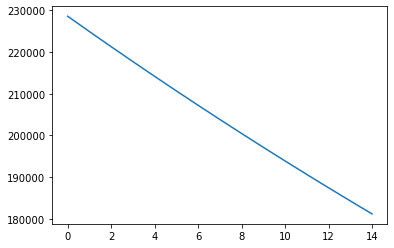

In [68]:
plt.plot(transfer_test_predictions)

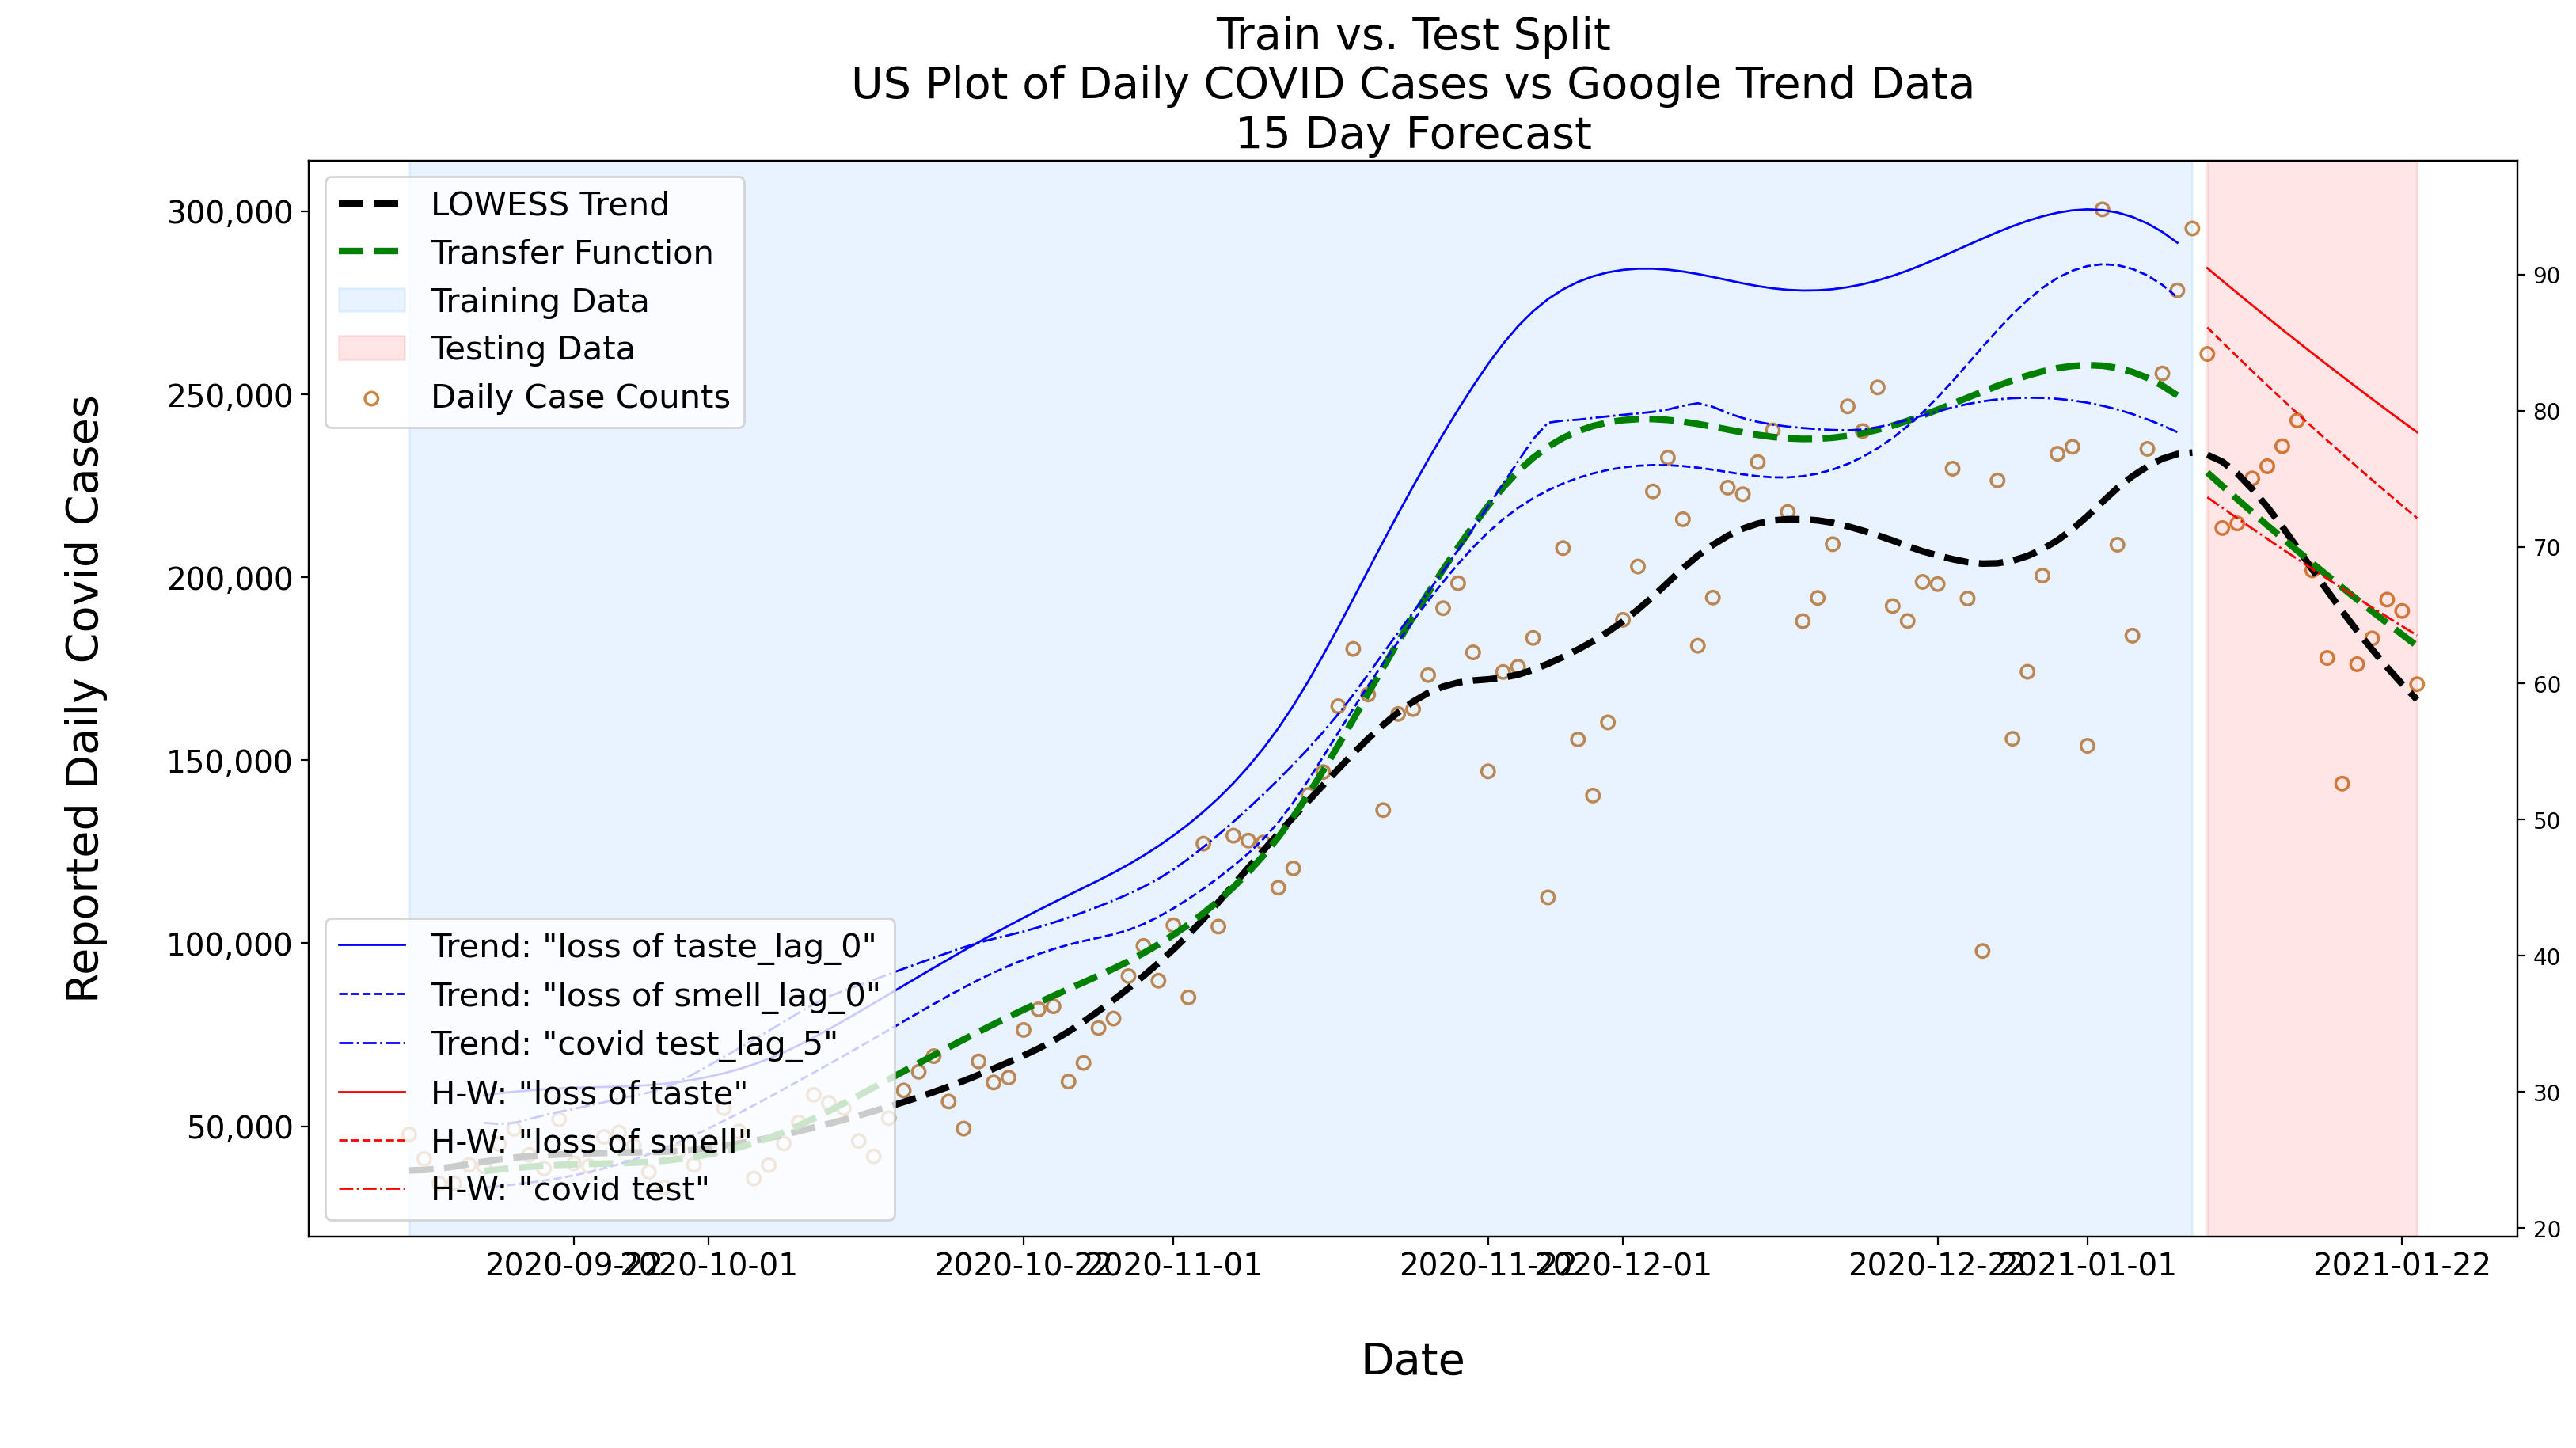

In [69]:
# make the plot of the daily data and smoothed vlaues
plt.style.context('ggplot')
fig, ax1 = plt.subplots(figsize = (18,9), dpi = 200)

fmt = '{x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 
ax1.tick_params(axis='y', labelsize = 14) 
ax1.tick_params(axis='x', labelsize = 14)

ax1.set_title('Train vs. Test Split\n{} Plot of Daily COVID Cases vs Google Trend Data\n{} Day Forecast'.format(COUNTRY_NAME, FORECAST_LENGTH), fontsize = 20)
ax1.set_xlabel('\nDate\n', fontsize = 20)
ax1.set_ylabel('\nReported Daily Covid Cases\n', fontsize = 20)

ax1.scatter(train.index, train.y, facecolors='none', edgecolors='peru', linewidth = 1.25, s = 35, label = 'Daily Case Counts')
ax1.plot(y_train.index, y_train, linestyle = '--', color = 'black', linewidth = 3 ,label = 'LOWESS Trend')
ax1.scatter(test.index, test.y, facecolors='none', edgecolors='peru', linewidth = 1.25, s = 35)
ax1.plot(test.index, test.lowess, linestyle = '--', color = 'black', linewidth = 3 )

ax1.plot(X_train.index, transfer_train_predictions, linestyle = '--', color = 'green', linewidth = 3, label = 'Transfer Function')
ax1.plot(test.index, transfer_test_predictions, linestyle = '--', color = 'green', linewidth = 3 )

ax1.axvspan(train_start, train_end, alpha=0.1, color='dodgerblue', label = 'Training Data')
ax1.axvspan(test_start, test_end, alpha=0.1, color='red', label = 'Testing Data')
ax1.legend(loc = 2, fontsize = 15)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

linestyle = ['-','--','-.']
for line, col in zip(linestyle, X.columns):
    ax2.plot(X_train.index, X_train[col], linestyle = line, color = 'blue', linewidth = 1 ,label = f'Trend: "{col}"')
ax2.yaxis.set_major_formatter(tick) 

for line, col in zip(linestyle, X_forecast.columns):
    ax2.plot(X_forecast.index, X_forecast[col], linestyle = line, color = 'red', linewidth = 1 ,label = f'H-W: "{col}"')


#ax2.grid(which = 'major')
ax2.legend(loc = 3, fontsize = 15)
plt.show()

# ARIMAX Model

## Stationarity

<b>Stationarity:</b> A common assumption in many time series techniques is that the data are stationary. A stationary process has the property that the mean, variance and autocorrelation structure do not change over time. Stationarity can be defined in precise mathematical terms, but for our purpose we mean a flat looking series, without trend, constant variance over time, a constant autocorrelation structure over time and no periodic fluctuations (seasonality). 

SOURCE: https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc442.htm

In [70]:
def augmented_dickey_fuller(y, confidence = '5%'):
    #helper()
    
    # test values
    result = adfuller(y)
    adf = result[0]
    pval = result[1]
    conf = result[4][confidence]
    
    print(f'ADF: {adf} < test: {conf}')
    print(f'pval: {pval} < confidence: {confidence}')
    # do the test
    if adf<conf and conf < 0.05:
        return True
    else:
        return False

In [71]:
#TODO: Make this a list of tuples

def make_stationary(y, confidence = '5%'):
    #helper()
    
    transformation_record = {}
    
    for i in range(0,10,1):
        print(f'\nAttempting the Augmented Dickey-Fuller Test for Stationarity at the {confidence} level.')
        if augmented_dickey_fuller(y, confidence = confidence) == True:
            print(f':  Passed the at the {i-1} index.')
            break
        else:
            print(f":  Failed at the {i-1} index.\nLet's try a transformation.")

        if i == 0:
            print(f':  Log transformed at index {i}.')
            transformation_record[i] = ['log',y[0],y[-1]]
            y = np.log1p(y).fillna(0)
        else: 
            print(f':  Differenced at index {i}.')
            transformation_record[i] = ['diff',y[0],y[-1]]
            y = y.diff().fillna(0)
            
    return y, transformation_record

## Make the train and test data, and unify their lengths

In [72]:
y_train = y[1:]
X_train = pd.Series(data = transfer_train_predictions, index = y_train.index)
X_test = pd.Series(data = transfer_test_predictions, index = test.index)
y_train_last = y_train[-1]

## transform the target variable 'y' for stationarity

In [73]:
y_train, y_train_transformation_record = make_stationary(y_train, confidence = '5%')


Attempting the Augmented Dickey-Fuller Test for Stationarity at the 5% level.
ADF: -1.1762995211295562 < test: -2.8886968193364835
pval: 0.6837070768184091 < confidence: 5%
:  Failed at the -1 index.
Let's try a transformation.
:  Log transformed at index 0.

Attempting the Augmented Dickey-Fuller Test for Stationarity at the 5% level.
ADF: -2.125555049755442 < test: -2.8886968193364835
pval: 0.2343637037440764 < confidence: 5%
:  Failed at the 0 index.
Let's try a transformation.
:  Differenced at index 1.

Attempting the Augmented Dickey-Fuller Test for Stationarity at the 5% level.
ADF: -2.183642340245639 < test: -2.8884437992971588
pval: 0.21223581755509974 < confidence: 5%
:  Failed at the 1 index.
Let's try a transformation.
:  Differenced at index 2.

Attempting the Augmented Dickey-Fuller Test for Stationarity at the 5% level.
ADF: -3.0460181718232477 < test: -2.8881954545454547
pval: 0.030814681569170135 < confidence: 5%
:  Passed the at the 2 index.


## transform the results of the transfer function

In [74]:
#transform the exogenous the same way the original data was transformed

X_train_transformation_record = {}
X_test_transformation_record = {}

for i in y_train_transformation_record.keys():
       
    if i == 0:
        print(f':  Log transformed on X_train and X_test at index {i}.')
        X_train_transformation_record[i] = ['log',X_train[0], X_train[-1]]
        X_test_transformation_record[i] = ['log',X_test[0], X_test[-1]]
        
        X_train = np.log1p(X_train).fillna(0)
        X_test = np.log1p(X_test).fillna(0)
        
    else: 
        
        print(f':  Differenced at X_train and X_test at index {i}.')
        X_train_transformation_record[i] = ['diff',X_train[0], X_train[-1]]
        X_test_transformation_record[i] = ['diff',X_test[0], X_test[-1]]
        
        X_train = X_train.diff().fillna(0)
        X_test = X_test.diff().fillna(0)

:  Log transformed on X_train and X_test at index 0.
:  Differenced at X_train and X_test at index 1.
:  Differenced at X_train and X_test at index 2.


### Convert values to arrays

In [75]:
#convert values to arrays
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)

## Grid Search for the Best ARIMA model

A nonseasonal ARIMA model is classified as an "ARIMA(p,d,q)" model, where: p is the number of autoregressive terms, d is the number of nonseasonal differences needed for stationarity, and. q is the number of lagged forecast errors in the prediction equation.

In [76]:
def grid_search_arima(y_train, X_train):

    # set variables          
    aic_min, bic_min, mse_min = np.inf, np.inf, np.inf
    mse_, aic_, bic_ = [],[],[]
    # grid search 
    for p in range(7):     
        for d in range(3):    
            for q in range(3): 
                try:
                    model_fit = ARIMA(endog = y_train, order=(p, d, q), exog = X_train, freq="D").fit(disp=0)
                    train_yhat = model_fit.predict(start=0, end=len(y_train)-1)
                    
                    # calculate metrics
                    mse = mean_squared_error(y_train, train_yhat)
                    aic = model_fit.aic
                    bic = model_fit.bic

                    # find the lowest metrics
                    if mse < mse_min:
                        mse_ = [p, d, q]                      
                    if aic < aic_min:
                        aic_ = [p, d, q]
                    if bic < bic_min:
                        bic_ = [p, d, q]
                    
                except Exception:
                    continue 
            # TODO: Check code   
            results = pd.DataFrame({1:mse_, 2:aic_, 3:bic_}).T.drop_duplicates().astype(int)      
            
    return results

In [77]:
# grid search best ARIMA
top_arima_results = grid_search_arima(y_train, X_train)

In [78]:
top_arima_results

0  1  2
1  6  0  2

## Ensemble ARIMA results and make the final forecast

In [79]:
def train_arima_ensembles(y_train, X_train, top_arima_results):
        
    # establish start and end times for the training data
    start_train = 0
    end_train = len(y_train)
    
    # Store the predictions from each model in a dataframe to train the gradient boosting ensembler
    ensemble_df = pd.DataFrame({'y_train':y_train})
    model_storage = {}
    ensemble_storage ={}
    
    # display progress
    combinations = len(top_arima_results)
    
    # Fit the top arima models on all the training sets. 
    for index,row in top_arima_results.iterrows():

        p = row[0]
        d = row[1]
        q = row[2]
        arima_order = (p,d,q)
        model_parameters = arima_order
        model_name = 'daily_ARIMA({},{},{})'.format(p,d,q)

        model = ARIMA(endog = y_train, order=arima_order, exog = X_train, freq="D")
        model_fit = model.fit(disp=0)
        predictions = model_fit.predict(start=start_train, end=end_train-1)

        col_name = str(model_name)
        prediction_values = list(predictions)
        ensemble_df[col_name] = predictions

        model_storage[col_name] = model_fit, model_parameters
        
    # extract X for training the ensemble algorithm
    Y = ensemble_df['y_train']
    X = ensemble_df.iloc[:,1:len(ensemble_df.columns)]

    lr_model       = LinearRegression()
    y = ensemble_df['y_train']
    X = ensemble_df.iloc[:,1:len(ensemble_df.columns)]

    lr_model_fit       = lr_model.fit(X,y)
    ensemble_storage['lr_model_fit'] = lr_model_fit
    ensemble_arimas_df = ensemble_df[[col for col in ensemble_df.columns.tolist() if 'ARIMA' in col]]
    ensemble_df['lr_ensemble']           = lr_model_fit.predict(ensemble_arimas_df)
    ensemble_df['ensembled_predictions'] = ensemble_df[[col for col in ensemble_df.columns.tolist() if 'y_train' not in col]].mean(axis=1)

    return ensemble_df, model_storage, ensemble_storage
    

In [80]:
# ensemble the top ARIMA models
# using transformed X_train from teh transfer function for the predictions

ensemble_df, model_storage, ensemble_storage = train_arima_ensembles(y_train, X_train, top_arima_results)

In [81]:
ensemble_df

y_train  daily_ARIMA(6,0,2)  lr_ensemble  ensembled_predictions
date                                                                        
2020-09-17  0.000000            0.000098     0.000073               0.000085
2020-09-18  0.011977            0.013029     0.012572               0.012801
2020-09-19 -0.002868           -0.003102    -0.003019              -0.003061
2020-09-20 -0.002431           -0.002893    -0.002817              -0.002855
2020-09-21 -0.001887           -0.001918    -0.001874              -0.001896
...              ...                 ...          ...                    ...
2021-01-04 -0.002598           -0.001984    -0.001939              -0.001961
2021-01-05 -0.002710           -0.003624    -0.003524              -0.003574
2021-01-06 -0.002522           -0.002309    -0.002252              -0.002280
2021-01-07 -0.003567           -0.002661    -0.002593              -0.002627
2021-01-08 -0.003888           -0.004376    -0.004250              -0.004313

[114 rows x 4 columns]

## Make raw predictions

In [82]:
def make_raw_predictions(y_train, X_test, model_storage, ensemble_storage, forecast_length):

    # establish start and end times for the training data
    start_train = 0
    end_train = len(y_train)

    # dataframe to store results
    predictions_df  = pd.DataFrame()

    # establish the forecast length
    forecast_domain = end_train+forecast_length 
    forecast_start  = end_train
    forecast_end    = forecast_start+forecast_length

    # progress bar
    from tqdm.notebook import tqdm_notebook as tqdm
    
    # display progress
    combinations = len(model_storage)

    
    # make the forecasts from the models in the model dictionary.
    for model_name in model_storage:             # model_name: this is the key in the dictionary
        
        model = model_storage[model_name][0]     # select the model from the model storage dictionary
        predictions = model.predict(start=forecast_start, end=forecast_end-1, exog = X_test)  # make predictions with the model
        
        predictions_df[model_name] = predictions                             # put the prediction in the predicitons dataframe
        
    arimas_df = predictions_df.copy()

    #assign values from ensemble model fits
    lr_model_fit = ensemble_storage['lr_model_fit']


    # ensemble the forecast
    predictions_df['daily_lr_ensemble']           = lr_model_fit.predict(arimas_df)
    predictions_df['daily_ensembled_predictions']       = lr_model_fit.predict(arimas_df)
    
    # calculate the maximum and minimum prediction for each row. 
    predictions_df['maximum_range'] = predictions_df.max(axis = 1)
    predictions_df['minimum_range'] = predictions_df.min(axis = 1)
    
    return predictions_df

In [83]:
# make raw predictions from the transformed data and fit models
# using transformed X_test from the transfer function for the predictions

raw_predictions_df = make_raw_predictions(y_train, X_test, model_storage, ensemble_storage, FORECAST_LENGTH)

## Unscramble the previous transformations

In [84]:
raw_predictions = raw_predictions_df['daily_ensembled_predictions'].copy()
the_forecast = list(np.r_[y_train_transformation_record[2][2], raw_predictions].cumsum())[0:len(raw_predictions)]
the_forecast = list(np.r_[y_train_transformation_record[1][2] , the_forecast].cumsum())[0:len(raw_predictions)]
the_forecast  = np.expm1(the_forecast)   
the_forecast 

array([234020.52376968, 234410.35484705, 234524.94730385, 230224.1549483 ,
       225615.20556542, 220663.55136606, 215359.22753361, 209709.92646321,
       203753.73648284, 197557.96261077, 191203.43171253, 184771.99765914,
       178340.35483329, 171976.60840966, 165739.39208029])

In [85]:
y_train_transformation_record

{0: ['log', 40938.932844860494, 234020.52376967962],
 1: ['diff', 10.61986121888322, 12.363168372031469],
 2: ['diff', 0.0, 0.0016644056604828705]}

# Plot the results

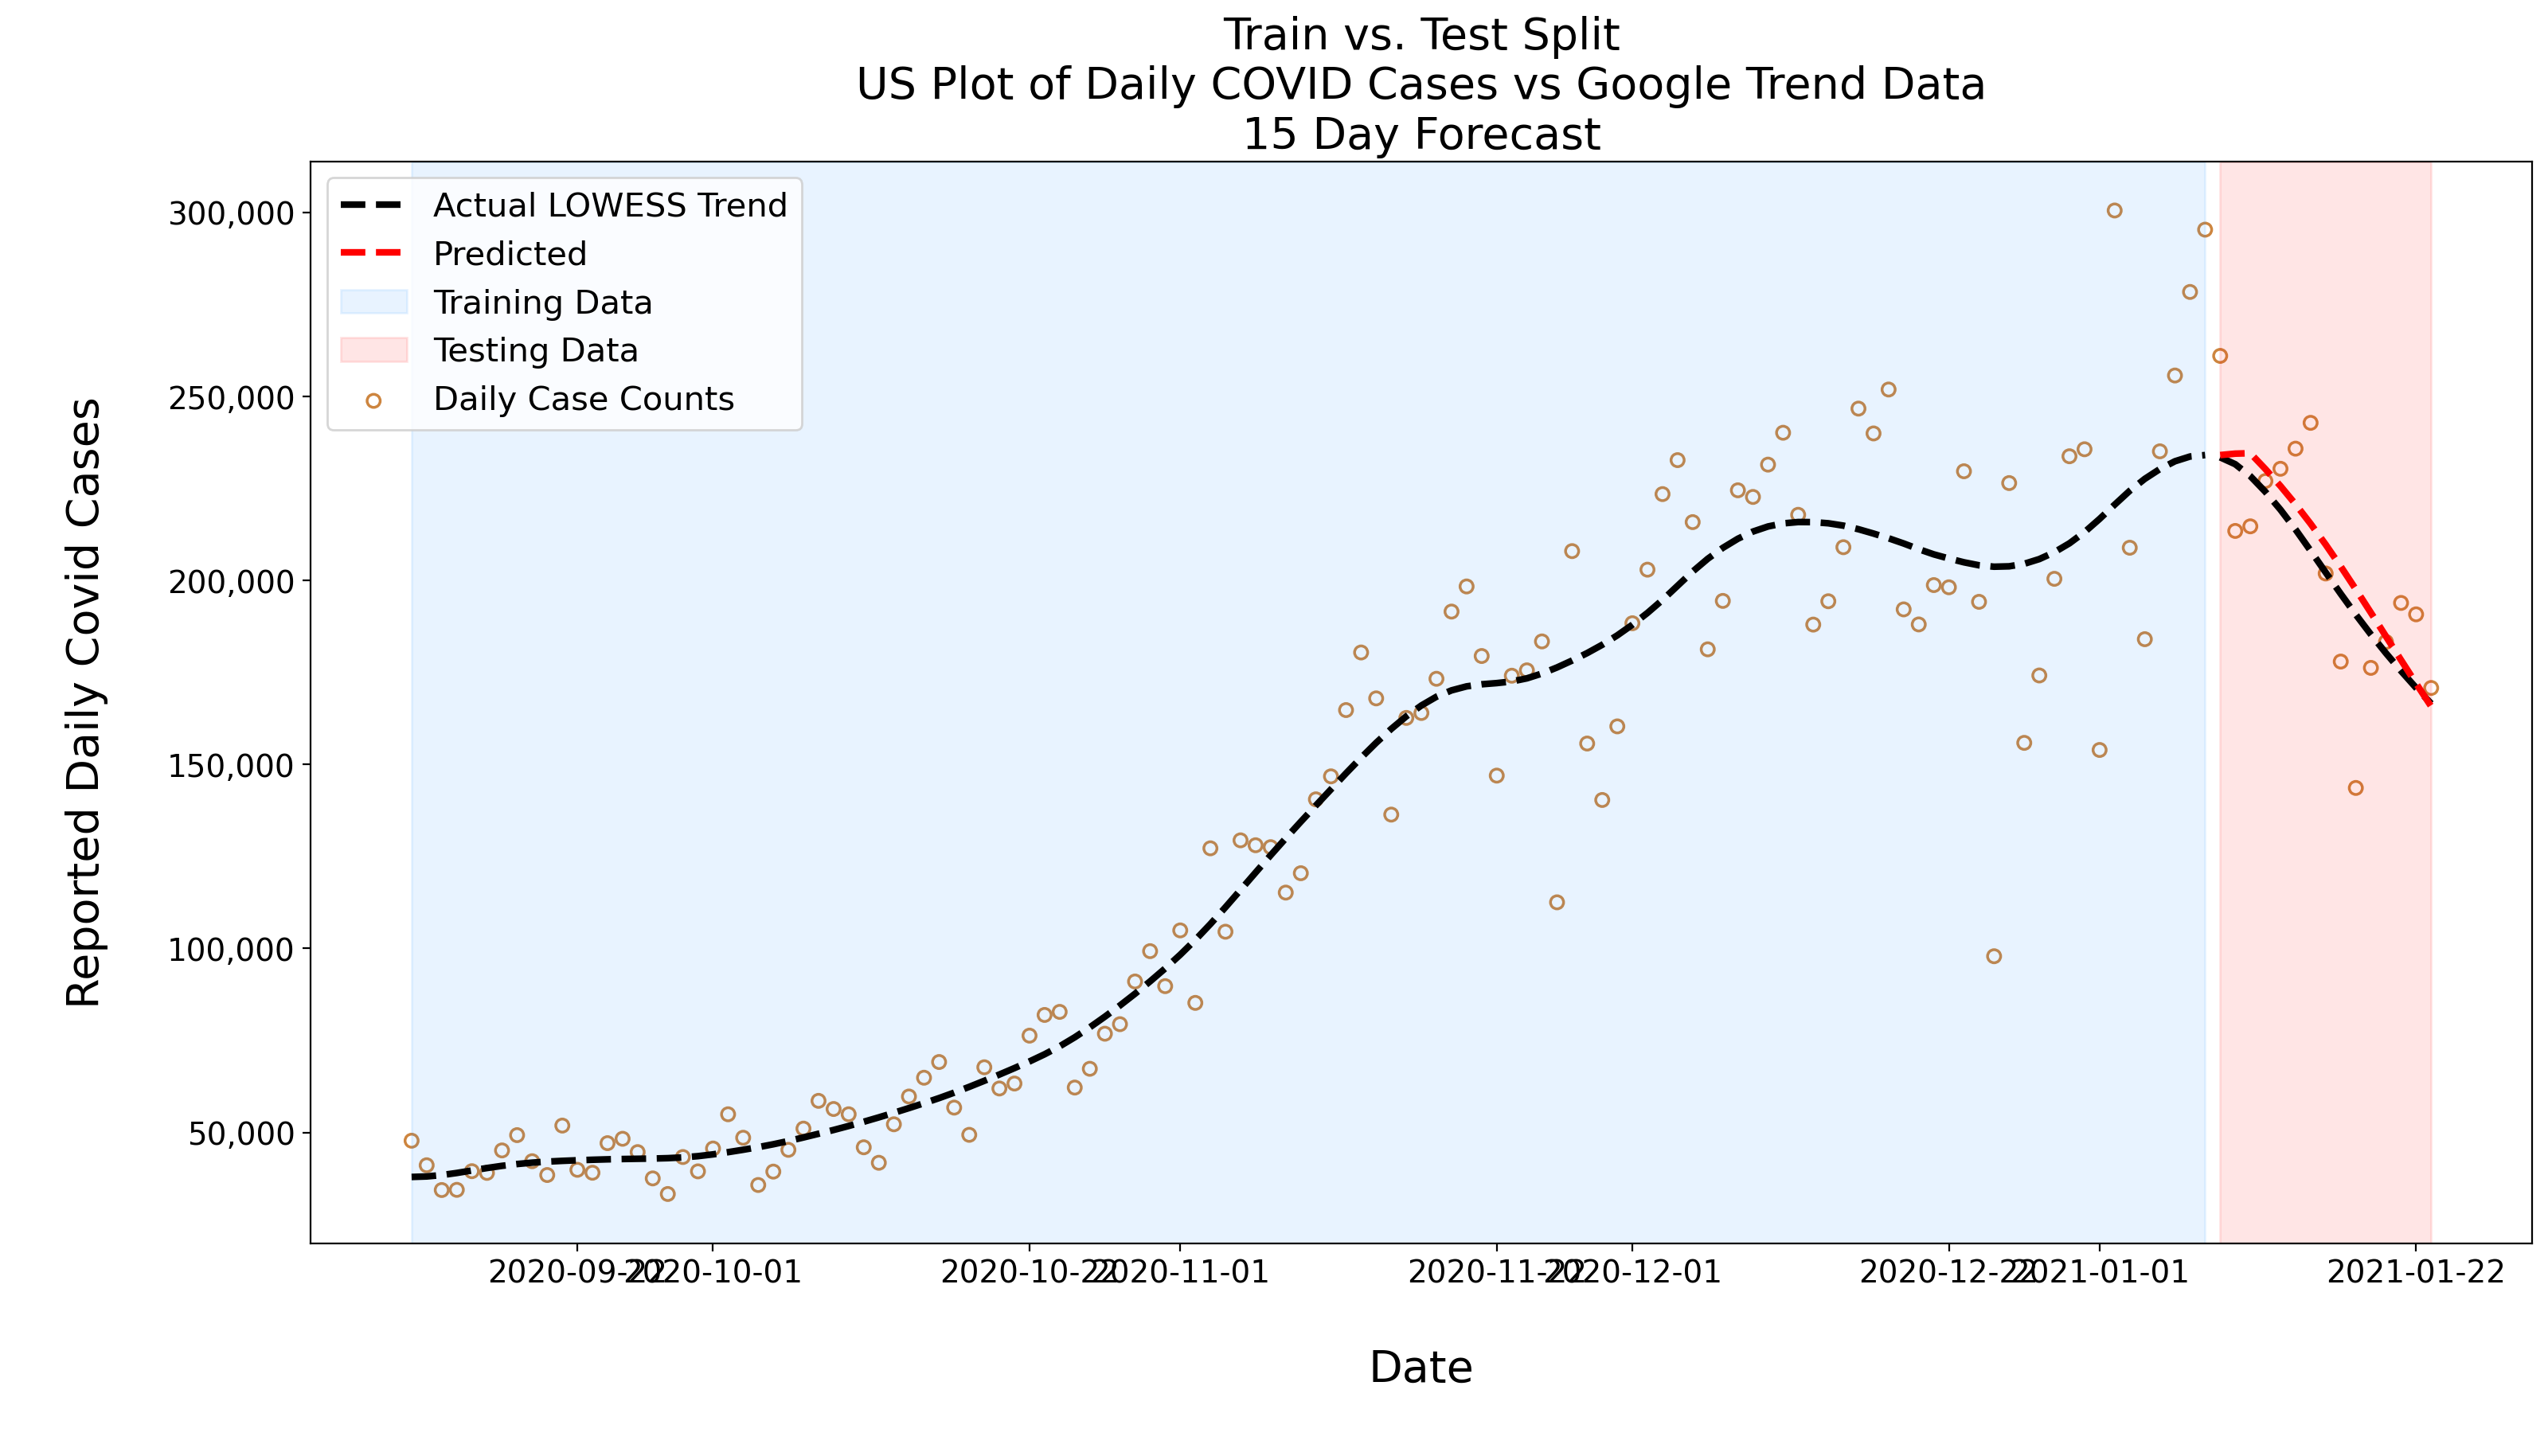

In [86]:
# make the plot of the daily data and smoothed vlaues
plt.style.context('ggplot')
fig, ax1 = plt.subplots(figsize = (18,9), dpi = 200)

fmt = '{x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 
ax1.tick_params(axis='y', labelsize = 14) 
ax1.tick_params(axis='x', labelsize = 14)

ax1.set_title('Train vs. Test Split\n{} Plot of Daily COVID Cases vs Google Trend Data\n{} Day Forecast'.format(COUNTRY_NAME, FORECAST_LENGTH), fontsize = 20)
ax1.set_xlabel('\nDate\n', fontsize = 20)
ax1.set_ylabel('\nReported Daily Covid Cases\n', fontsize = 20)

ax1.scatter(train.index, train.y, facecolors='none', edgecolors='peru', linewidth = 1.25, s = 35, label = 'Daily Case Counts')
ax1.plot(train.index, train.lowess, linestyle = '--', color = 'black', linewidth = 3 ,label = 'Actual LOWESS Trend')
ax1.grid(which = 'major')

ax1.scatter(test.index, test.y, facecolors='none', edgecolors='peru', linewidth = 1.25, s = 35)
ax1.plot(test.index, test.lowess, linestyle = '--', color = 'black', linewidth = 3 )
ax1.plot(test.index, the_forecast, linestyle = '--', color = 'red', linewidth = 3, label = 'Predicted')

ax1.grid(which = 'major')

ax1.axvspan(train_start, train_end, alpha=0.1, color='dodgerblue', label = 'Training Data')
ax1.axvspan(test_start, test_end, alpha=0.1, color='red', label = 'Testing Data')
ax1.legend(loc = 2, fontsize = 15)

plt.show()

# Diagnostic Plots

In [87]:
def create_indexed_dataframe(index,actual,predicted):
  
    #Differenced the actual and predicted columns and add to a list to be put into a dataframe
    actual_diff    = actual.diff().tolist() 
    predicted_diff = predicted.diff().tolist() 
    
    #Put each remaining column into a list
    index          = index.tolist()
    actual         = actual.tolist()
    predicted      = predicted.tolist()

    #Create a dataframe with a dictionary of the remaining lists. 
    df = pd.DataFrame({'Index':  index,
                       'Actual':actual,
                       'Predicted':predicted,
                       'Actual Diff':actual_diff,
                       'Predicted Diff':predicted_diff}).set_index('Index')
    
    #Repace any infinite values with a NaN and then drop any rows with a nan value
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()
    return df

def add_residuals_normalization(df):
    
    import scipy.stats as st
    
    #Create the residuals column, normalized residuals, the Z Score, and Normalized Residuals by Percent for later analysis. 
    df['Residuals'] = df['Predicted'] - df['Actual']
    df['Normalized Residuals'] = (df['Residuals']-df['Residuals'].mean())/(df['Residuals'].max()-df['Residuals'].min())
    df['Residuals Zscore'] = (df['Normalized Residuals'] - df['Normalized Residuals'].mean())/df['Normalized Residuals'].std(ddof=0)
    df['Residuals Normalized Percent'] = df['Residuals Zscore'].apply(lambda x: st.norm.cdf(x))

    return df
    
def mean_forecast_error(actual,predicted):

    #Link:  https://en.wikipedia.org/wiki/Forecast_bias
    
    #A mean forecast error value other than zero suggests a tendency of the model to
    #over forecast (negative error) or under forecast (positive error).
    
    actual    = actual.tolist()
    predicted = predicted.tolist()

    mean_forecast_errors = [actual[i]-predicted[i] for i in range(len(actual))]
    bias = round(sum(mean_forecast_errors) * 1.0/len(actual),4)
    return bias

def mean_absolute_error(actual,predicted):
    
    #Link:  https://en.wikipedia.org/wiki/Mean_absolute_error
    
    from sklearn.metrics import mean_absolute_error
    
    actual    = actual.tolist()
    predicted = predicted.tolist()

    mae = round(mean_absolute_error(actual, predicted),4)
    
    return mae

def mean_squared_error(actual,predicted):
    
    #Link:  https://en.wikipedia.org/wiki/Mean_squared_error
        
    from sklearn.metrics import mean_squared_error
    
    actual    = actual.tolist()
    predicted = predicted.tolist()
    
    mse = round(mean_squared_error(actual,predicted),4)
    return mse

def mean_absolute_percentage_error(actual, predicted): 

    #Link:  https://en.wikipedia.org/wiki/Mean_absolute_percentage_error

    actual, predicted = np.array(actual), np.array(predicted)
    mape = round(np.mean(np.abs((actual - predicted) / actual)) * 100,4)
    
    return mape

def diagnostic_plot(df):
    
    from matplotlib import pyplot as plt
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 18, 1
    plt.figtext(0,0,'Diagnostic Plots',fontsize = 24,fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


    rcParams['figure.figsize'] = 18, 25
        
    fig = plt.figure()
    ax1 = plt.subplot2grid((8, 4), (0, 0), rowspan=2, colspan=4)
    ax2 = plt.subplot2grid((8, 4), (2, 0), rowspan=1, colspan=4)
    ax3 = plt.subplot2grid((8, 4), (3, 0), rowspan=1, colspan=3)
    ax4 = plt.subplot2grid((8, 4), (3, 3), rowspan=1, colspan=1)
    ax5 = plt.subplot2grid((8, 4), (4, 0), rowspan=1, colspan=3)
    ax6 = plt.subplot2grid((8, 4), (4, 3), rowspan=1, colspan=1)
    ax7 = plt.subplot2grid((8, 4), (5, 0), rowspan=3, colspan=2)
    ax8 = plt.subplot2grid((8, 4), (5, 2), rowspan=3, colspan=2)

    ax1.plot(df.index,df['Actual'], color = 'black', linewidth = 4, label = 'Actual')
    ax1.plot(df.index,df['Predicted'], color = 'skyblue', linewidth = 4, label = 'Predicted')
    ax1.set_title('Plot of the Predicted and Actual Values by the Order of the Values',fontsize = 14,fontweight='bold')
    ax1.legend(loc='best')

    ax2.fill_between( df.index,df['Actual Diff'], color="black", alpha=0.9,label = 'Actual Differenced')
    ax2.fill_between( df.index,df['Predicted Diff'], color="skyblue", alpha=0.4,label = 'Predicted Differenced')
    ax2.plot(df.index,df['Predicted Diff'], color="skyblue", linewidth = 4, alpha=0.6)
    ax2.set_title('First Differenced Actual and Predicted Values by the Order of the Values',fontsize = 14,fontweight='bold')
    ax2.legend(loc = 'best')

    ax3.scatter( df.index,df['Residuals'], color="black", s = 30,alpha=0.9, label = 'Residuals')
    ax3.axhline(y=0,color='skyblue',linestyle='--',linewidth = 2)
    ax3.set_title('Residuals vs. The Order of the Data',fontsize = 14,fontweight='bold')
    ax3.set_ylabel('Residuals',fontsize = 12)
    ax3.set_xlabel('Observation Order',fontsize = 12)
    ax3.legend(loc = 'best')
    
    bins = 10
    ax4.hist(df['Residuals'], color="black",bins = bins,orientation="horizontal")
    ax4.axhline(y=0,color='skyblue',linestyle='--',linewidth = 2)
    ax4.set_title('Histogram of the Residuals',fontsize = 14,fontweight='bold')
    ax4.set_ylabel('Residual',fontsize = 12)
    ax4.set_xlabel('Frequency',fontsize = 12)

    ax5.scatter( df['Predicted'],df['Residuals'], color="black", s = 30,alpha=0.9, label = 'Residuals')
    ax5.axhline(y=0,color='skyblue',linestyle='--',linewidth = 2)
    ax5.set_title('Residuals vs. The Fitted Values',fontsize = 14,fontweight='bold')
    ax5.set_ylabel('Residuals',fontsize = 12)
    ax5.set_xlabel('Fitted Values',fontsize = 12)
    ax5.legend(loc = 'best')

    ax6.scatter( df['Residuals'], df['Residuals Normalized Percent'],color="black", s = 30,alpha=0.9, label = 'Residuals')
    ax6.set_title('Normal Probability Plot of the Residuals',fontsize=14,fontweight='bold')
    ax6.set_ylabel('Percent',fontsize = 12)
    ax6.set_xlabel('Residuals',fontsize = 12)
    ax6.legend(loc = 'best')

    x1 = np.linspace(df['Predicted'].min(), df['Predicted'].max())
    ax7.scatter( df['Predicted'],df['Actual'], color="black", s = 30,alpha=0.9)
    ax7.plot(x1,x1, color = 'skyblue')
    ax7.set_title('Actual by Predicted Plot',fontsize=14,fontweight='bold')
    ax7.set_ylabel('Actual Values',fontsize = 12)
    ax7.set_xlabel('Predicted Values',fontsize = 12)

    x2 = np.linspace(df['Predicted Diff'].min(), df['Predicted Diff'].max())
    ax8.scatter( df['Predicted Diff'],df['Actual Diff'], color="black", s = 30,alpha=0.9)
    ax8.plot(x2,x2, color = 'skyblue')
    ax8.set_title('First Differences Actual by Predicted',fontsize=14,fontweight='bold')
    ax8.set_ylabel('Differenced Actual Values',fontsize = 12)
    ax8.set_xlabel('Differenced Predicted Values',fontsize = 12)

    plt.tight_layout()
    plt.show()
    
    return df

def plot_performance_measures(df):

    from matplotlib import pyplot as plt
    from matplotlib import rcParams
    
    index = df.index
    actual = df['Actual']
    predicted = df['Predicted']
    
    
    bias = mean_forecast_error(actual,predicted)
    mae  = mean_absolute_error(actual,predicted)
    mse  = mean_squared_error(actual,predicted)
    mape = mean_absolute_percentage_error(actual,predicted)

    rcParams['figure.figsize'] = 18, 1

    plt.figtext(0,1,'Performance Measures',fontsize = 24,fontweight='bold')
    plt.figtext(0,.3, 'Mean Forecast Error (MFE) / Forecast Bias',fontsize = 22,fontweight='light')
    plt.figtext(0,.0, 'Mean Absolute Error (MAE)',fontsize = 22,fontweight='light')
    plt.figtext(0,-.3,'Mean Squared Error (MSE)'.format(mse),fontsize = 22,fontweight='light')
    plt.figtext(0,-.6,'Mean Absolute Percentage Error (MAPE)',fontsize = 22,fontweight='light')

    #Shift the locations of the scores in the plots to center the decimals!

    shift_bias = str(bias).find('.')*.01
    if bias <0:  shift_bias-= .004
    
    shift_mae  = str(mae).find('.')*.01
    if mae <0:  shift_mae-= .004
    
    shift_mse  = str(mse).find('.')*.01
    if mse <0:  shift_mse-= .004
    
    shift_mape = str(mape).find('.')*.01
    if mape <0:  shift_mape-= .004
    
    #Plot the locations of each statistics -- They should line up by decimal point
    plt.figtext(.5-shift_bias,.3, '{}'.format(bias),fontsize = 22,fontweight='light')
    plt.figtext(.5-shift_mae,.0, '{}'.format(mae) ,fontsize = 22,fontweight='light')
    plt.figtext(.5-shift_mse,-.3,'{}'.format(mse) ,fontsize = 22,fontweight='light')
    plt.figtext(.5-shift_mape,-.6,'{}'.format(mape),fontsize = 22,fontweight='light')


    plt.axis('off')
    plt.tight_layout()
    plt.show()
    return 

def plot_ACF_PACF(df):

    from statsmodels.graphics.tsaplots import plot_acf
    from statsmodels.graphics.tsaplots import plot_pacf
    from matplotlib import pyplot as plt
    from matplotlib import rcParams
    
    #Plot the ACF and PACF figures for the non-differenced and differenced values
    rcParams['figure.figsize'] = 18, 1
    plt.figtext(0,0,'ACF and PACF Plots',fontsize = 24,fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    rcParams['figure.figsize'] = 18, 14

    fig = plt.figure()
    ax1 = plt.subplot2grid((5, 4), (0, 0), rowspan=1, colspan=2)
    ax2 = plt.subplot2grid((5, 4), (0, 2), rowspan=1, colspan=2)
    ax3 = plt.subplot2grid((5, 4), (1, 0), rowspan=1, colspan=2)
    ax4 = plt.subplot2grid((5, 4), (1, 2), rowspan=1, colspan=2)
    ax5 = plt.subplot2grid((5, 4), (2, 0), rowspan=1, colspan=2)
    ax6 = plt.subplot2grid((5, 4), (2, 2), rowspan=1, colspan=2)
    ax7 = plt.subplot2grid((5, 4), (3, 0), rowspan=1, colspan=2)
    ax8 = plt.subplot2grid((5, 4), (3, 2), rowspan=1, colspan=2)
    ax9 = plt.subplot2grid((5, 4), (4, 0), rowspan=1, colspan=2)
    ax10 = plt.subplot2grid((5, 4), (4, 2), rowspan=1, colspan=2)

    if round(len(df)) < 50:
        lags = round(len(df)*.75)
    else:
        lags = 50

    #ACF Plots
    plot_acf(df['Actual'],ax = ax1, use_vlines = True,title = 'ACF of the Actual Values',zero = False, lags = lags)
    plot_acf(df['Actual Diff'],ax = ax3, use_vlines = True,title = 'ACF of the Differenced Actual Values',zero = False, lags = lags)
    plot_acf(df['Predicted'],ax = ax5, use_vlines = True,title = 'ACF of the Predicted Values',zero = False, lags = lags)
    plot_acf(df['Predicted Diff'],ax = ax7, use_vlines = True,title = 'ACF of the Differenced Predicted Values',zero = False, lags = lags)
    plot_acf(df['Residuals'],ax = ax9, use_vlines = True,title = 'ACF of the Residuals',zero = False, lags = lags)

    #PACF Plots
    plot_pacf(df['Actual'],ax = ax2, use_vlines = True,title = 'PACF of the Actual Values',method='ywm',zero = False, lags = lags)
    plot_pacf(df['Actual Diff'],ax = ax4, use_vlines = True,title = 'PACF of the Differenced Actual Values',method='ywm', zero = False, lags = lags)
    plot_pacf(df['Predicted'],ax = ax6, use_vlines = True,title = 'PACF of the Predicted Values',zero = False, method='ywm' ,lags = lags)
    plot_pacf(df['Predicted Diff'],ax = ax8, use_vlines = True,title = 'PACF of the Differenced Predicted Values',method='ywm' ,zero = False, lags = lags)
    plot_pacf(df['Residuals'],ax = ax10, use_vlines = True,title = 'PACF of the Residuals',zero = False, method='ywm' ,lags = lags)

    plt.tight_layout()
    plt.show()
    return

def plot_table(df):
    
    from matplotlib import pyplot as plt
    from matplotlib import rcParams
    
    #Plot the title....
    rcParams['figure.figsize'] = 18, 1
    plt.figtext(0,0,'Table of Values',fontsize = 24,fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    #Plot the table of the values....
    df = round(df[['Actual','Predicted','Residuals','Actual Diff','Predicted Diff','Residuals Normalized Percent']],2)
    rcParams['figure.figsize'] = 18, len(df)/4
    plt.axis('off')
    plt.axis('tight')
    plt.table(cellText = df.values, rowLabels = df.index,colLabels=df.columns,loc='center',fontsize = 12)

    plt.show()
    return df


def time_series_diagnostic_main(index,actual,predicted, show_diagnostic_plots = True, show_performance_measures = True, show_ACF_PACF_plots = True, show_values = True):
    import pandas as pd
    import numpy as np
    from matplotlib import rcParams
    df = create_indexed_dataframe(index,actual,predicted)
    df = add_residuals_normalization(df)
    
    #Generate Plots
    if show_diagnostic_plots == True:
        diagnostic_plot(df)
    else: pass

    if show_performance_measures == True:
        plot_performance_measures(df)
    else: pass
    
    if show_ACF_PACF_plots == True:
        plot_ACF_PACF(df)
    else: pass
    
    if show_values == True:
        plot_table(df)
    else: pass

    
    return df

In [88]:
the_forecast = pd.DataFrame({'index':test.index, 'actual':test.lowess, 'predicted':the_forecast})
                             
index = the_forecast.index
actual = the_forecast.actual
predicted = the_forecast.predicted

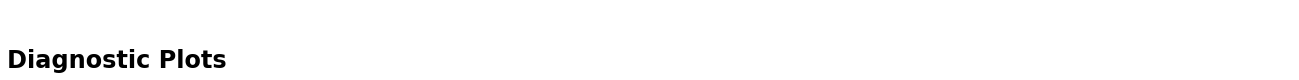

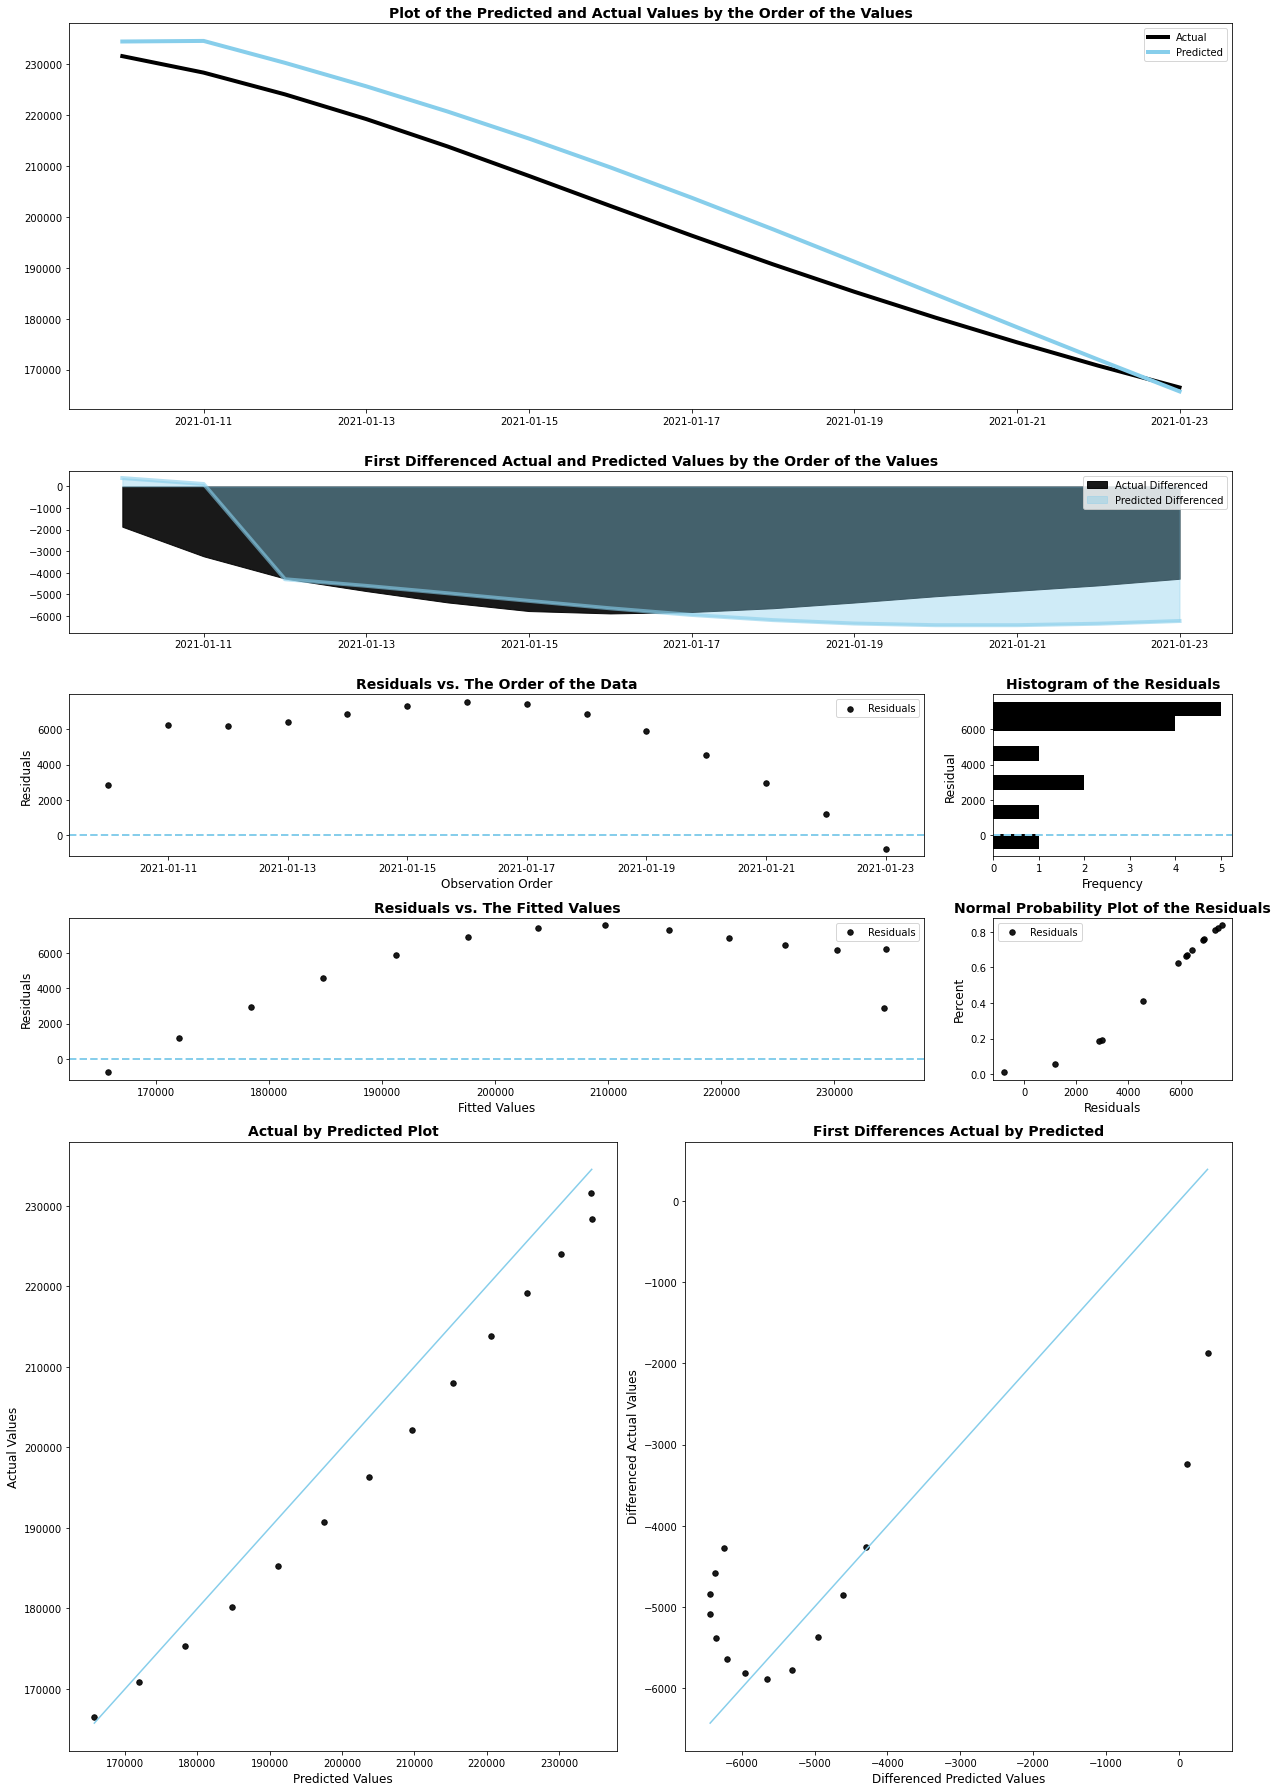

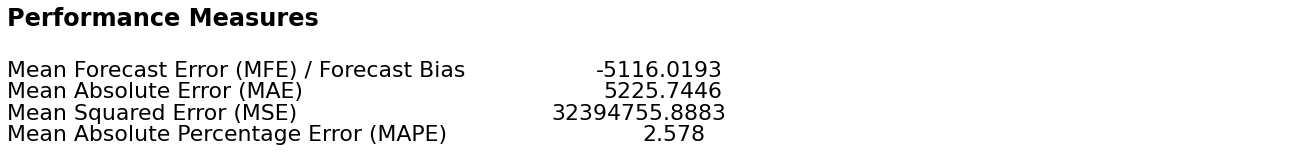

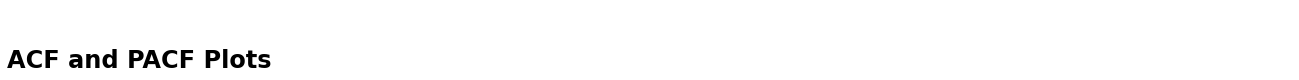

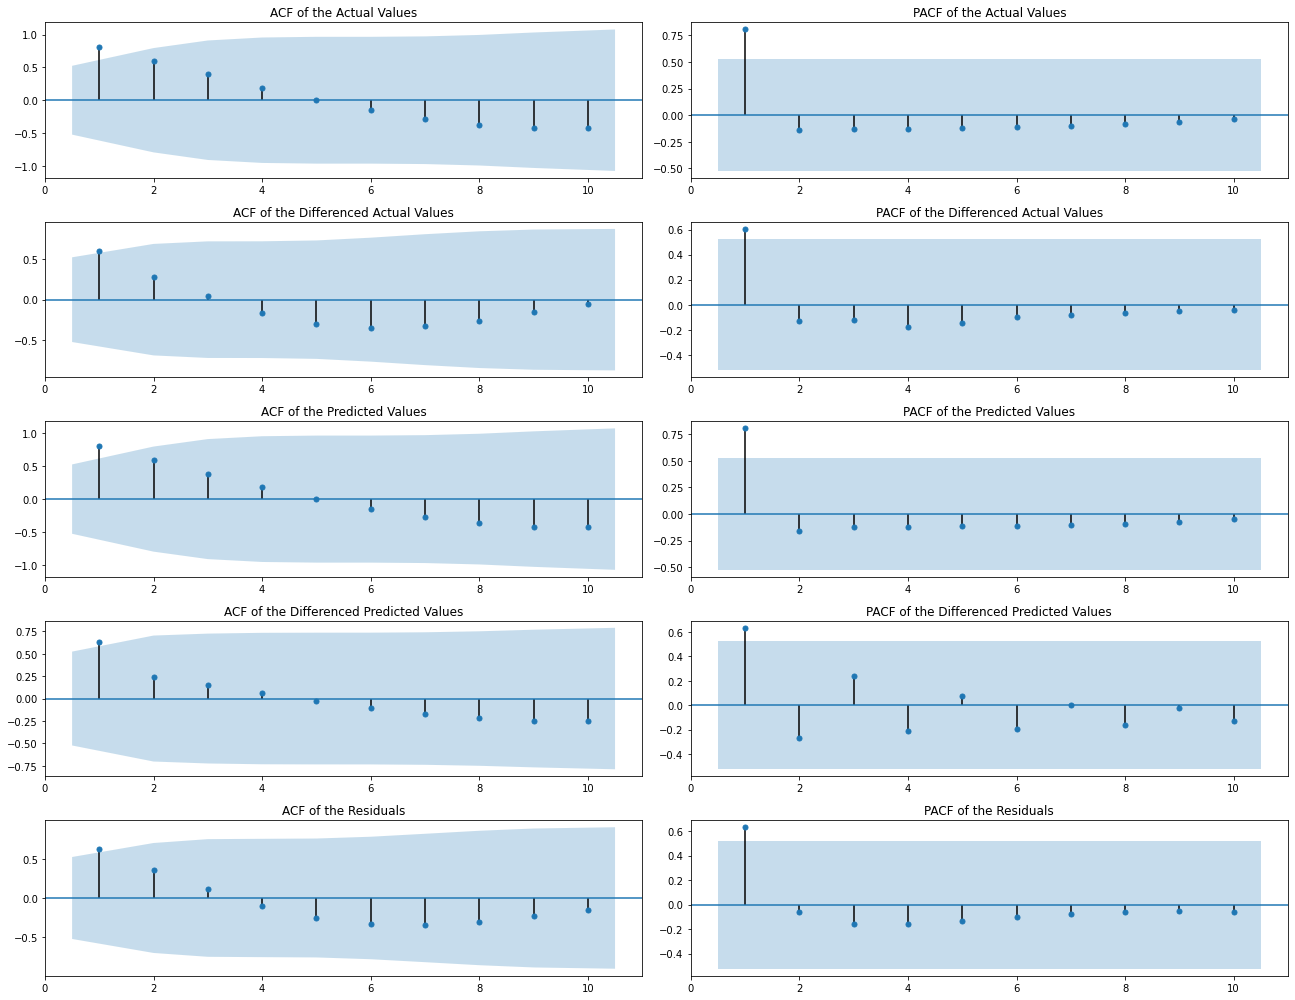

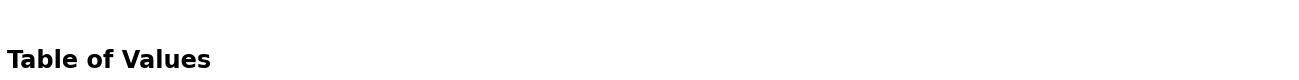

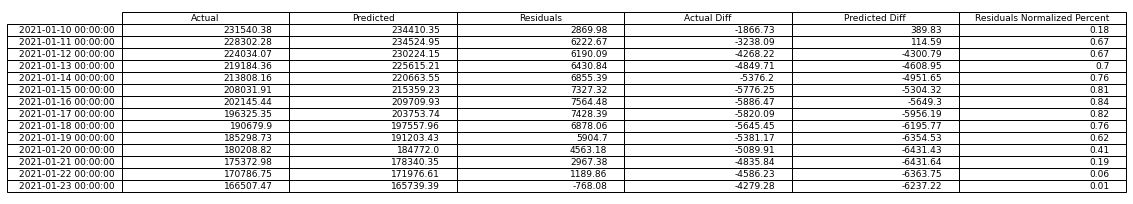

Actual      Predicted  Actual Diff  Predicted Diff  \
Index                                                                   
2021-01-10  231540.376118  234410.354847 -1866.731983      389.831077   
2021-01-11  228302.281906  234524.947304 -3238.094212      114.592457   
2021-01-12  224034.066644  230224.154948 -4268.215263    -4300.792356   
2021-01-13  219184.361219  225615.205565 -4849.705425    -4608.949383   
2021-01-14  213808.159462  220663.551366 -5376.201757    -4951.654199   
2021-01-15  208031.911195  215359.227534 -5776.248267    -5304.323832   
2021-01-16  202145.442066  209709.926463 -5886.469130    -5649.301070   
2021-01-17  196325.349687  203753.736483 -5820.092379    -5956.189980   
2021-01-18  190679.898145  197557.962611 -5645.451542    -6195.773872   
2021-01-19  185298.728757  191203.431713 -5381.169388    -6354.530898   
2021-01-20  180208.816246  184771.997659 -5089.912511    -6431.434053   
2021-01-21  175372.975313  178340.354833 -4835.840934    -6431.642826   
2021-01-22  170786.745260  171976.608410 -4586.230053    -6363.746424   
2021-01-23  166507.469067  165739.392080 -4279.276193    -6237.216329   

              Residuals  Normalized Residuals  Residuals Zscore  \
Index                                                             
2021-01-10  2869.978729             -0.269550         -0.900500   
2021-01-11  6222.665398              0.132810          0.443685   
2021-01-12  6190.088305              0.128900          0.430624   
2021-01-13  6430.844347              0.157794          0.527150   
2021-01-14  6855.391904              0.208744          0.697363   
2021-01-15  7327.316338              0.265380          0.886571   
2021-01-16  7564.484397              0.293843          0.981658   
2021-01-17  7428.386796              0.277510          0.927093   
2021-01-18  6878.064466              0.211465          0.706453   
2021-01-19  5904.702955              0.094651          0.316205   
2021-01-20  4563.181413             -0.066347         -0.221648   
2021-01-21  2967.379521             -0.257861         -0.861450   
2021-01-22  1189.863150             -0.471182         -1.574106   
2021-01-23  -768.076986             -0.706157         -2.359099   

            Residuals Normalized Percent  
Index                                     
2021-01-10                      0.183927  
2021-01-11                      0.671365  
2021-01-12                      0.666629  
2021-01-13                      0.700955  
2021-01-14                      0.757212  
2021-01-15                      0.812345  
2021-01-16                      0.836866  
2021-01-17                      0.823061  
2021-01-18                      0.760047  
2021-01-19                      0.624077  
2021-01-20                      0.412294  
2021-01-21                      0.194495  
2021-01-22                      0.057731  
2021-01-23                      0.009160

In [89]:
time_series_diagnostic_main(index,actual,predicted)